# Bishop Basement Model

## Import packages

In [1]:
import pathlib
import pickle
import string

import numpy as np
import polartoolkit as ptk
import scipy as sp
import verde as vd
import xarray as xr

import invert4geom

/home/mdtanker/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Get data

Here we will load a commonly used synthetic gravity and basement topography model, called the `Bishop Model`. It includes topography of the Moho and the sediment-basement contact, and the forward modelled gravity effect of each, providing a synthetic observed gravity dataset. The forward gravity is calculated with 6 layers of sediment which increase in density from 2100 kg/m3 at 0m to 2600 kg/m3 at the basement surface. Then 3 layers of increasing density from 2700 kg/m3 to 3300 kg/m3 at the Moho surface. 

In [2]:
grid = invert4geom.load_bishop_model(coarsen_factor=50)

grid = grid.rename({"gravity": "gravity_anomaly_no_noise"})

# contaminate gravity with 0.2 mGal of random noise
grid["gravity_anomaly"], stddev = invert4geom.contaminate(
    grid.gravity_anomaly_no_noise,
    stddev=0.2,
    percent=False,
    seed=0,
)
grid["uncert"] = xr.full_like(grid.gravity_anomaly, stddev)
grid["upward"] = xr.full_like(grid.gravity_anomaly, 10)
grid

<xarray.Dataset> Size: 74kB
Dimensions:                   (northing: 40, easting: 38)
Coordinates:
  * easting                   (easting) float64 304B 6.9e+03 ... 3.769e+05
  * northing                  (northing) float64 320B 1.459e+05 ... 5.359e+05
Data variables:
    basement_topo             (northing, easting) float64 12kB -6.199e+03 ......
    moho_topo                 (northing, easting) float64 12kB -2.767e+04 ......
    gravity_anomaly_no_noise  (northing, easting) float64 12kB 99.08 ... 107.0
    gravity_anomaly           (northing, easting) float64 12kB 99.11 ... 106.9
    uncert                    (northing, easting) float64 12kB 0.2 0.2 ... 0.2
    upward                    (northing, easting) float64 12kB 10.0 ... 10.0

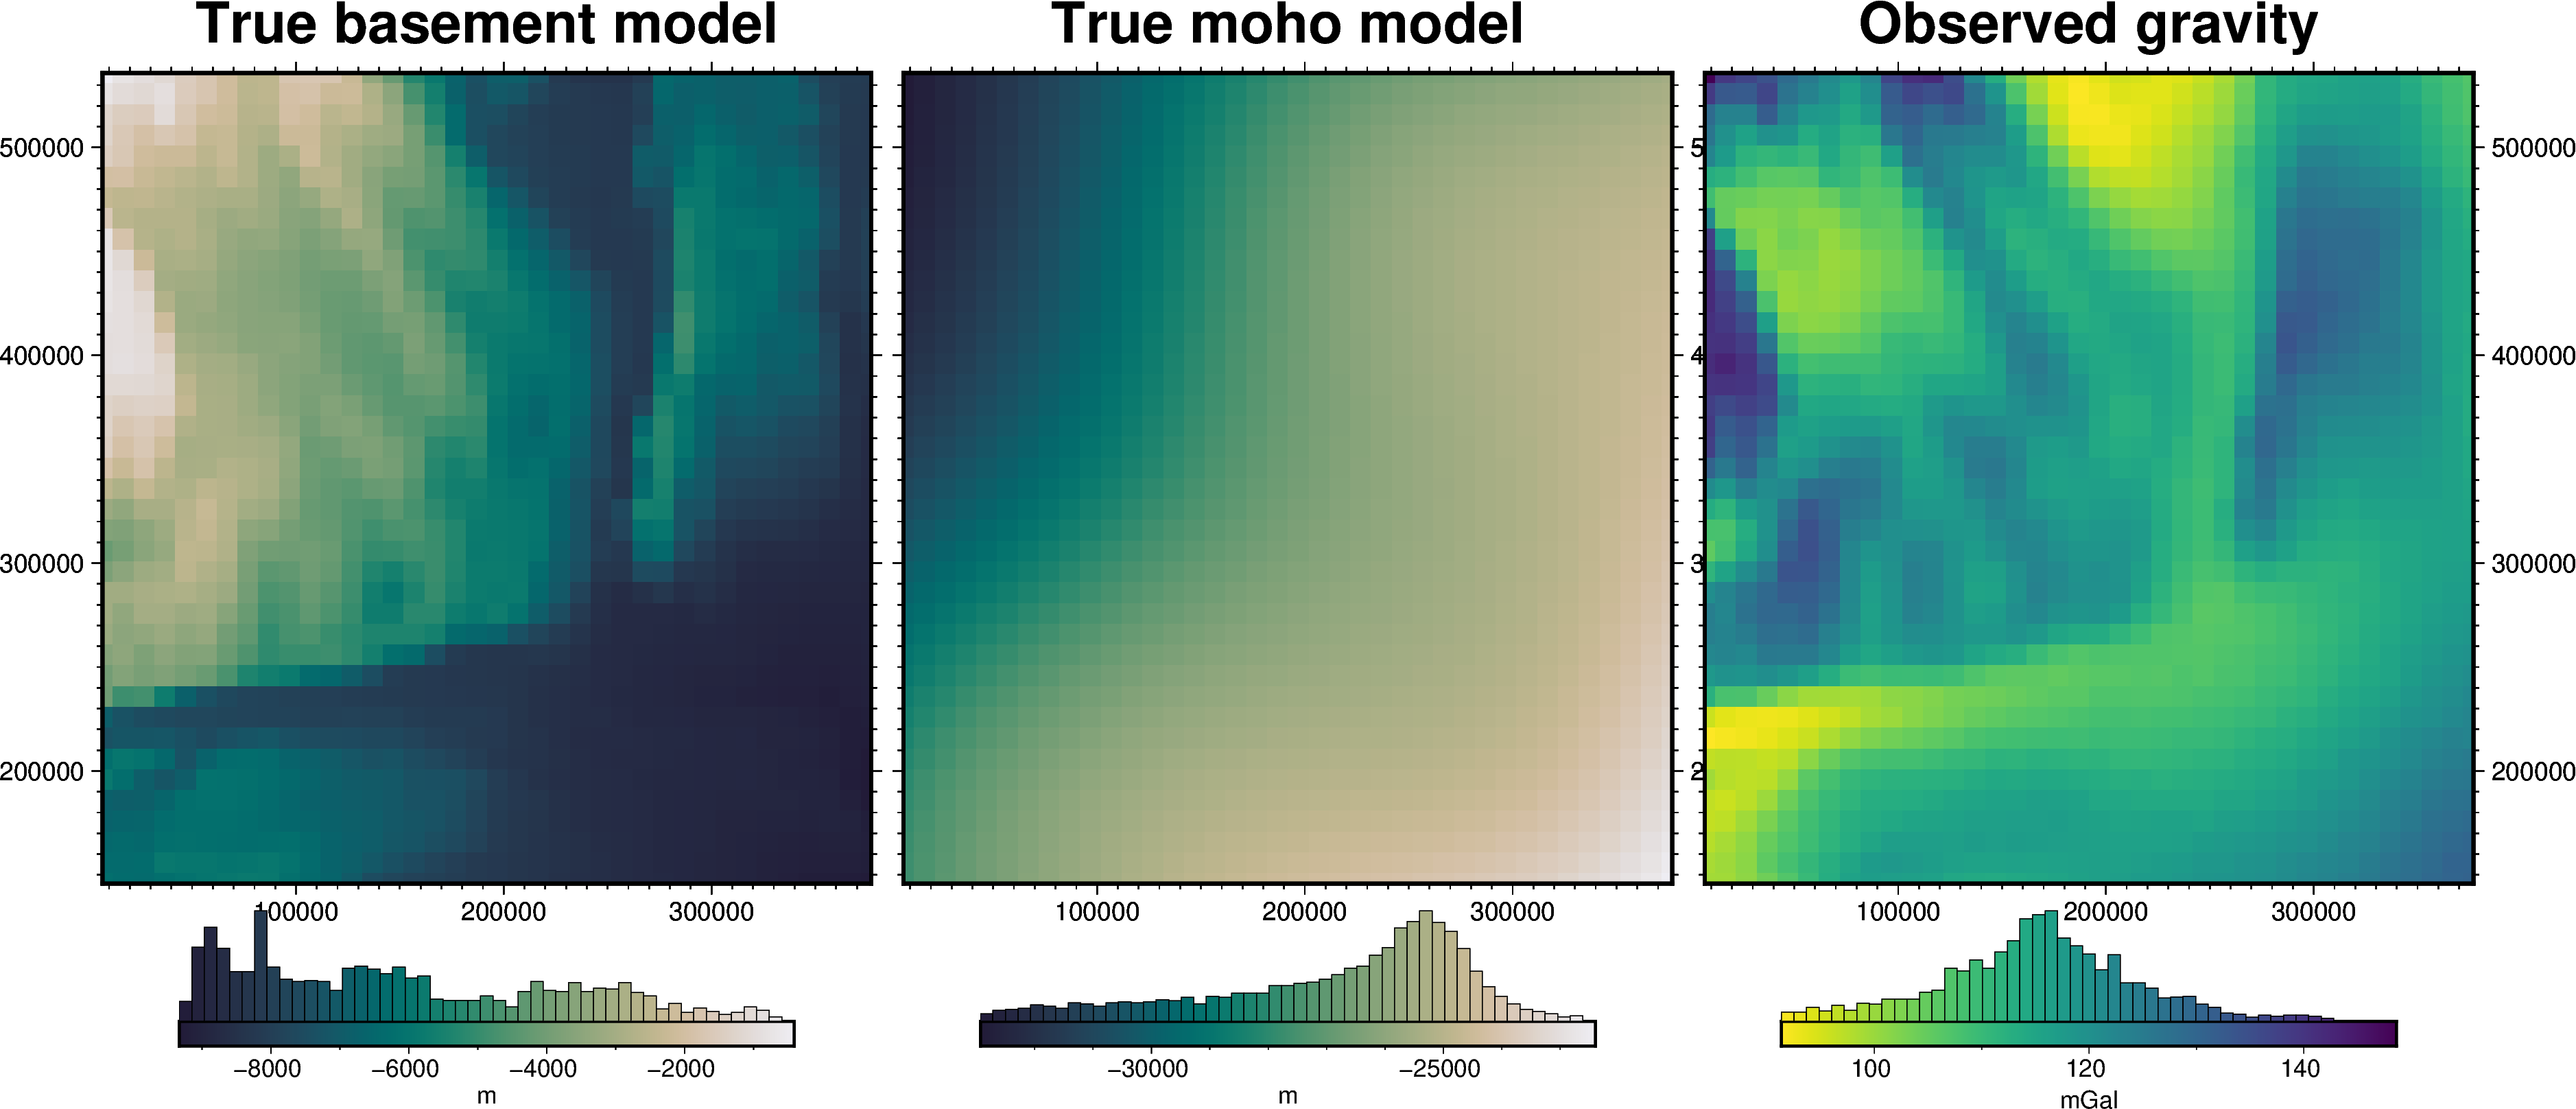

In [3]:
fig = ptk.plot_grid(
    grid.basement_topo,
    fig_height=10,
    title="True basement model",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = ptk.plot_grid(
    grid.moho_topo,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="True moho model",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = ptk.plot_grid(
    grid.gravity_anomaly,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    reverse_cpt=True,
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## Define model domain parameters
To account for edge effects (decreasing gravity towards the edge of prism model), we will use a buffer region so the prism model edge is further away from the inversion domain (the gravity data extent).

In [4]:
# get full region of gravity data
full_region = vd.get_region((grid.easting.values, grid.northing.values))
full_region

(np.float64(6900.0),
 np.float64(376900.0),
 np.float64(145900.0),
 np.float64(535900.0))

In [5]:
# zoom in by 10 km from each side
inversion_region = vd.pad_region(full_region, -10e3)
inversion_region

(np.float64(16900.0),
 np.float64(366900.0),
 np.float64(155900.0),
 np.float64(525900.0))

In [6]:
grav_grid = grid[["gravity_anomaly", "uncert", "upward"]]

# only retain data within the inversion region
grav_grid = grav_grid.sel(
    easting=slice(inversion_region[0], inversion_region[1]),
    northing=slice(inversion_region[2], inversion_region[3]),
)

## Observed gravity data

In this scenario, we are treating the area as having no surface topography (surface elevation is flat and equal to the ellipsoid). In this case, there is no terrain mass effect, and therefore the gravity disturbance is equal to the topo-free disturbance.

In [7]:
grav_data = invert4geom.create_data(grav_grid)

print(f"Gravity region (W,E,S,N): {grav_data.region}")
print(f"Gravity spacing: {grav_data.spacing} m")

grav_data

Gravity region (W,E,S,N): (16900.0, 366900.0, 155900.0, 525900.0)
Gravity spacing: 10000.0 m


<xarray.Dataset> Size: 33kB
Dimensions:          (northing: 38, easting: 36)
Coordinates:
  * easting          (easting) float64 288B 1.69e+04 2.69e+04 ... 3.669e+05
  * northing         (northing) float64 304B 1.559e+05 1.659e+05 ... 5.259e+05
Data variables:
    gravity_anomaly  (northing, easting) float64 11kB 99.56 101.2 ... 108.6
    uncert           (northing, easting) float64 11kB 0.2 0.2 0.2 ... 0.2 0.2
    upward           (northing, easting) float64 11kB 10.0 10.0 ... 10.0 10.0
Attributes:
    region:        (16900.0, 366900.0, 155900.0, 525900.0)
    spacing:       10000.0
    buffer_width:  40000.0
    inner_region:  (56900.0, 326900.0, 195900.0, 485900.0)
    dataset_type:  data
    model_type:    prisms

## Create "a-priori" basement measurements

In [8]:
# create grid of 36 points
coords = vd.grid_coordinates(
    region=vd.pad_region(inversion_region, -30e3),
    shape=(6, 6),
)
da = vd.make_xarray_grid(coords, data=np.ones_like(coords[0]), data_names="upward")
constraint_points = vd.grid_to_table(da).drop(columns=["upward"])

# sample true topography at these points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    grid.basement_topo,
    "true_upward",
)

constraint_points["upward"] = constraint_points.true_upward

# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 2% of depth
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "true_uncert"] = uncert

constraint_points = invert4geom.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="true_uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.true_uncert**2)

# create estimated uncertainty column
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points.head()

northing   easting  true_upward       upward  true_uncert    weight  \
0  185900.0   46900.0 -6209.559082 -6193.944497   124.191182  0.000065   
1  185900.0  104900.0 -6719.067441 -6736.819871   134.381349  0.000055   
2  185900.0  162900.0 -7276.991871 -7183.784863   145.539837  0.000047   
3  185900.0  220900.0 -8420.454391 -8402.788258   168.409088  0.000035   
4  185900.0  278900.0 -8821.850945 -8916.362853   176.437019  0.000032   

       uncert  
0  123.878890  
1  134.736397  
2  143.675697  
3  168.055765  
4  178.327257

## Create starting basement model

In [9]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=full_region,
    spacing=grav_data.spacing,
    constraints_df=constraint_points,
    # dampings=np.logspace(-40, 0, 200),
    dampings=None,
    # weights=constraint_points.weight,
)

starting_topography = invert4geom.create_topography(
    **starting_topography_kwargs,
)

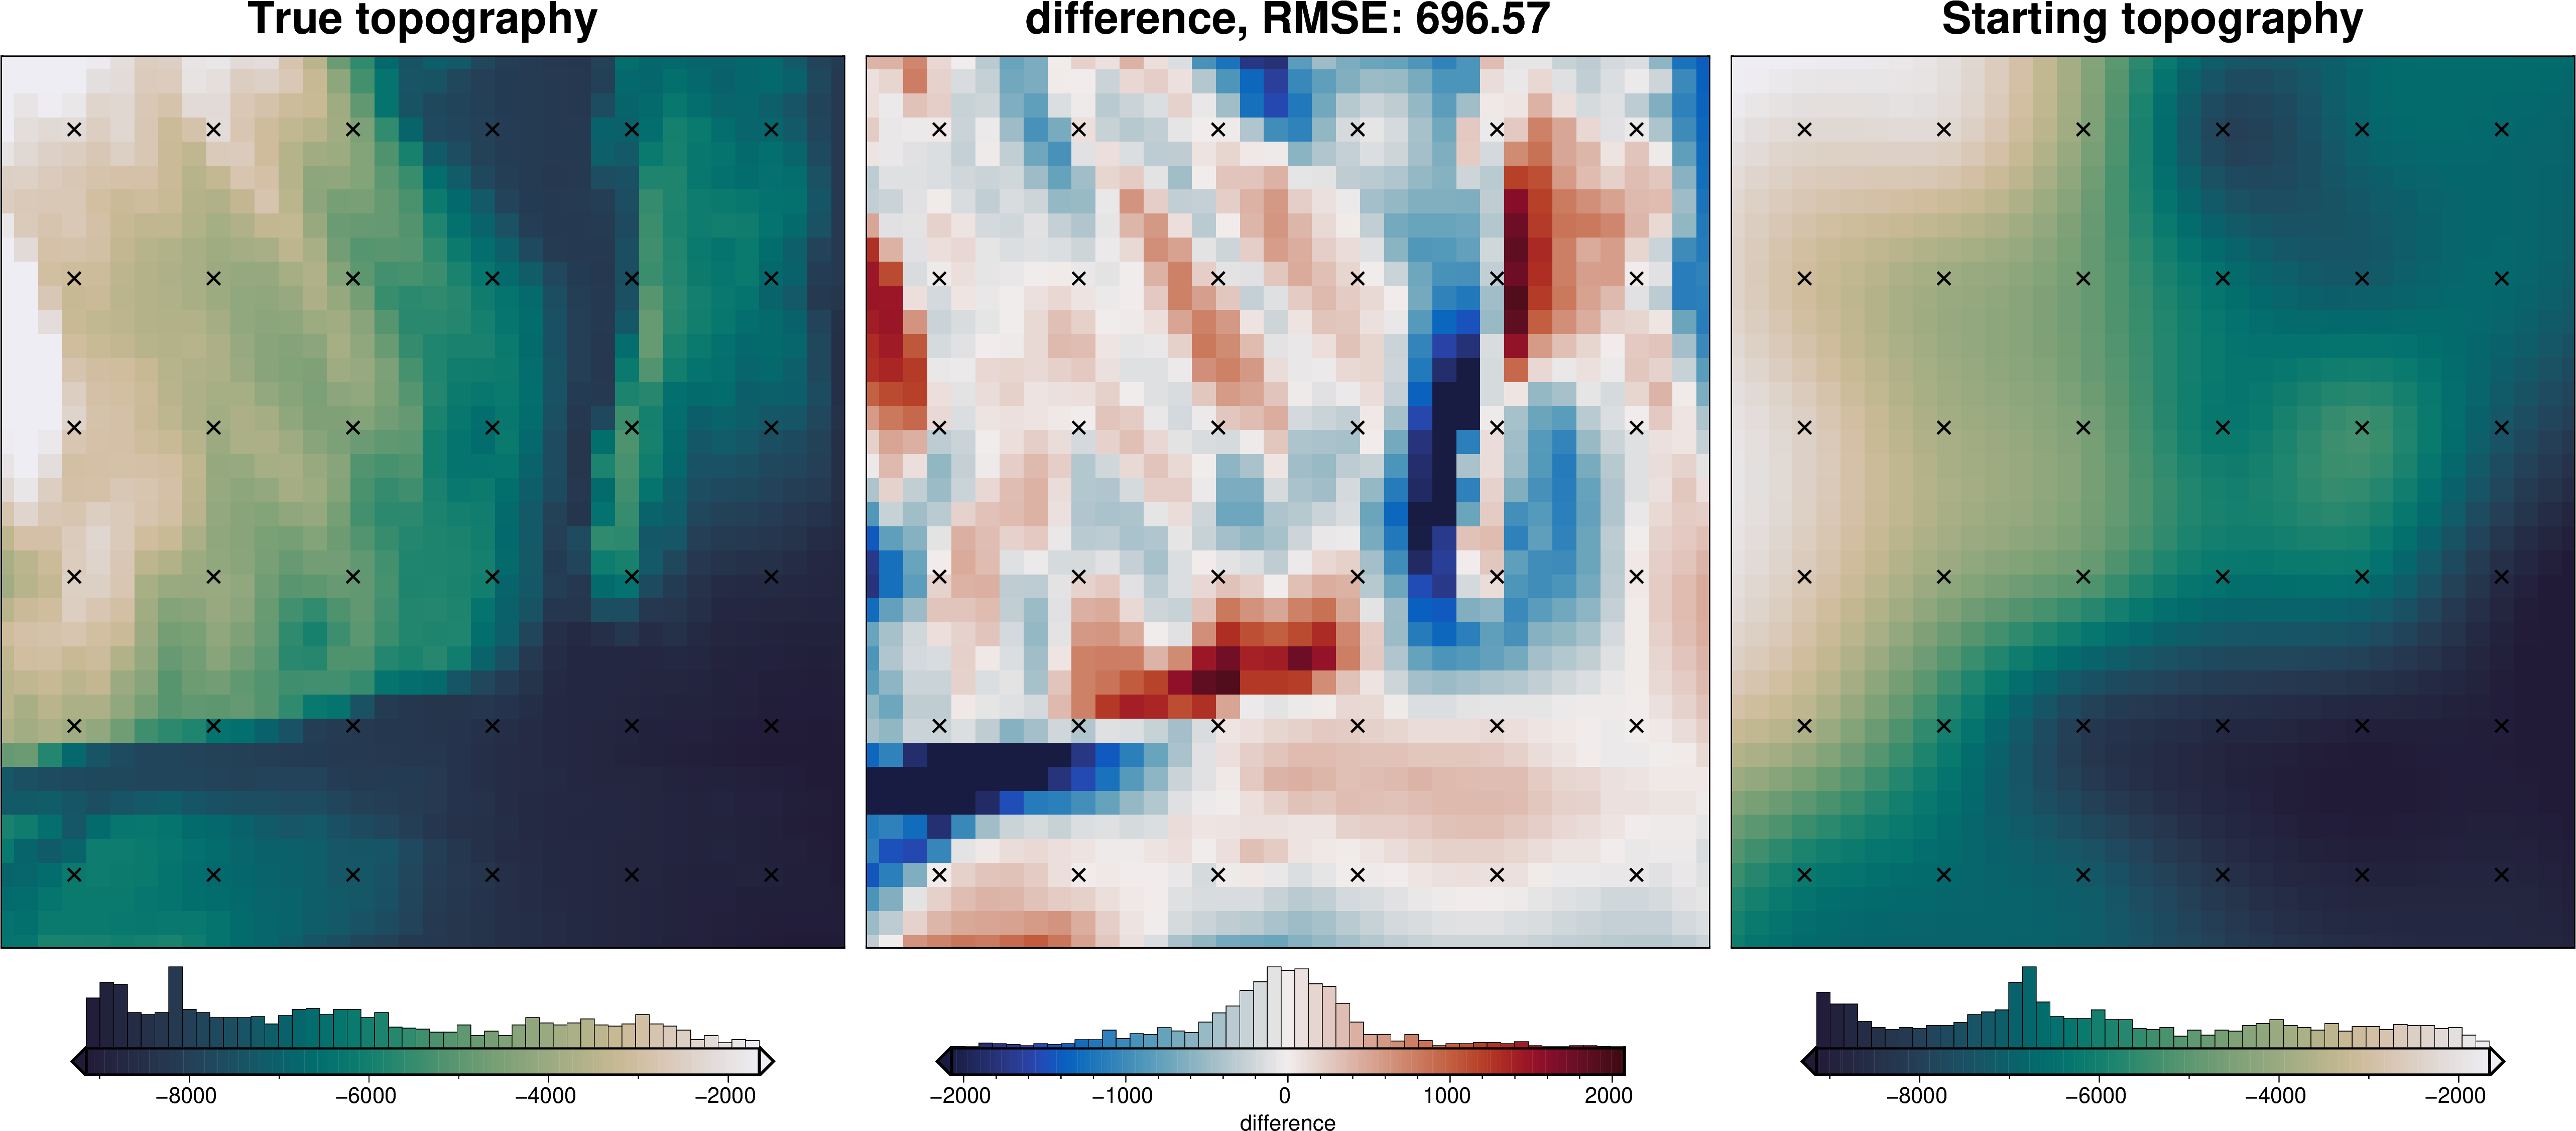

In [10]:
_ = ptk.grid_compare(
    grid.basement_topo,
    starting_topography.upward,
    region=inversion_region,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [11]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    starting_topography.upward,
    "starting_topography",
)

rmse = invert4geom.rmse(
    constraint_points.true_upward - constraint_points.starting_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 84.87 m


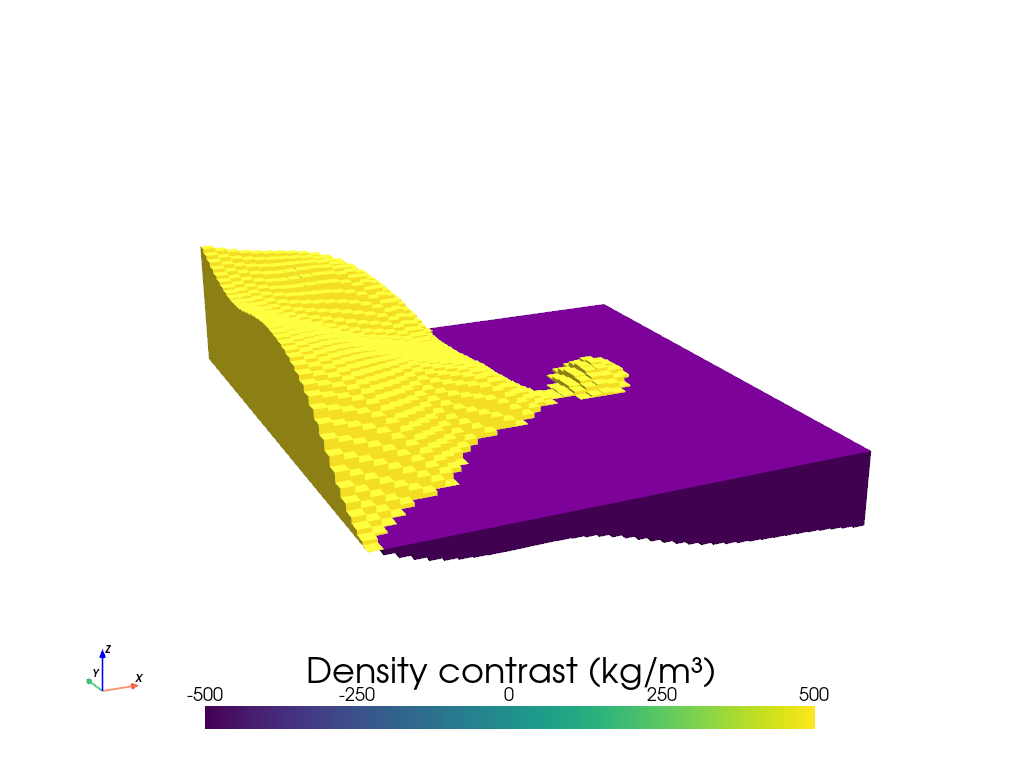

In [12]:
# create model object
model = invert4geom.create_model(
    zref=constraint_points.upward.mean(),
    density_contrast=2800 - 2300,
    topography=starting_topography,
)
model.inv.plot_model(
    color_by="density",
    zscale=20,
)

## Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

However, if we know nothing about the starting model, it can simply be a flat layer of zero thickness, as we will use here. In this case, the forward gravity would just be zero so there is no need to perform the forward modelling. The misfit is therefore just equal to the topo-free disturbance.

### Forward gravity of starting prism layer

In [13]:
# calculate forward gravity of starting prism layer
grav_data.inv.forward_gravity(model)

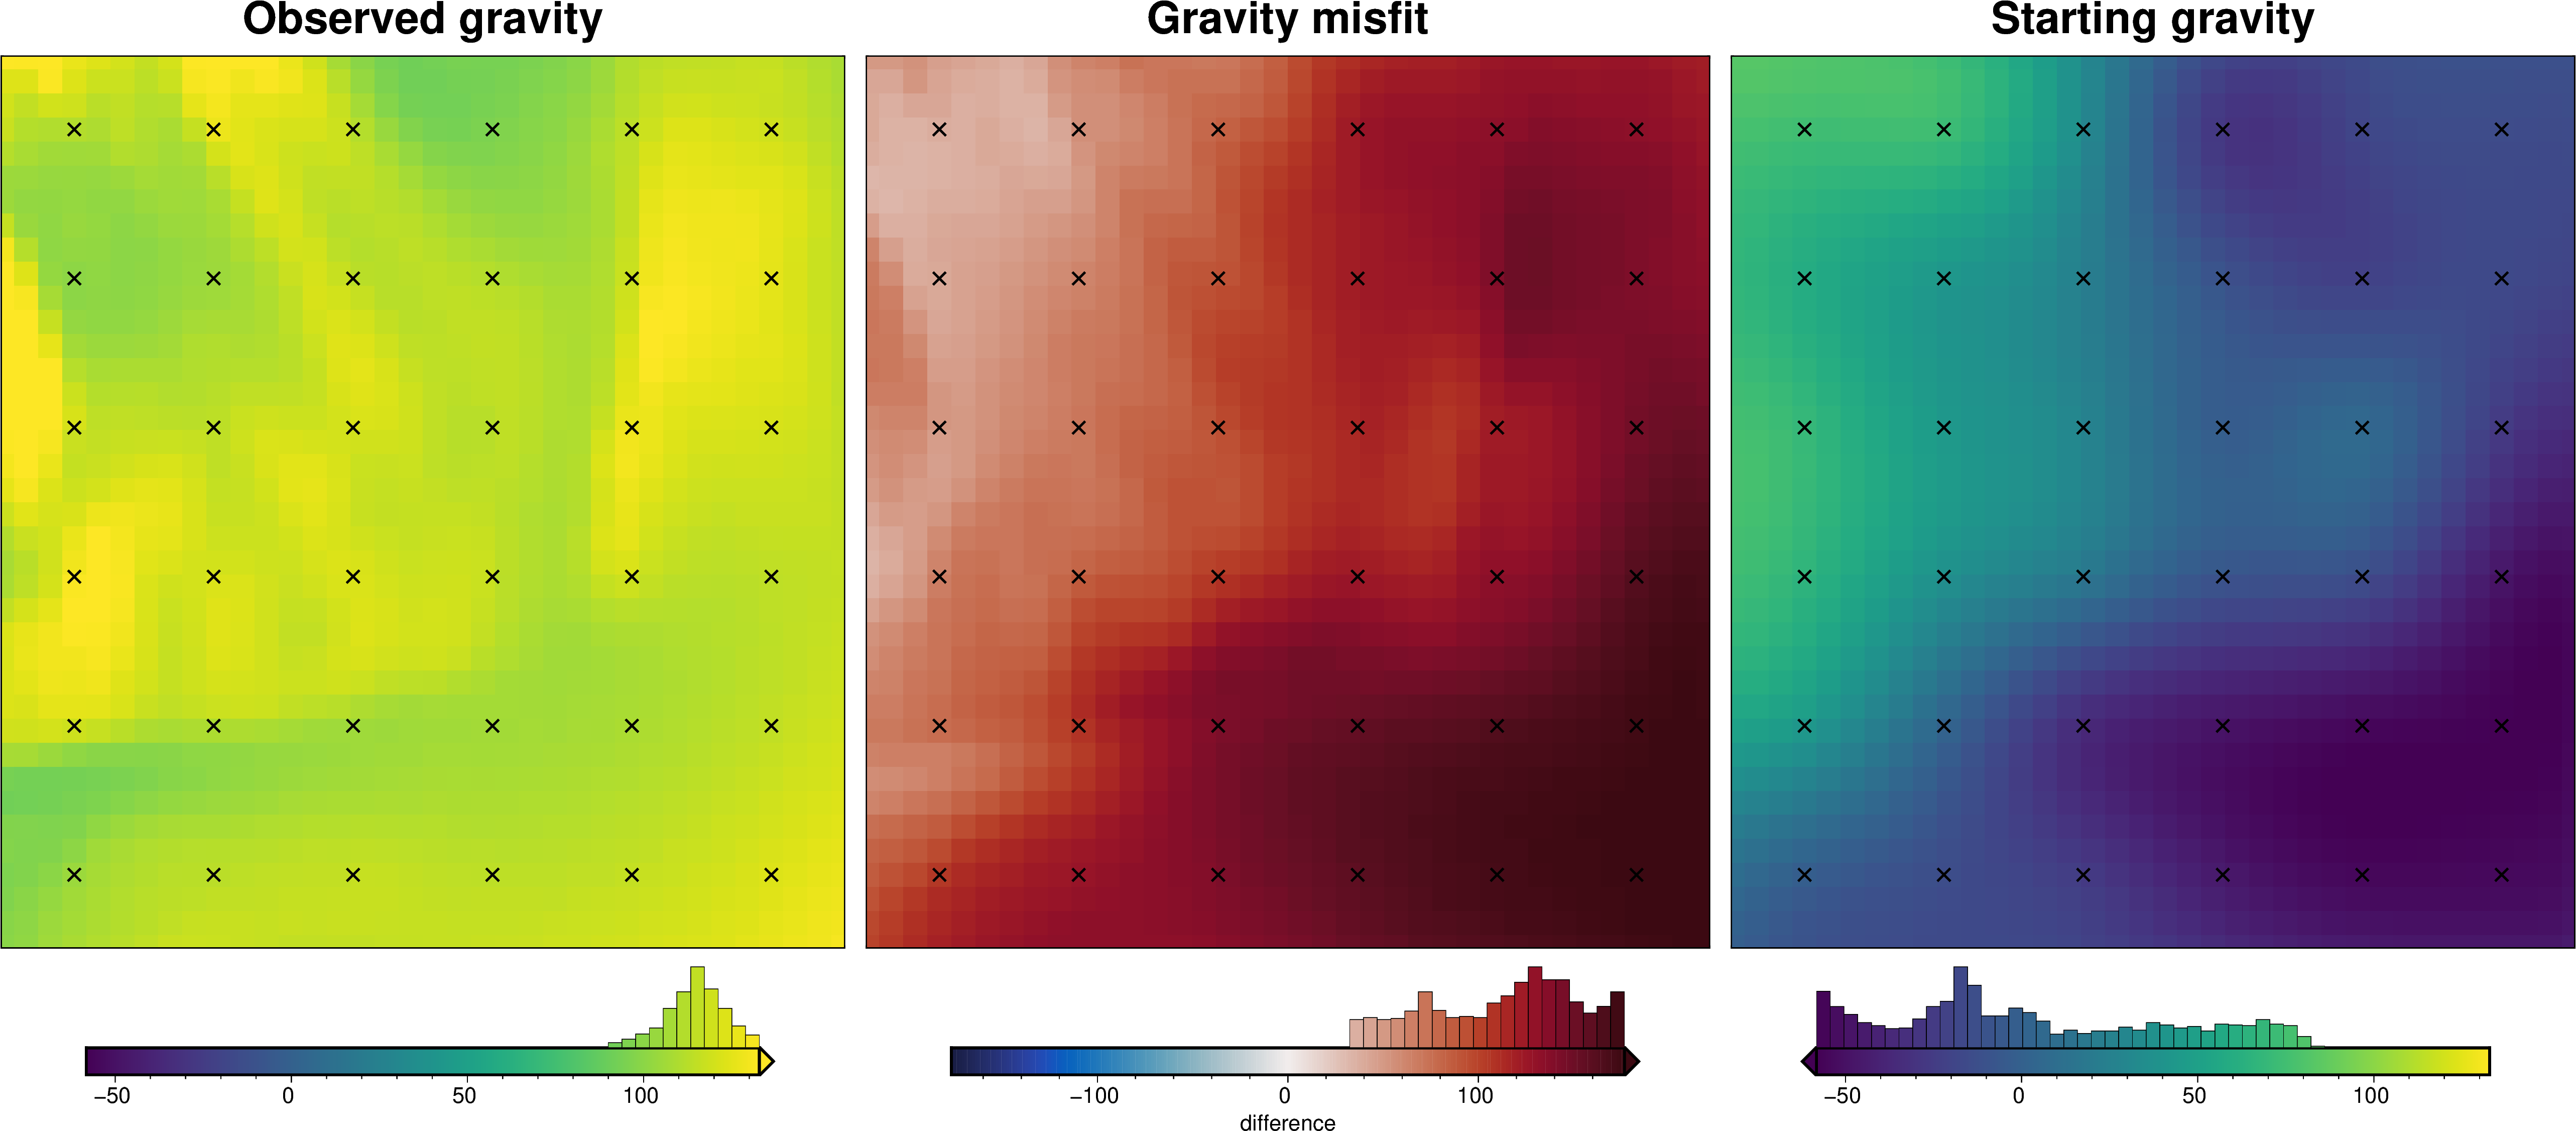

In [14]:
_ = ptk.grid_compare(
    grav_data.gravity_anomaly,
    grav_data.forward_gravity,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="Gravity misfit",
    rmse_in_title=False,
    points=constraint_points,
    points_style="x.3c",
)

### Regional estimation - constraint point minimization

In [15]:
# use the constraints to find the best regional field
regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    # constraints_weights_column="weight",
    cv=True,
    cv_kwargs=dict(
        n_trials=50,
        damping_limits=(1e-60, 10),
        depth_limits=(100, 1000e3),
        progressbar=False,
        fname="../tmp/bishop_model_regional_sep",
    ),
    # damping=None,
    # depth="default",
    block_size=None,
)

grav_data.inv.regional_separation(
    **regional_grav_kwargs,
)

grav_data.inv.df.describe()

northing        easting  gravity_anomaly        uncert  upward  \
count    1368.000000    1368.000000      1368.000000  1.368000e+03  1368.0   
mean   340900.000000  191900.000000       115.021219  2.000000e-01    10.0   
std    109698.662868  103920.936691         8.668170  8.329718e-17     0.0   
min    155900.000000   16900.000000        91.608025  2.000000e-01    10.0   
25%    245900.000000  104400.000000       109.730411  2.000000e-01    10.0   
50%    340900.000000  191900.000000       115.379669  2.000000e-01    10.0   
75%    435900.000000  279400.000000       120.316522  2.000000e-01    10.0   
max    525900.000000  366900.000000       142.955701  2.000000e-01    10.0   

       forward_gravity       misfit          reg          res  \
count      1368.000000  1368.000000  1368.000000  1368.000000   
mean          0.896367   114.124852   114.503613    -0.378761   
std          40.280643    39.807129    39.930377     5.705424   
min         -59.217044    32.942960    32.005242   -22.027095   
25%         -27.678731    80.084974    81.856991    -2.757340   
50%          -8.689017   122.087862   122.983948    -0.412240   
75%          35.669196   144.293965   142.932037     1.920696   
max          82.655013   179.574375   178.023126    34.736012   

       starting_forward_gravity  starting_misfit  starting_reg  starting_res  
count               1368.000000      1368.000000   1368.000000   1368.000000  
mean                   0.896367       114.124852    114.503613     -0.378761  
std                   40.280643        39.807129     39.930377      5.705424  
min                  -59.217044        32.942960     32.005242    -22.027095  
25%                  -27.678731        80.084974     81.856991     -2.757340  
50%                   -8.689017       122.087862    122.983948     -0.412240  
75%                   35.669196       144.293965    142.932037      1.920696  
max                   82.655013       179.574375    178.023126     34.736012

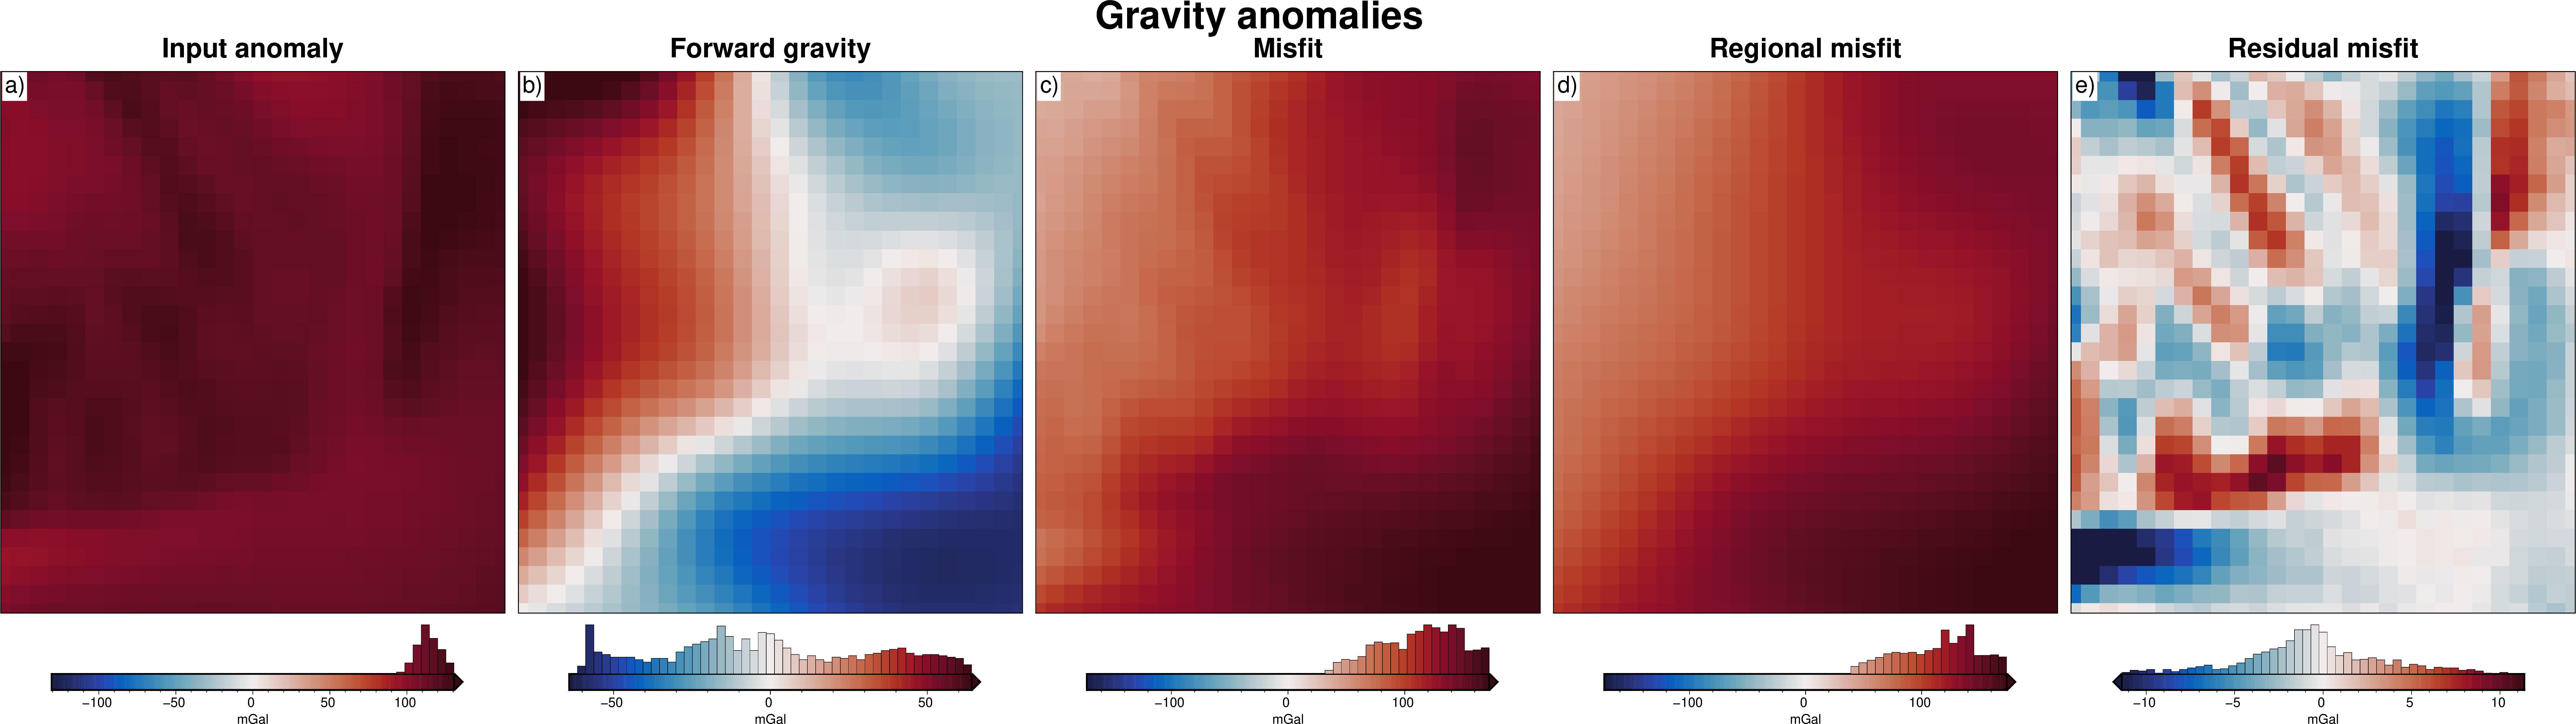

In [16]:
grav_data.inv.plot_anomalies()

## Single inversion
Perform a single inversion to experiment with values of stopping criteria.

In [17]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    solver_damping=0.01,
    # set stopping criteria
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.008,
)

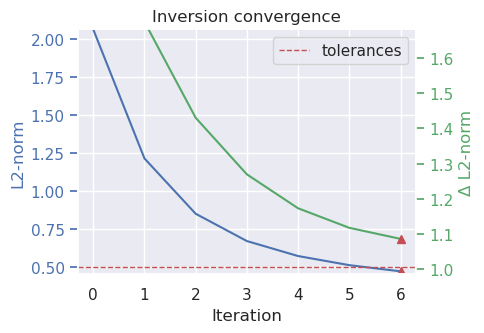

In [18]:
# run the inversion
inv.invert(
    plot_dynamic_convergence=True,
    results_fname="../tmp/bishop_model",
)

In [19]:
inv.stats_df

iteration      rmse   l2_norm  delta_l2_norm  iter_time_sec
0        0.0  4.269797  2.066349            inf            NaN
1        1.0  1.474590  1.214327       1.701641       1.004569
2        2.0  0.721378  0.849340       1.429731       0.141187
3        3.0  0.447608  0.669035       1.269499       0.130926
4        4.0  0.325110  0.570184       1.173367       0.128344
5        5.0  0.260085  0.509985       1.118040       0.132945
6        6.0  0.220233  0.469290       1.086717       0.150388

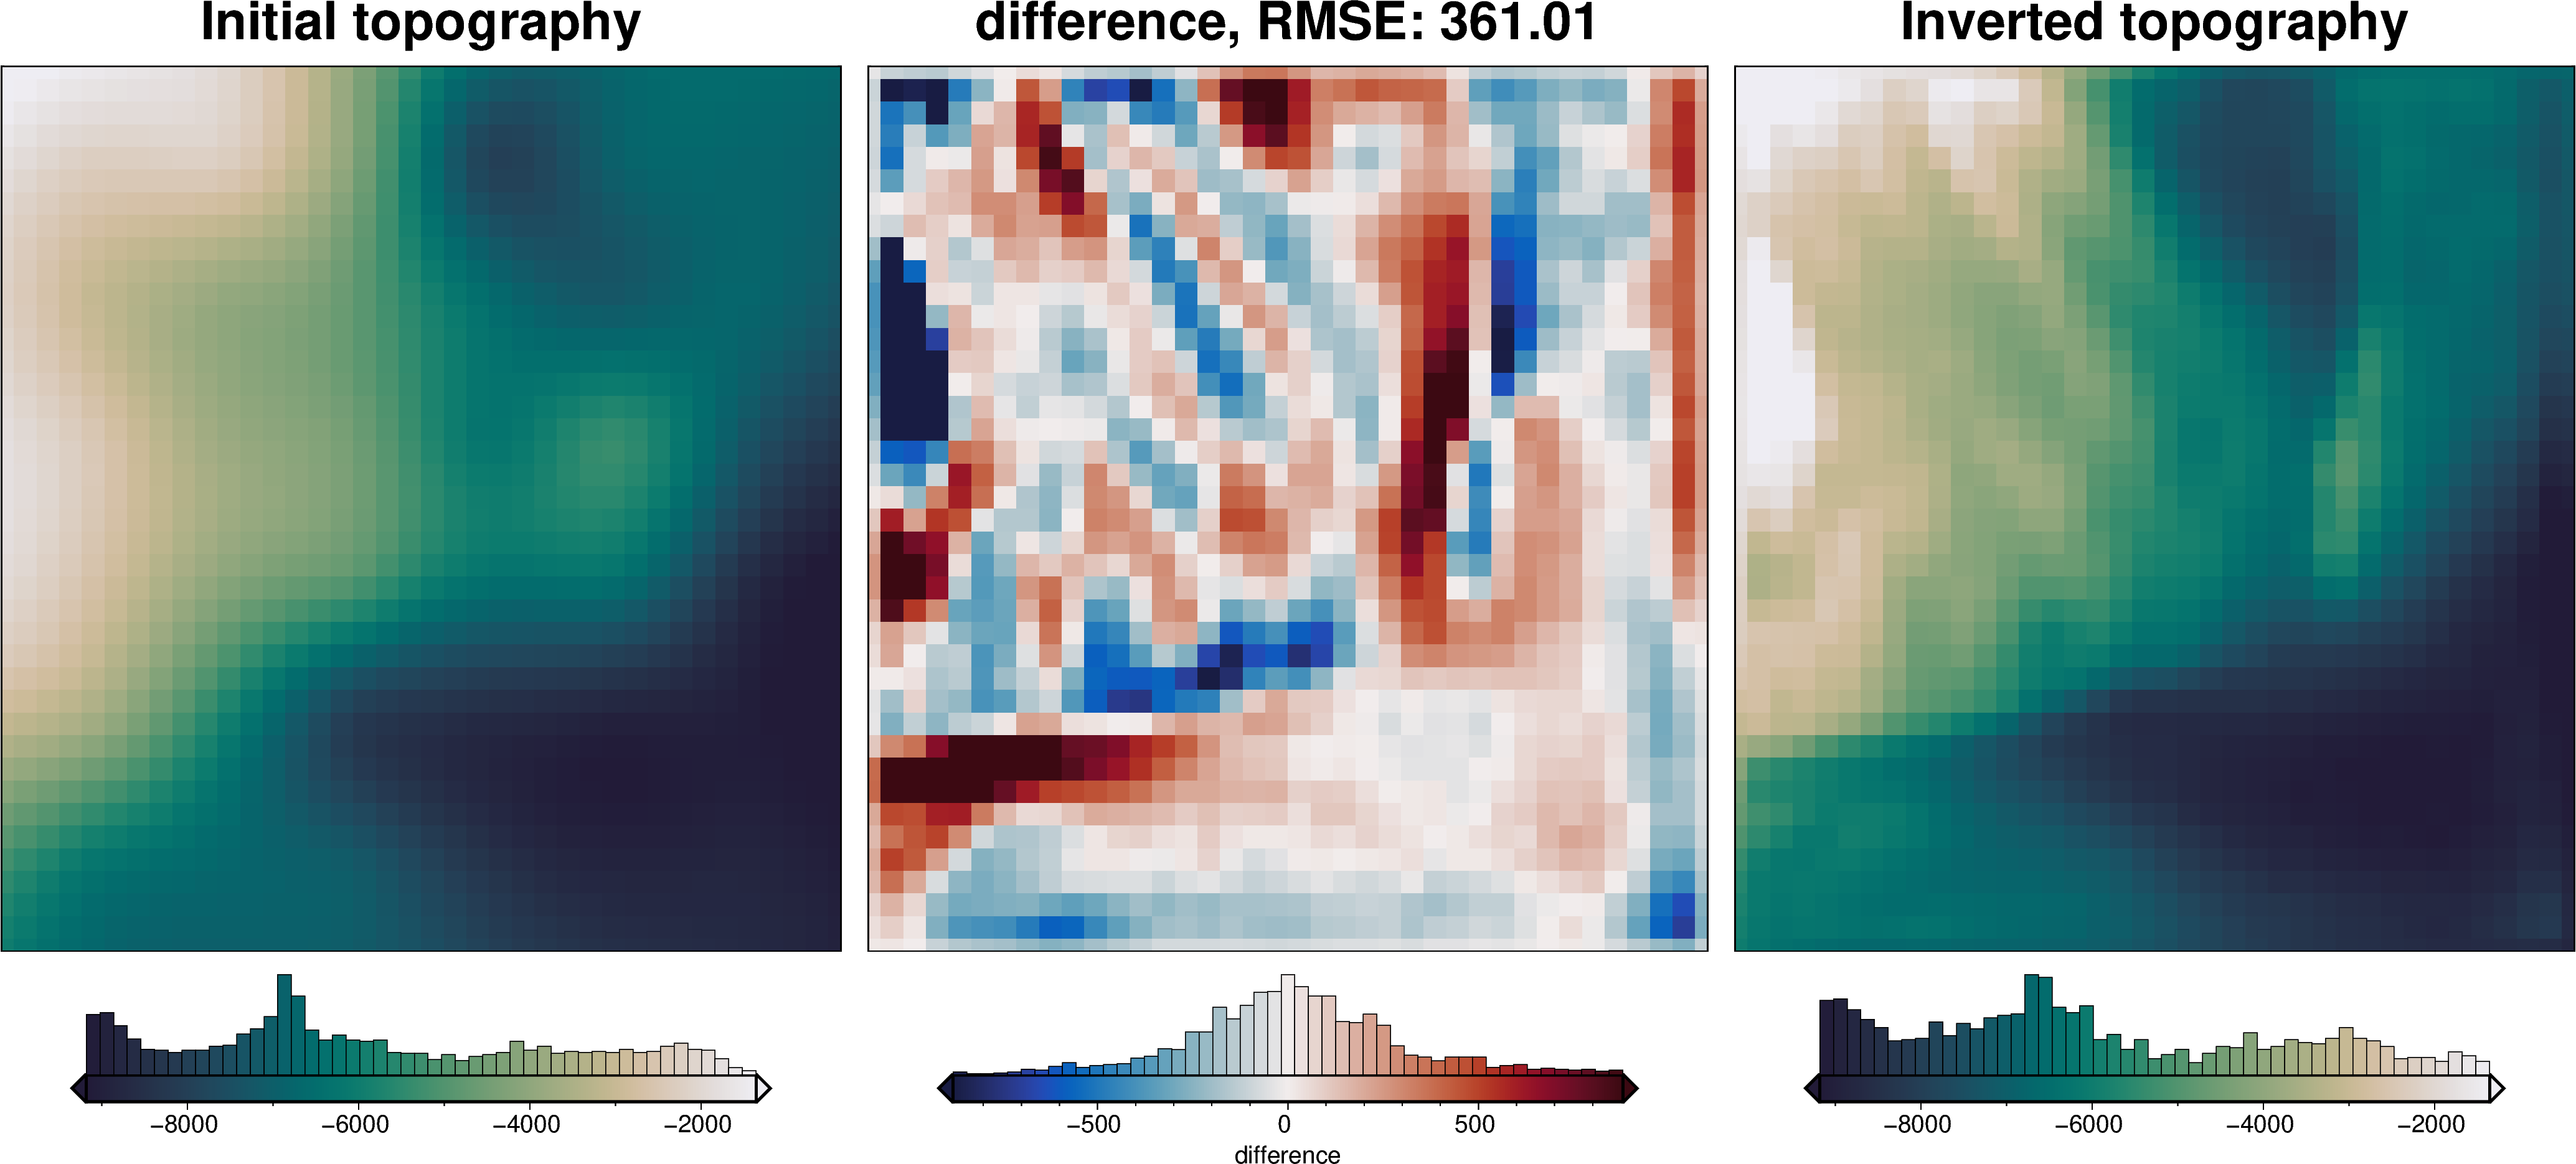

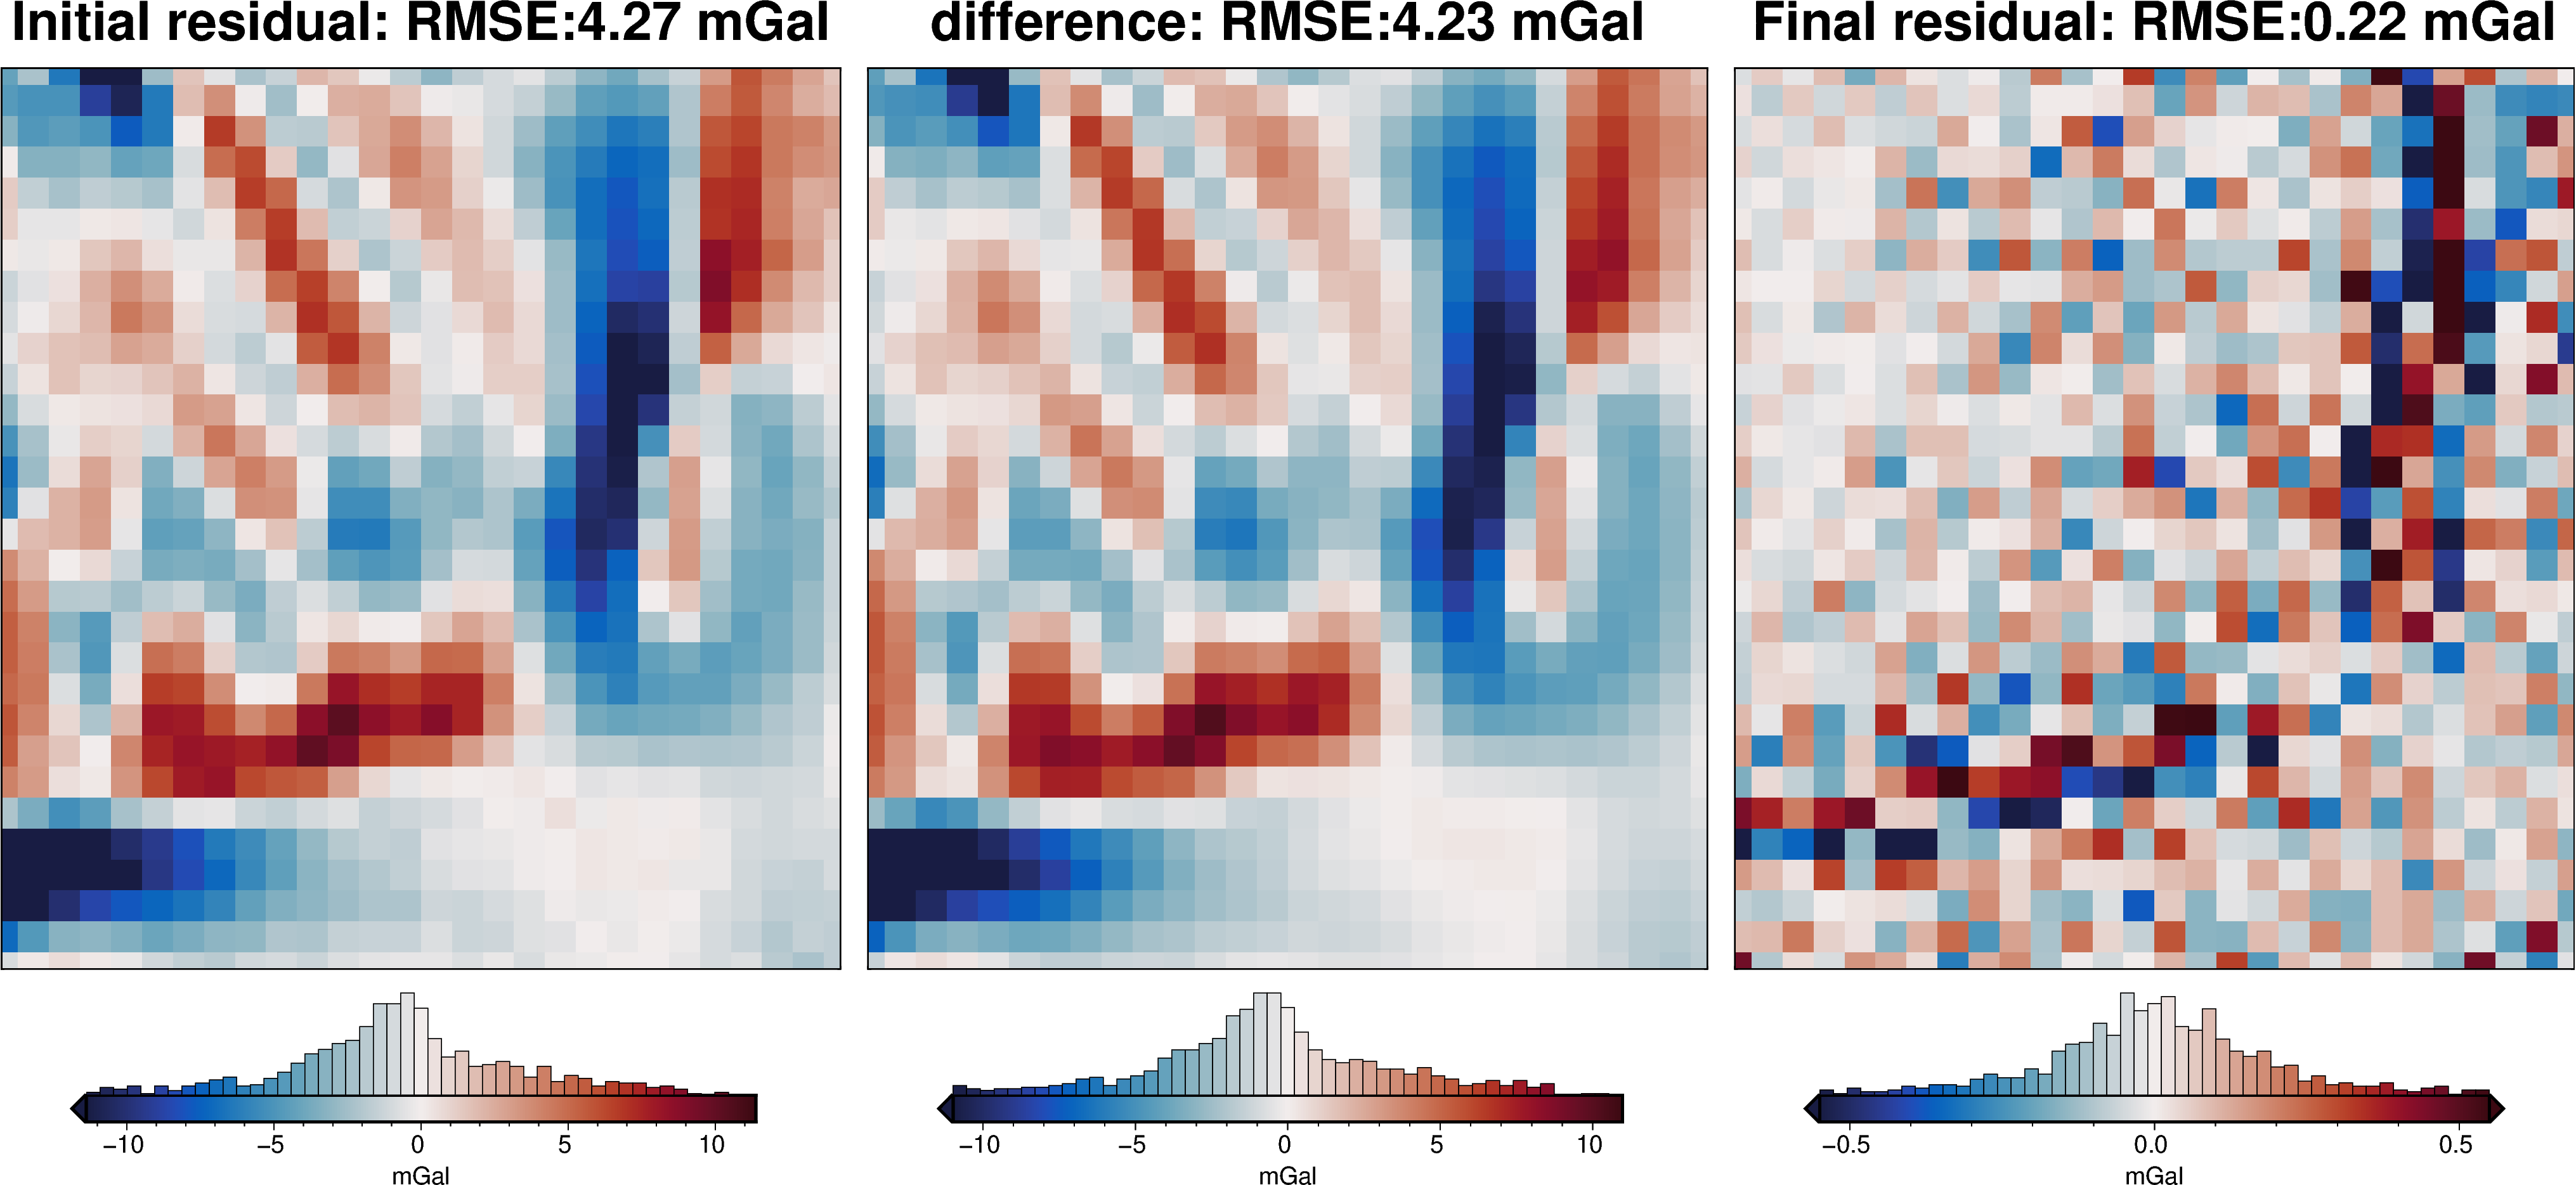

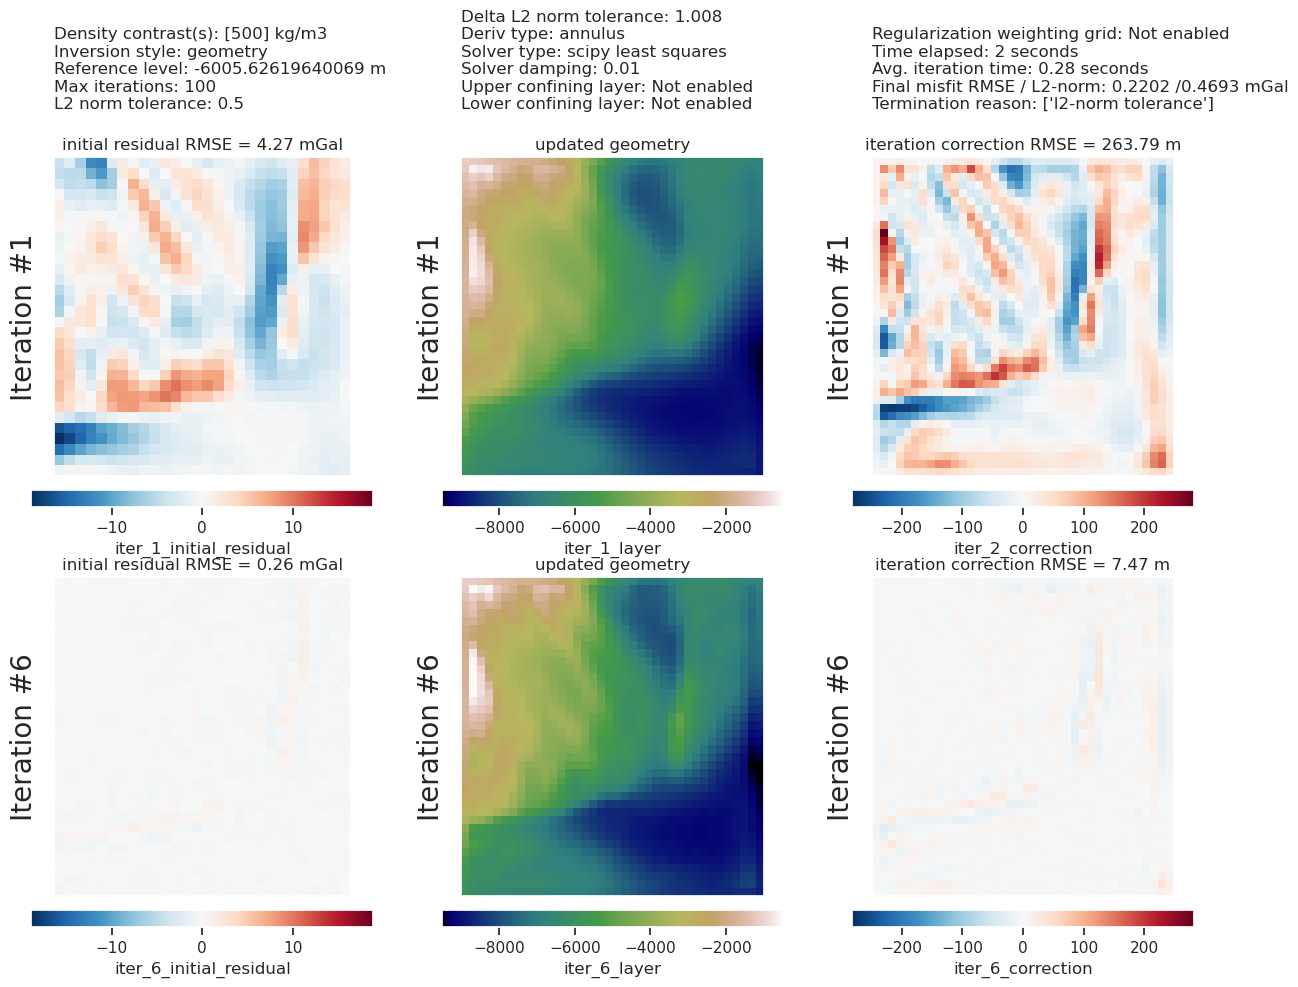

In [20]:
inv.plot_inversion_results(
    iters_to_plot=2,
)

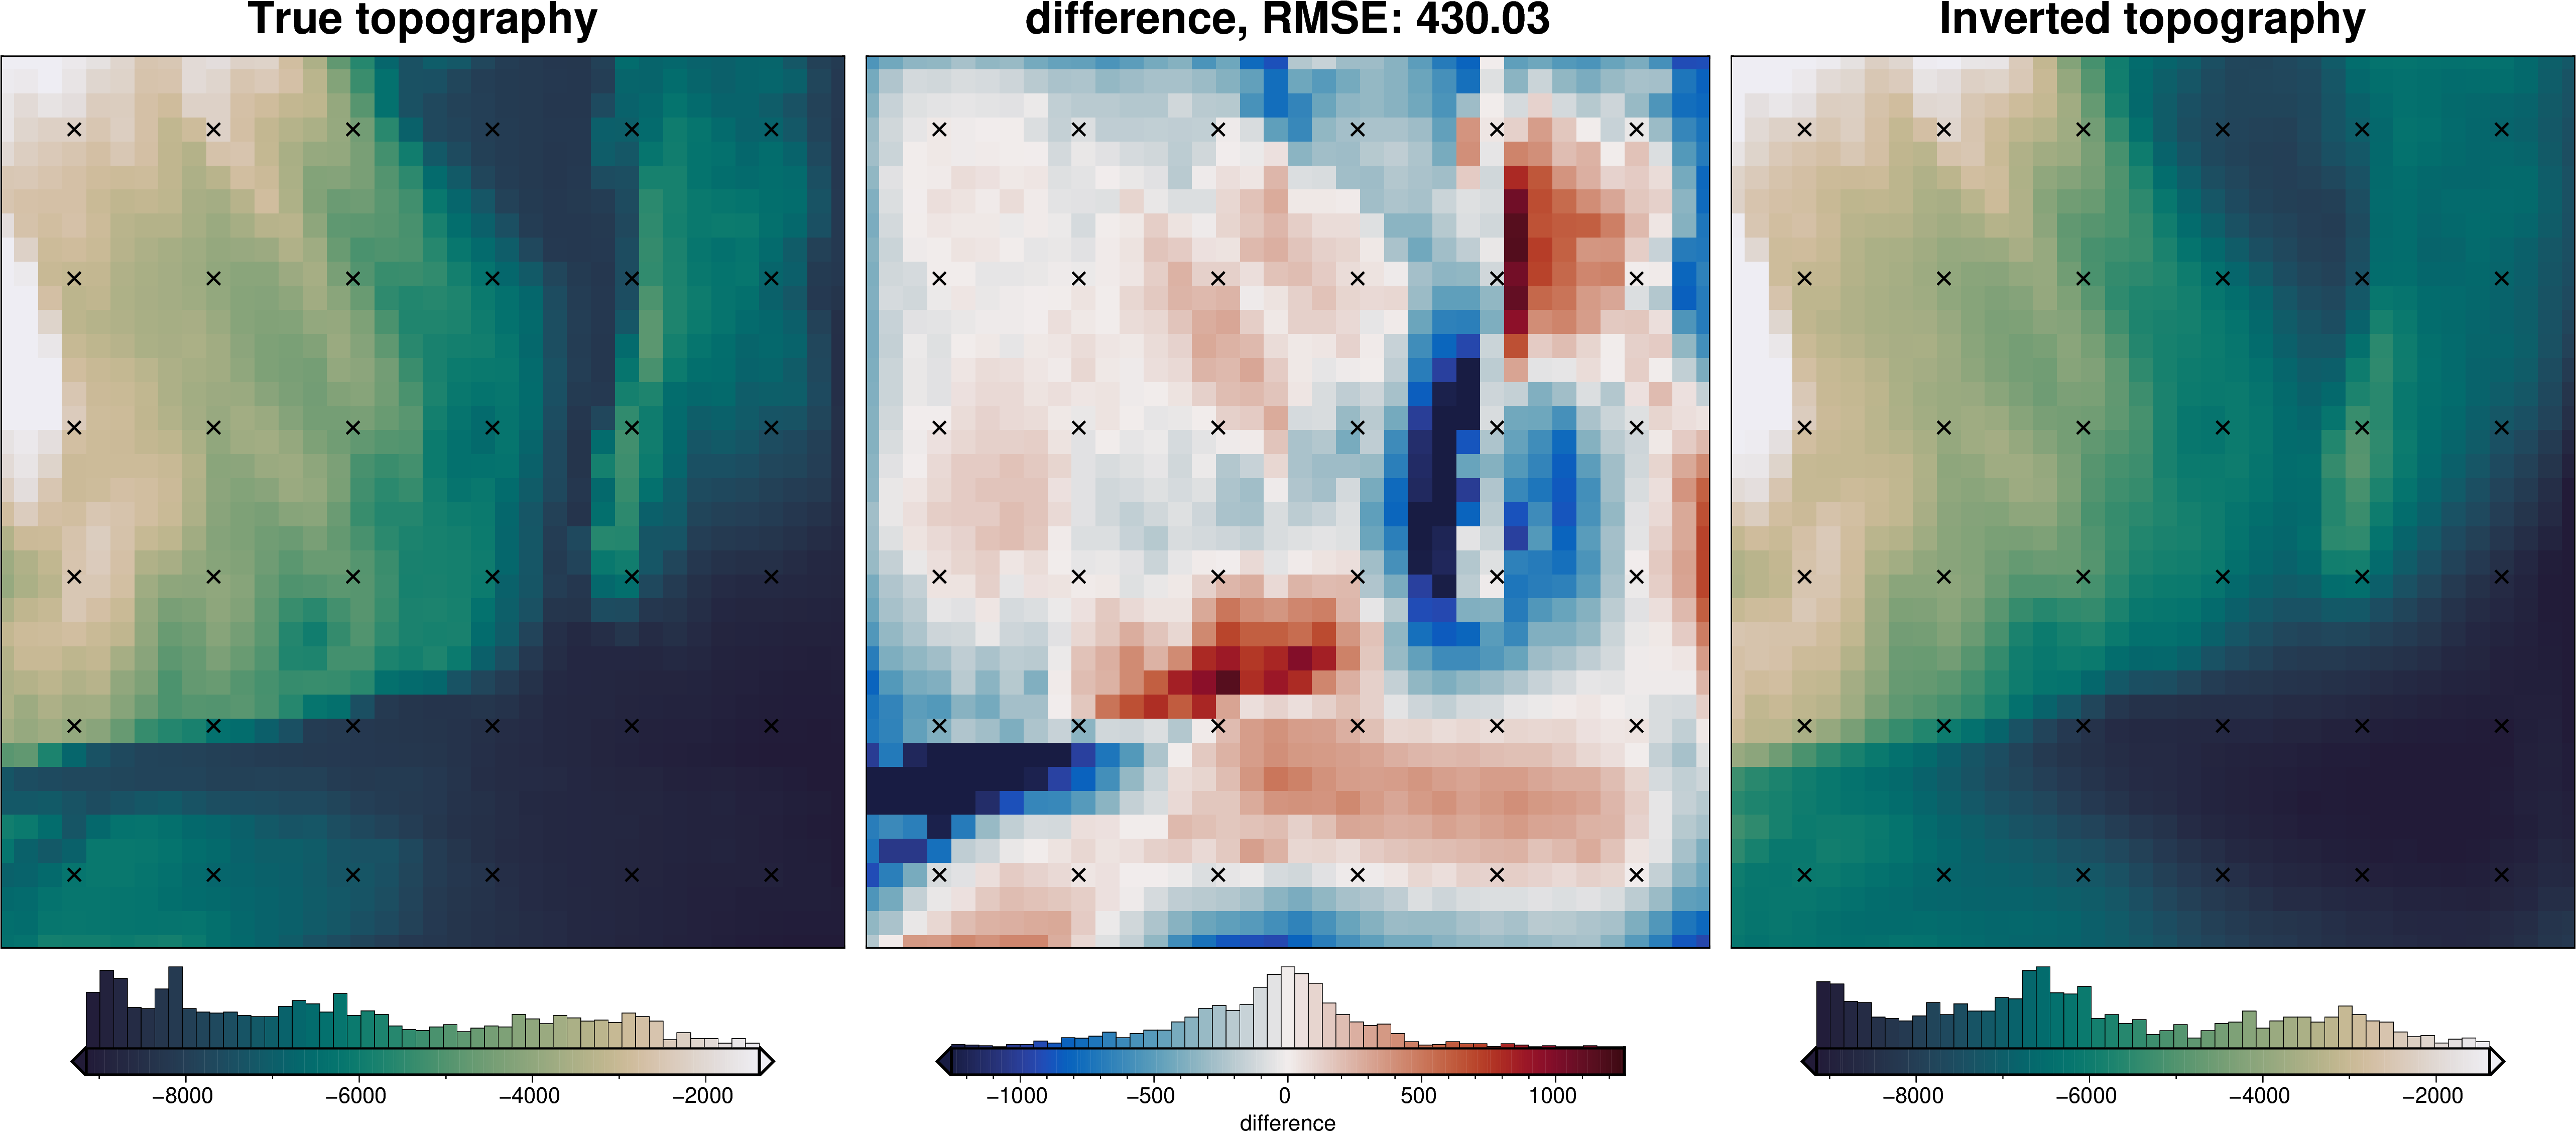

In [21]:
_ = ptk.grid_compare(
    grid.basement_topo,
    inv.model.topography,
    region=inversion_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

## Damping parameter cross validation

In [22]:
# resample data at 1/2 spacing to include test points for cross-validation
inv.data = invert4geom.add_test_points(inv.data)

In [23]:
inv.reinitialize_inversion()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.004116553513592815

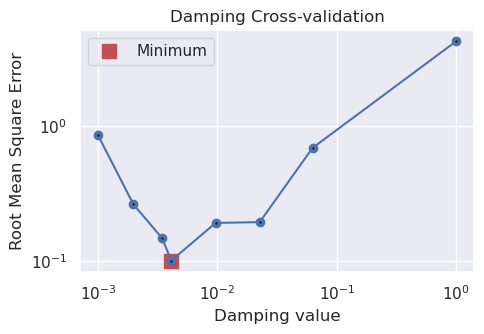

In [24]:
damping_cv_obj = inv.optimize_inversion_damping(
    damping_limits=(0.001, 1),
    n_trials=8,
    fname="../tmp/bishop_model_damping_cv",
)
inv.solver_damping

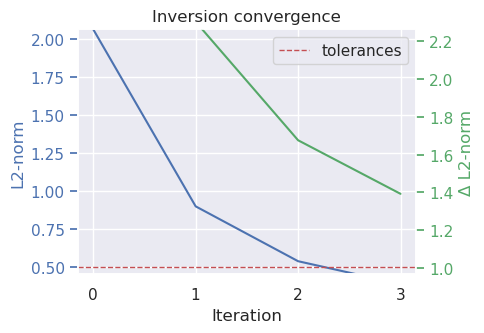

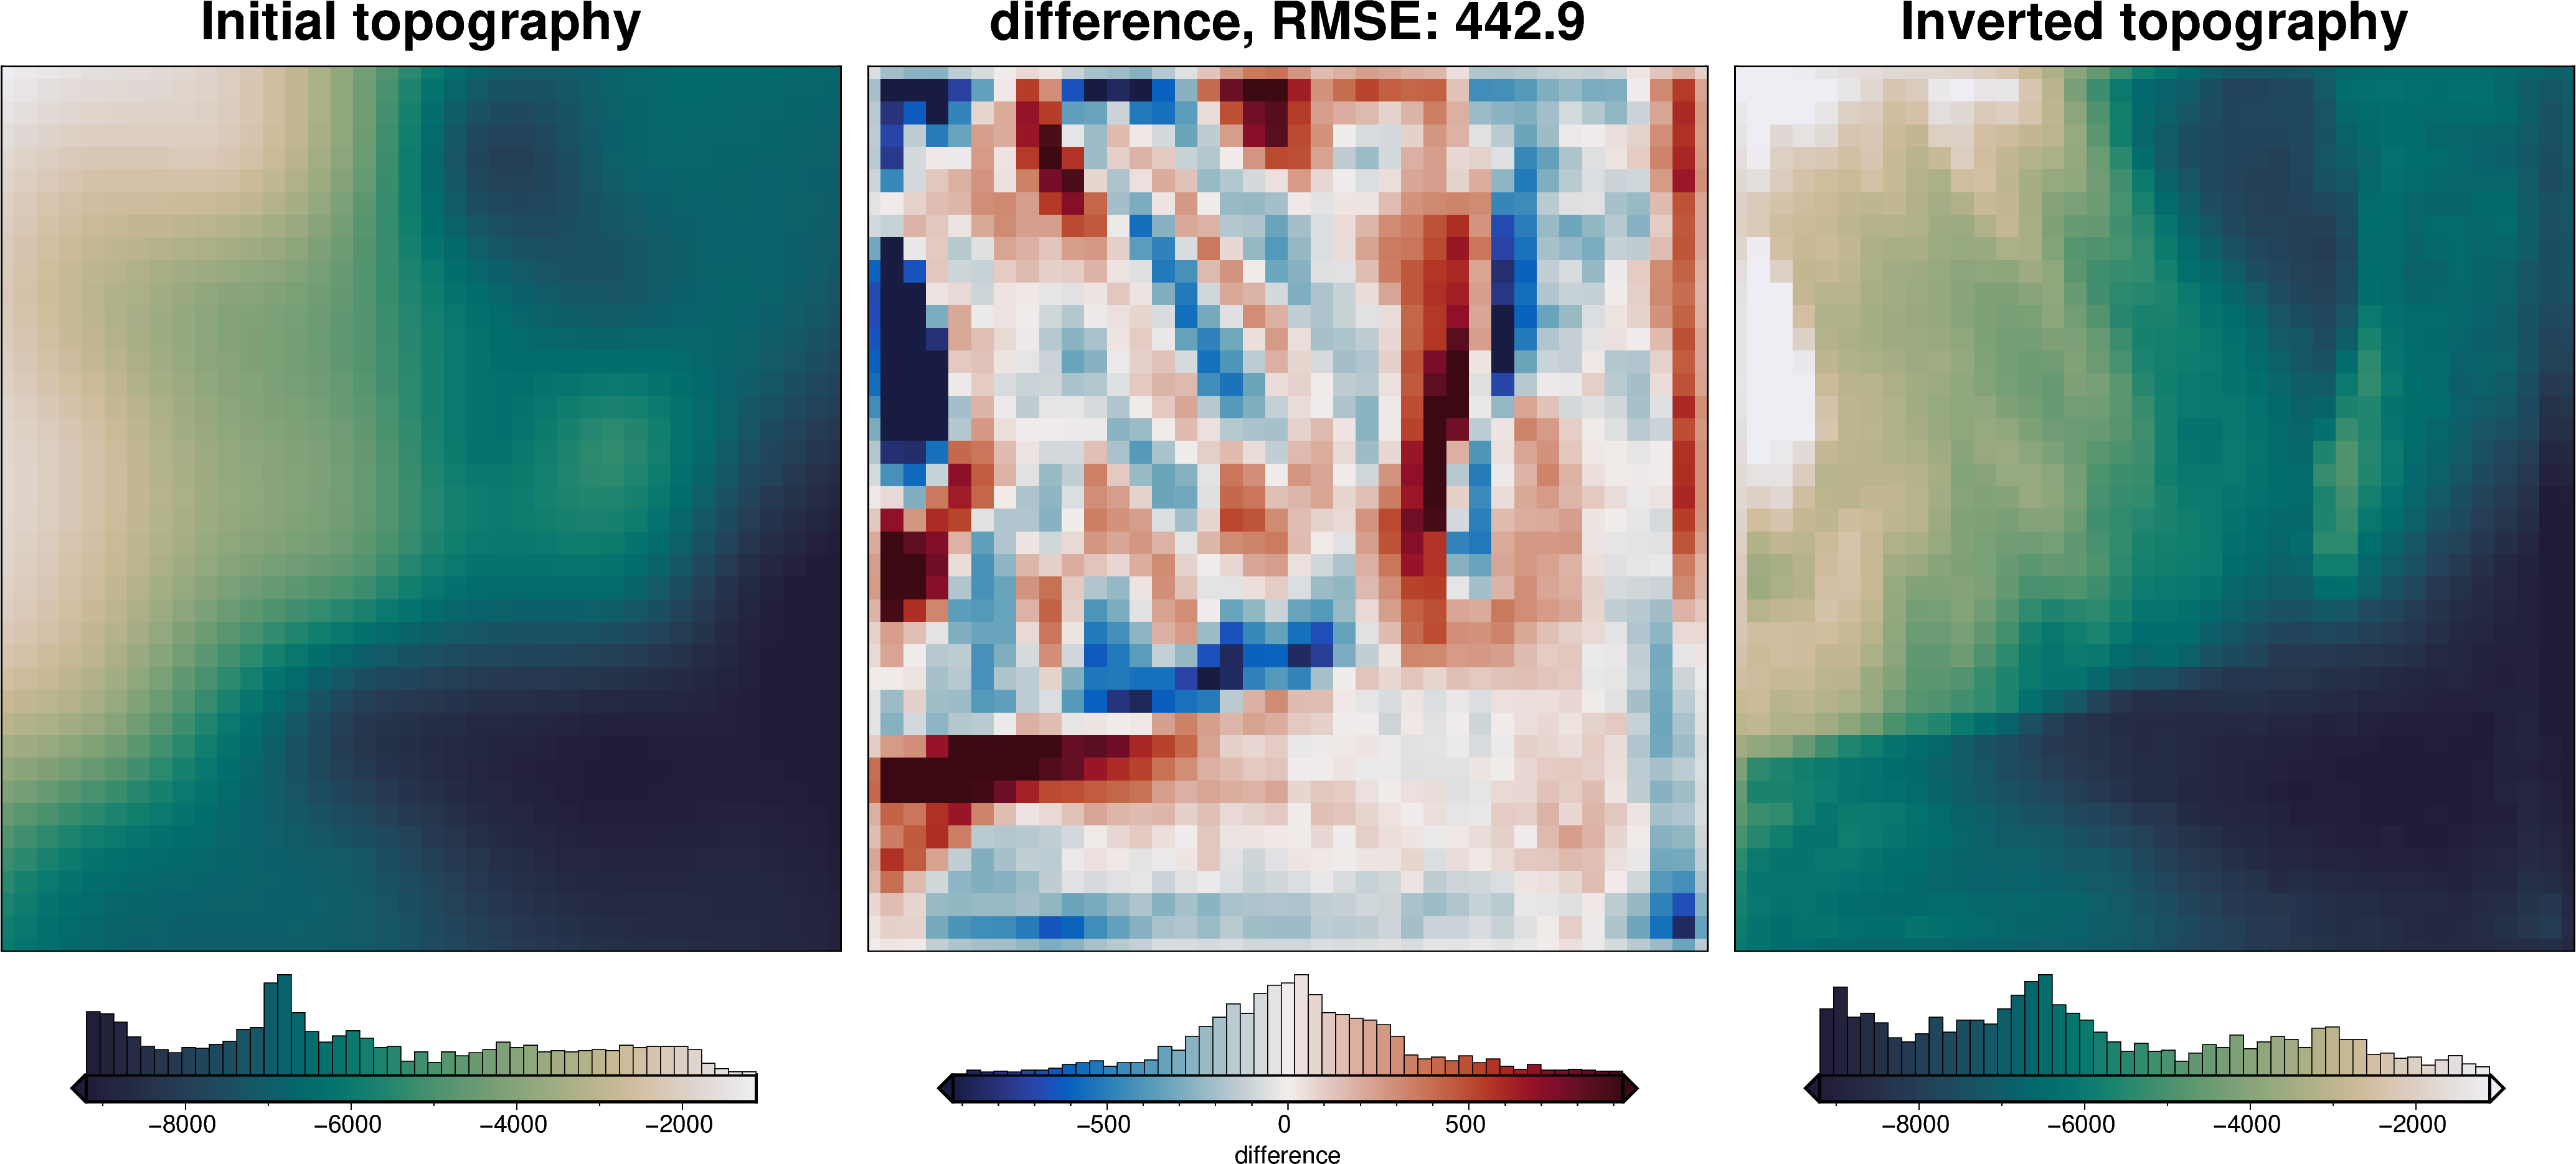

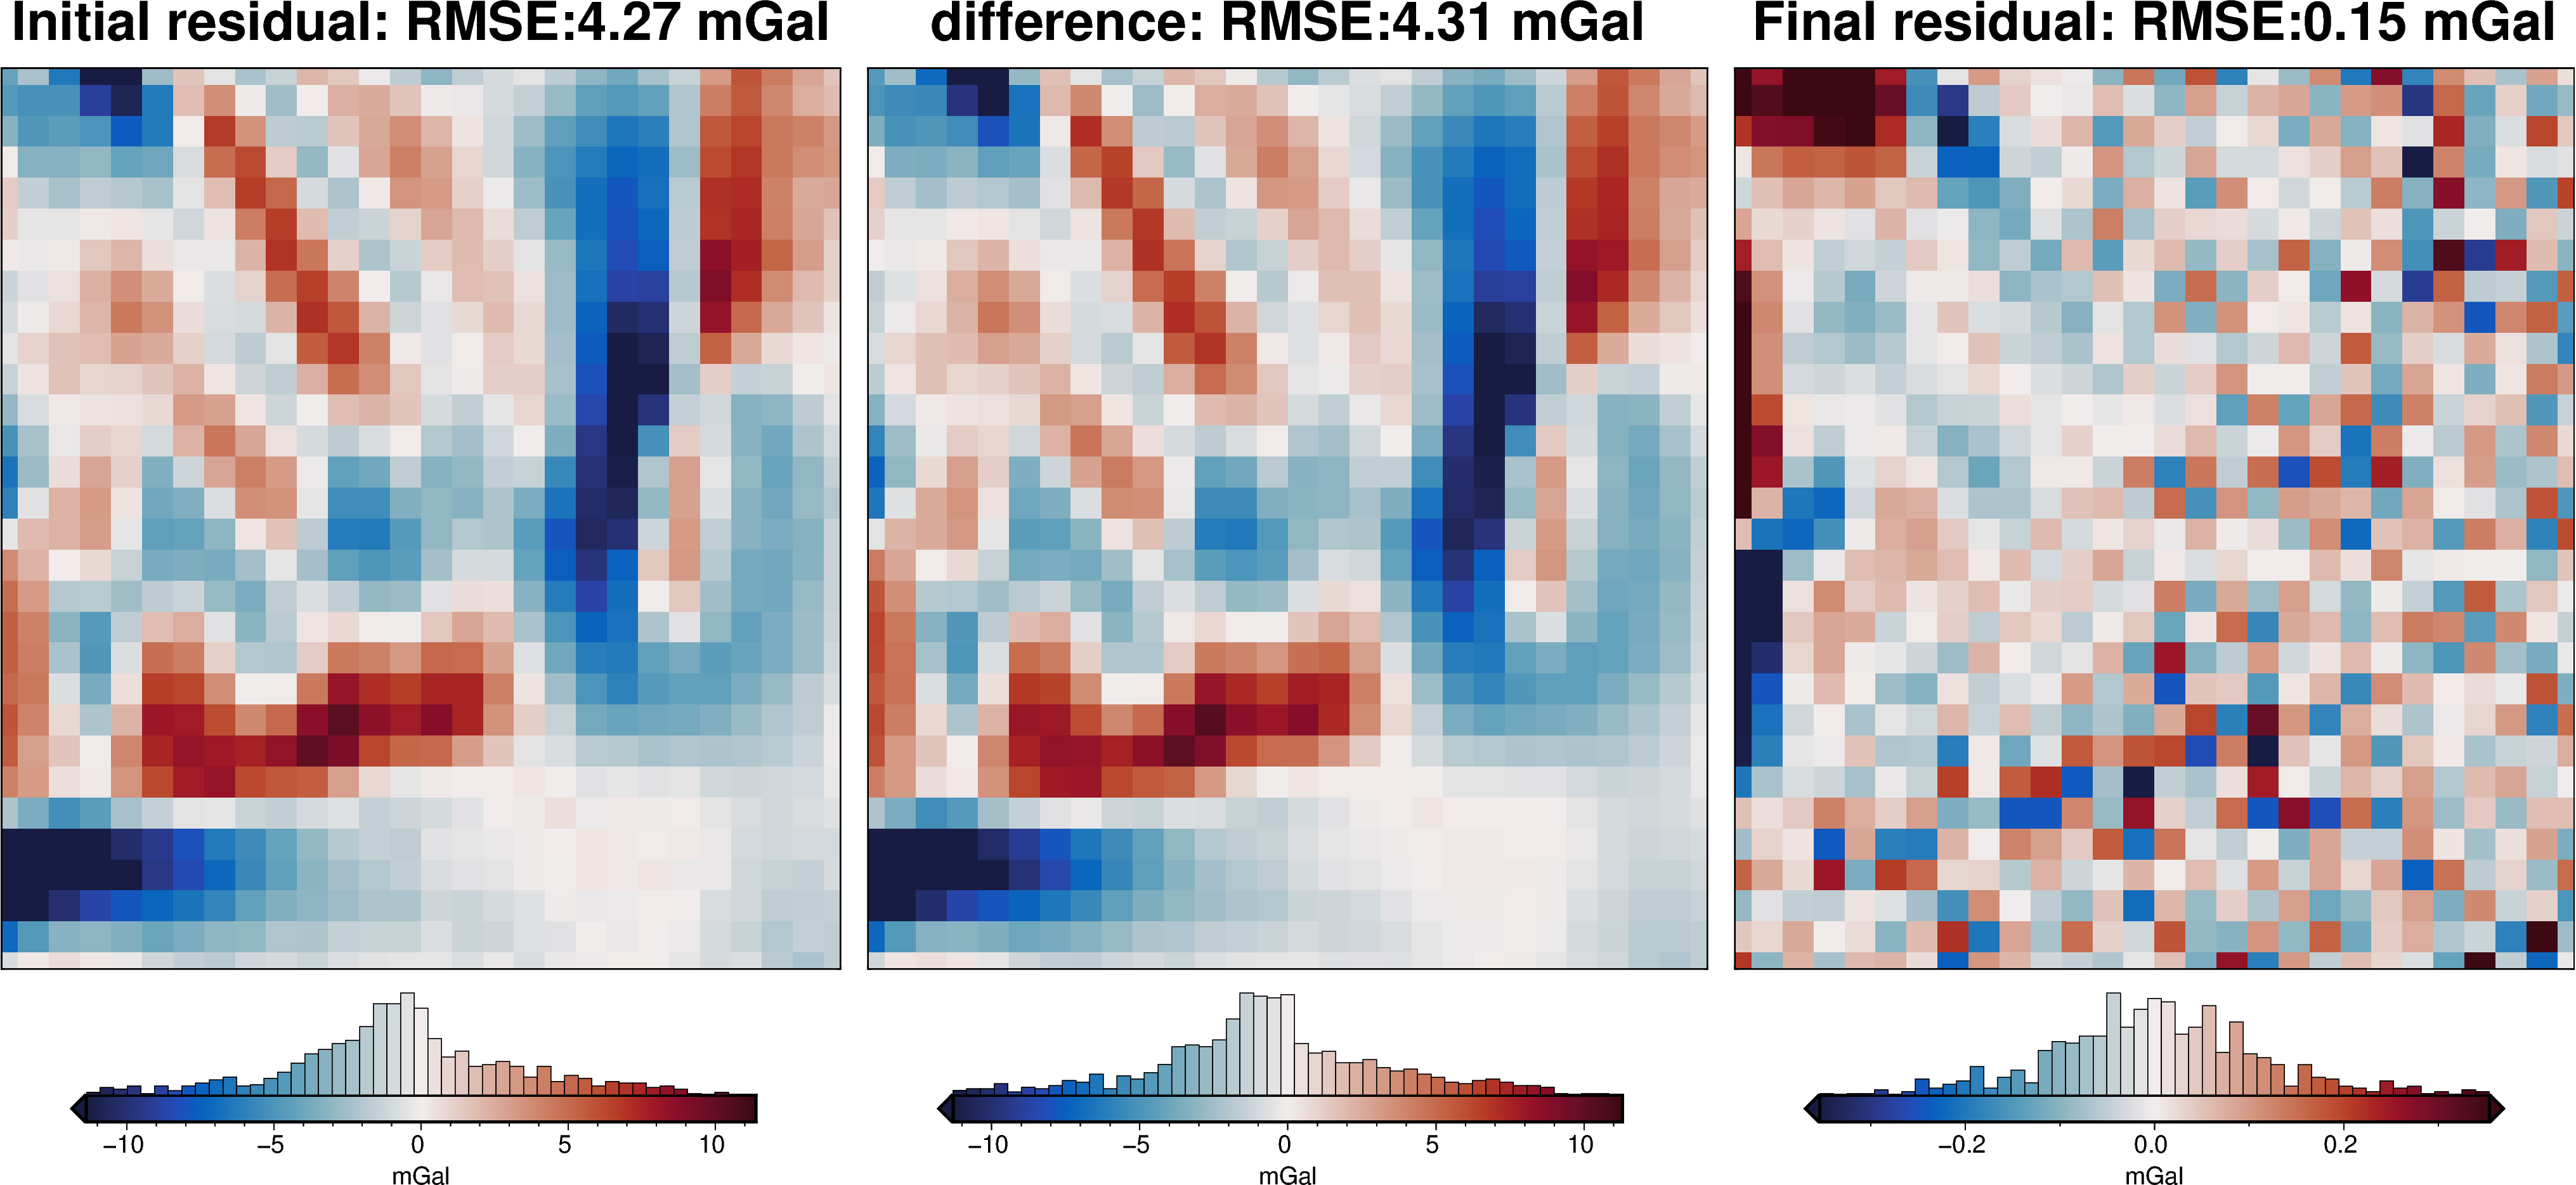

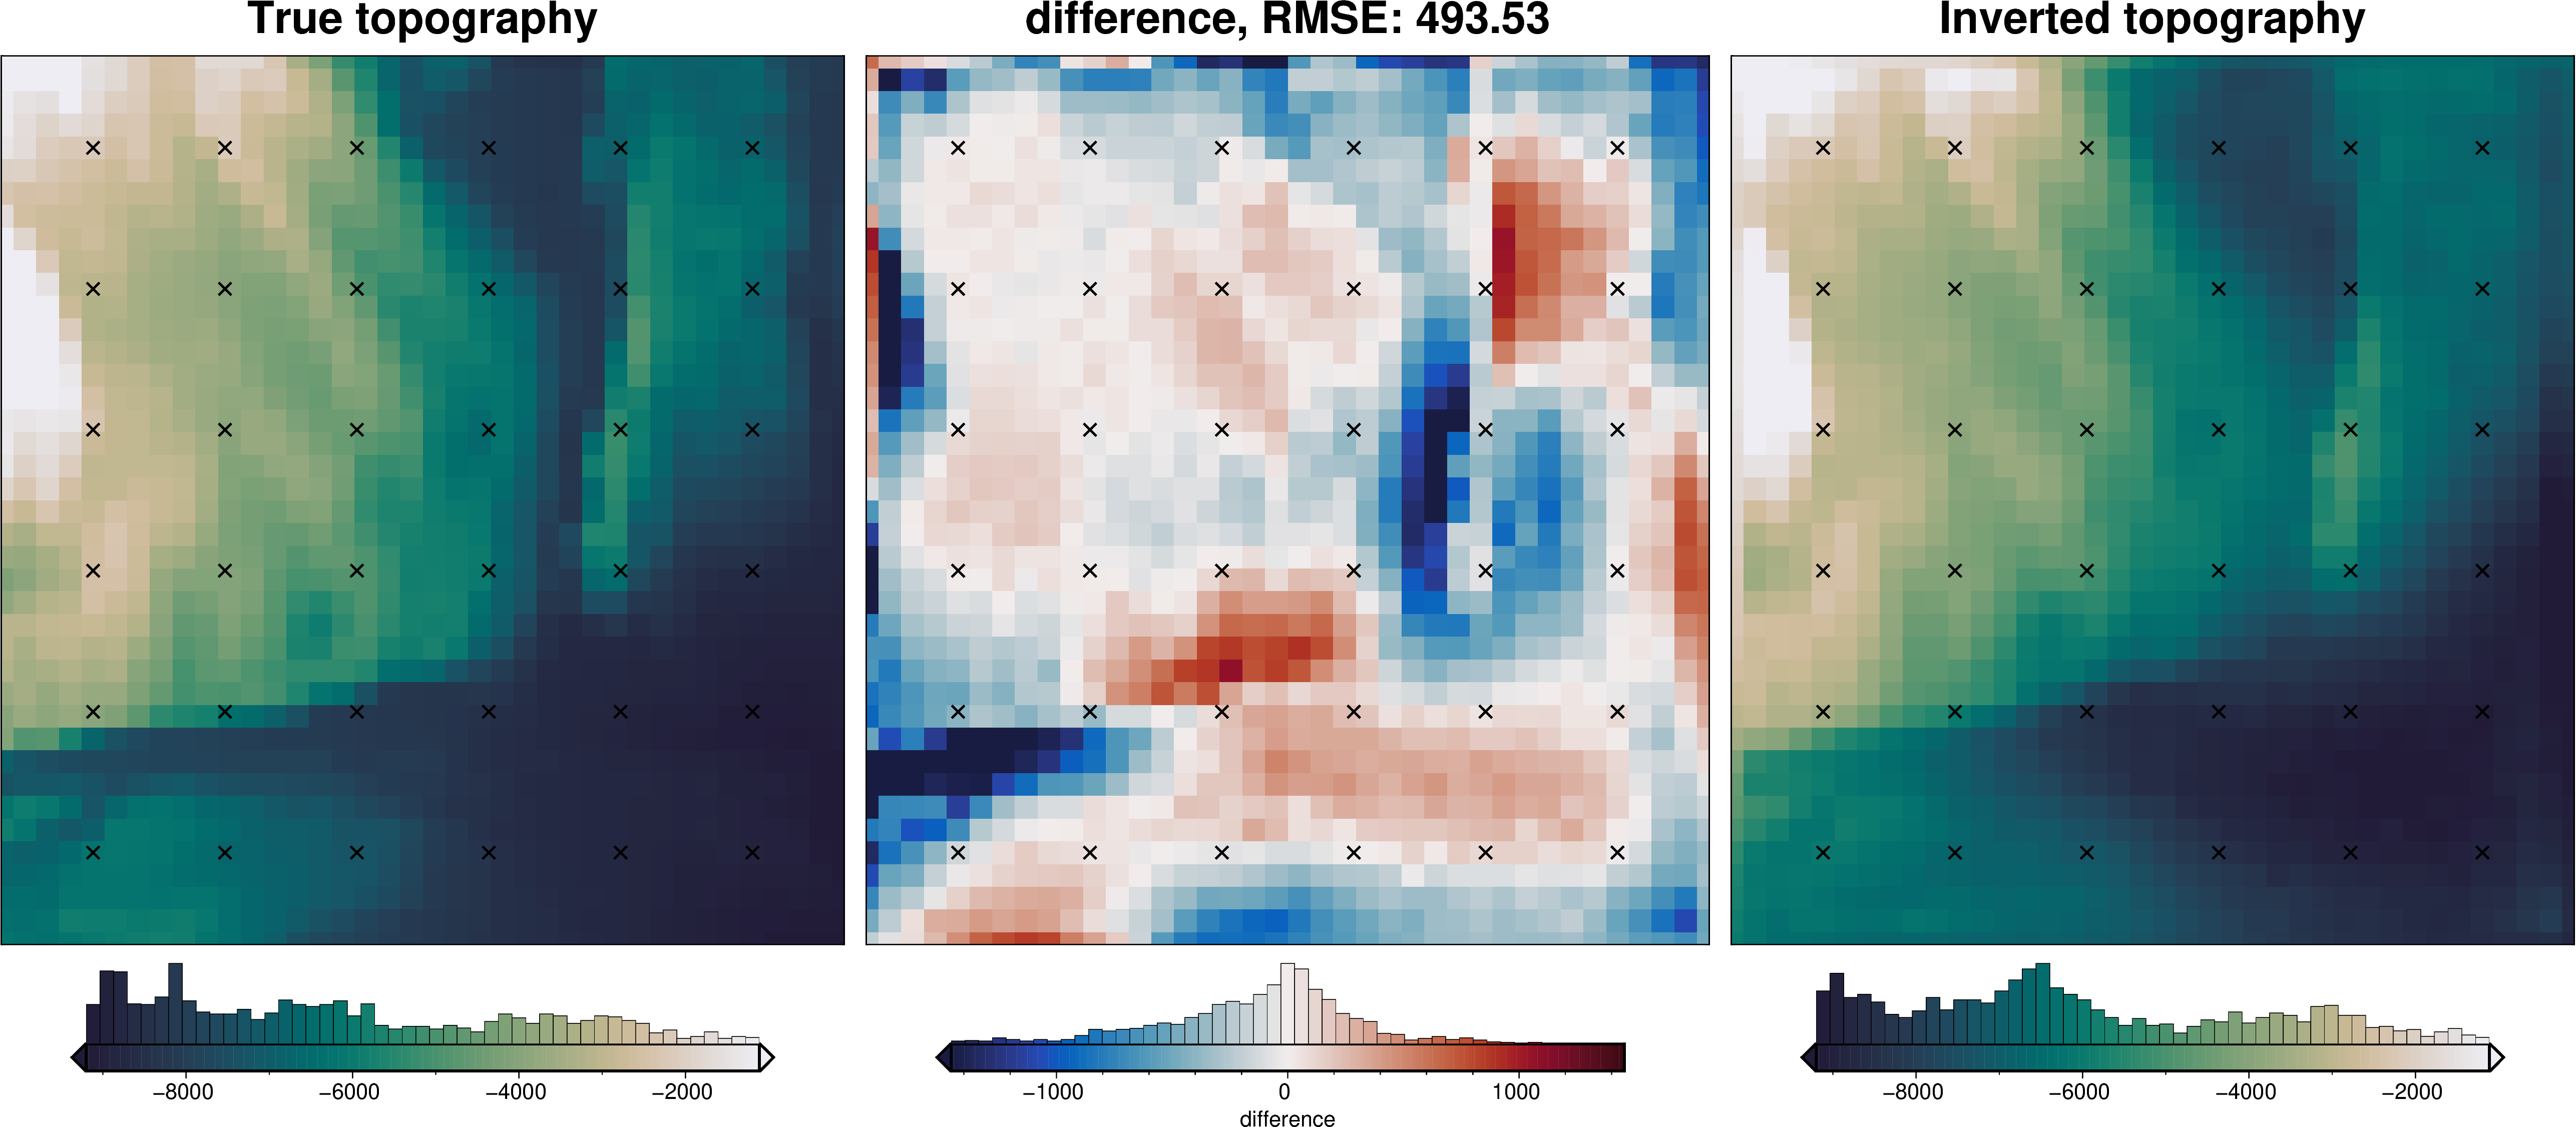

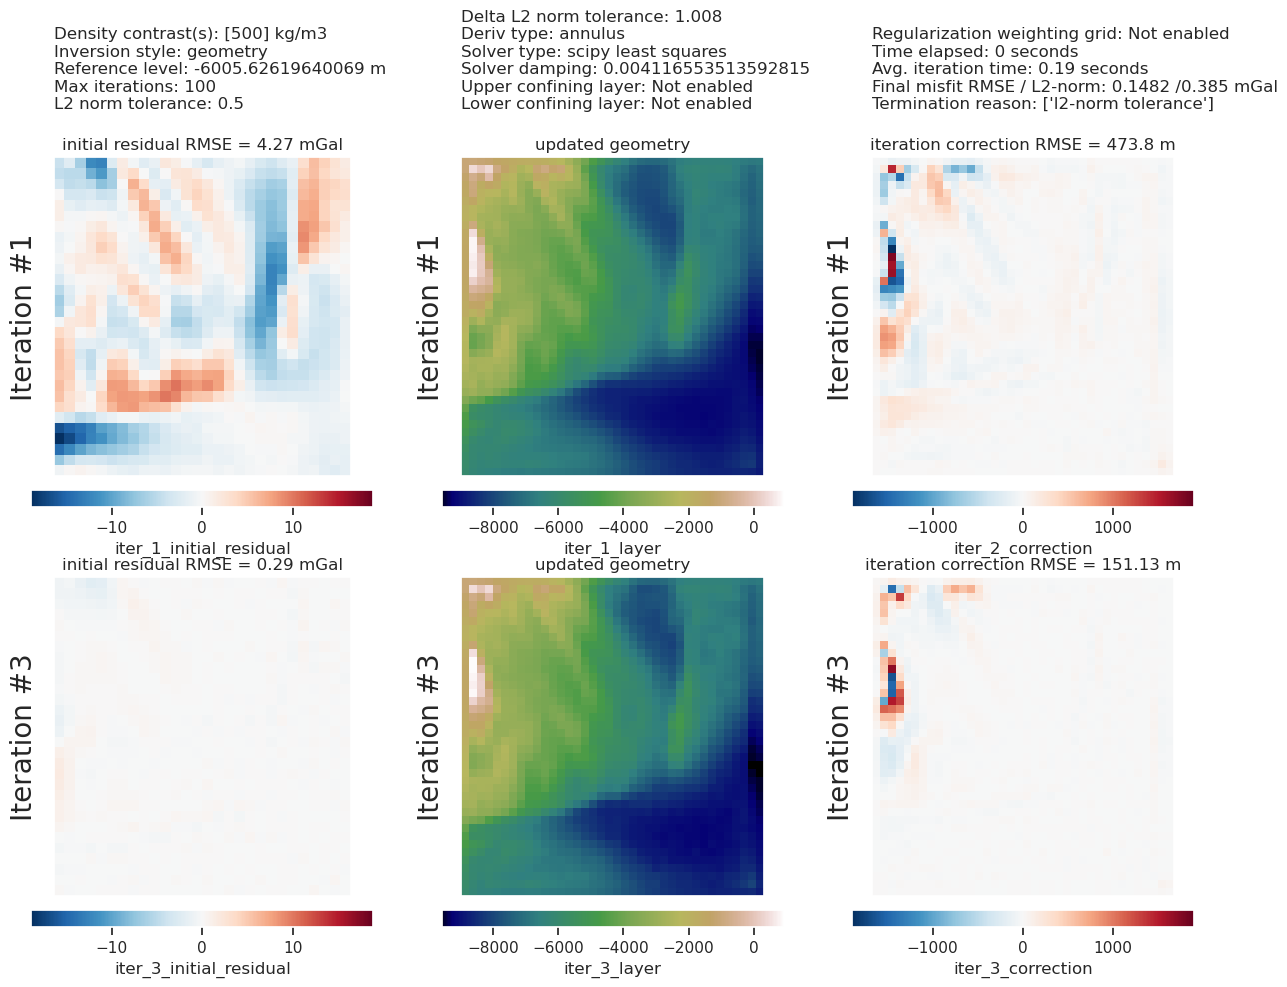

In [25]:
inv.plot_convergence()

inv.plot_inversion_results(iters_to_plot=2)

_ = ptk.grid_compare(
    grid.basement_topo,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [26]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.true_upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 130.20 m


## Density contrast / zref optimization
Since this optimization uses the inversion error at constraint points, we can't use the constraint point minimization technique to estimate the regional field since that inherently sets the inversion error at constraints to zero, invalidating the optimization scores. 

There are two options for how to get around this issue:
1) use a different regional estimation technique while finding the optimal density contrast and zref values, then use the found optimal values with the constraint point minimization regional estimation technique afterwards. 
2) separate the constraints into testing and training sets, so that only the training set is used during the regional separation, and only the testing set is used for scoring the density contrast and zref optimization. 

Well just use the 1st option below.

### Density optimization

In [27]:
# we don't need the testing points anymore
inv.data = invert4geom.remove_test_points(inv.data)

In [28]:
inv.reinitialize_inversion()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Best density_contrast value (600) is at the limit of provided values (600, 100) and thus is likely not a global minimum, expand the range of values tested to ensure the best parameter value is found.


'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


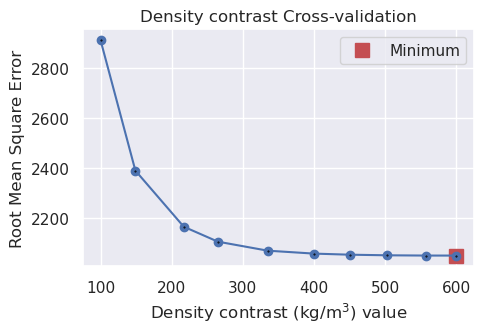

In [29]:
# run the optimization for the density contrast
density_optimization_obj = inv.optimize_inversion_zref_density_contrast(
    constraints_df=constraint_points,
    density_contrast_limits=(100, 600),
    n_trials=10,
    regional_grav_kwargs={
        "method": "constant",
        "constant": inv.data.reg.mean(),
    },
    starting_topography=starting_topography,
    plot_scores=True,
    fname="../tmp/bishop_model_density_optimization",
)

In [30]:
# The optimal value has been saved as the Model's density contrast for future inversions
print(inv.model.density_contrast)

600


### Zref optimization

In [31]:
inv.reinitialize_inversion()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


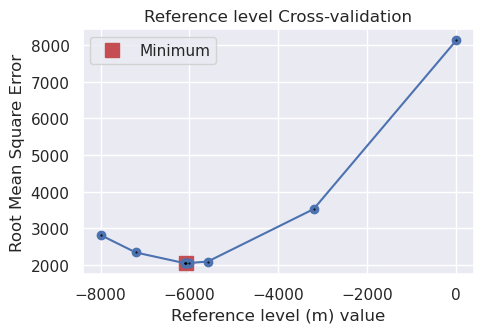

In [32]:
# run the optimization for the zref
zref_optimization_obj = inv.optimize_inversion_zref_density_contrast(
    constraints_df=constraint_points,
    zref_limits=(-8e3, 0),
    n_trials=10,
    regional_grav_kwargs={
        "method": "constant",
        "constant": inv.data.reg.mean(),
    },
    starting_topography=starting_topography,
    plot_scores=True,
    fname="../tmp/bishop_model_zref_optimization",
)

In [33]:
# The optimal value has been saved as the model's density contrast for future inversions
print(inv.model.zref)

-6086.969583903166


## Redo regional separation and inversion with optimal values

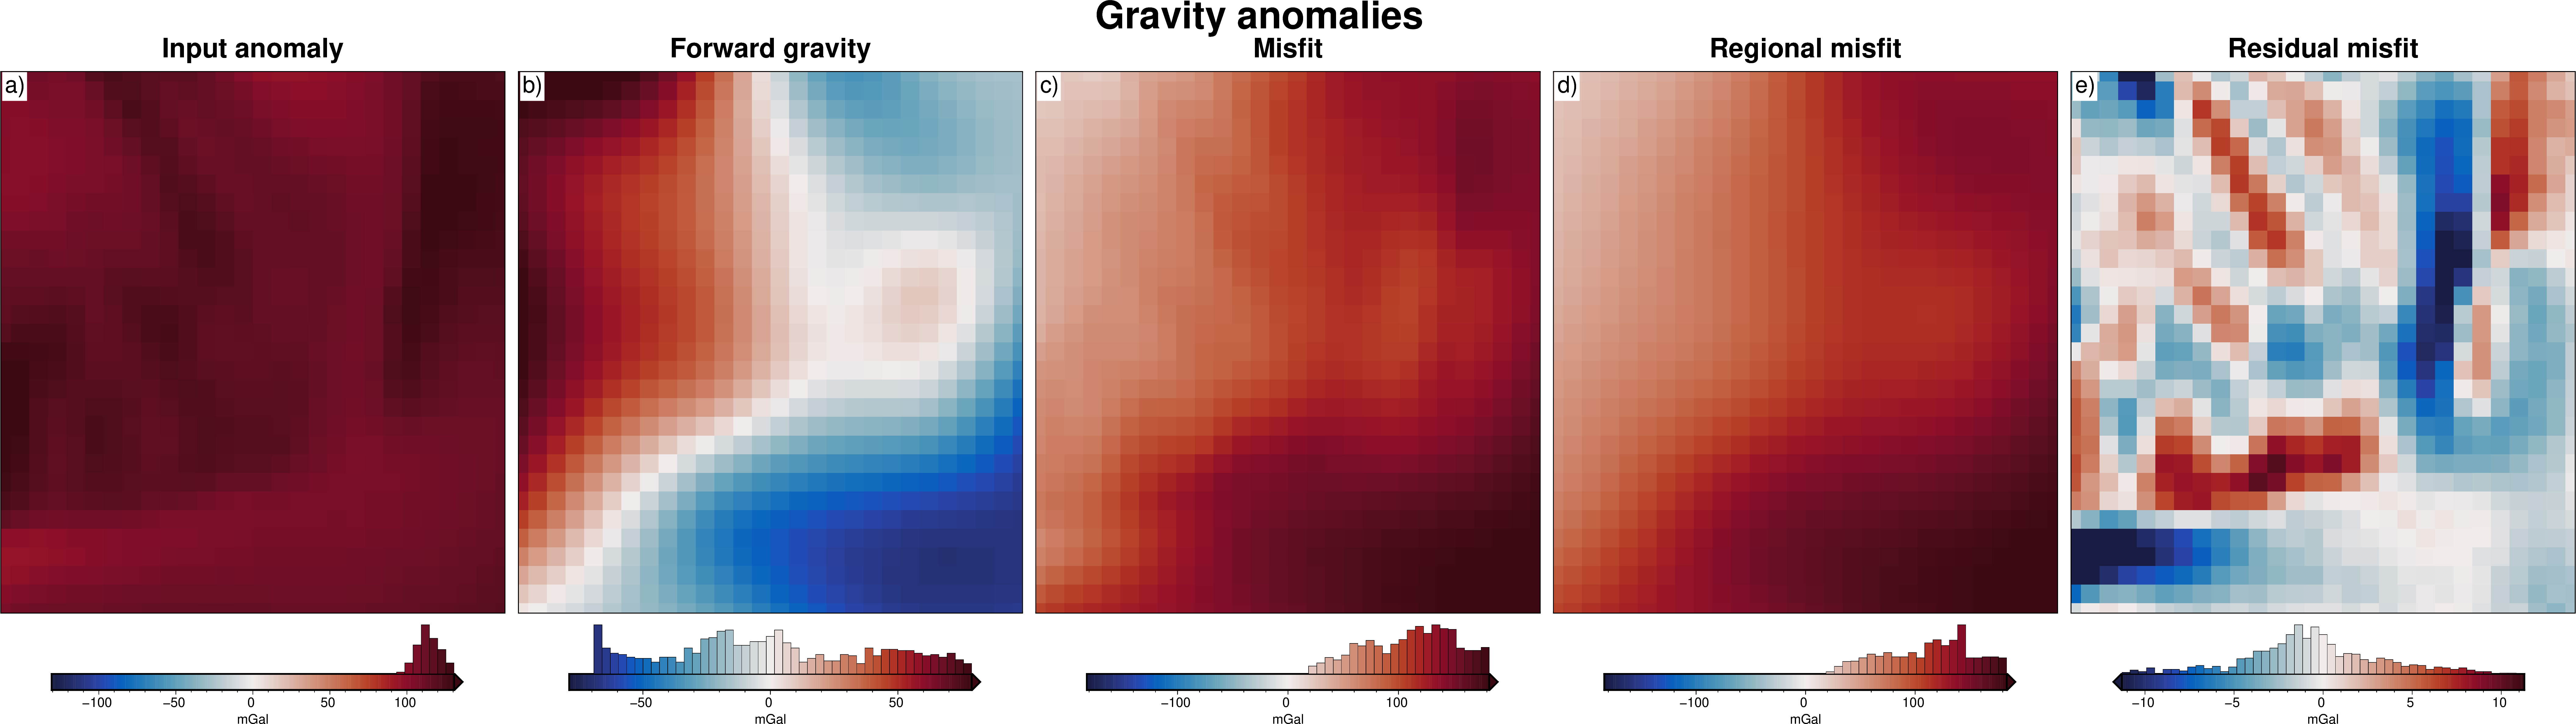

In [34]:
# recreate model with optimal zref and density contrast
model = invert4geom.create_model(
    zref=inv.model.zref,
    density_contrast=inv.model.density_contrast,
    topography=starting_topography,
)

# calculate forward gravity of starting prism layer
grav_data.inv.forward_gravity(model)

# calculate regional gravity
grav_data.inv.regional_separation(
    **regional_grav_kwargs,
)

grav_data.inv.plot_anomalies()

In [35]:
# setup the inversion
optimal_inv = invert4geom.Inversion(
    grav_data,
    model,
    solver_damping=inv.solver_damping,
    # set stopping criteria
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.008,
)
optimal_inv.solver_damping, optimal_inv.model.zref, optimal_inv.model.density_contrast

(0.004116553513592815, -6086.969583903166, 600)

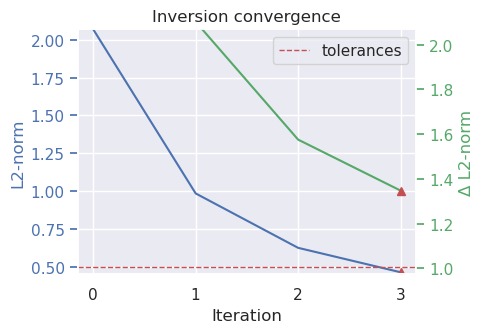

In [36]:
# run the inversion
optimal_inv.invert(
    plot_dynamic_convergence=True,
    results_fname="../tmp/bishop_model_optimal",
)

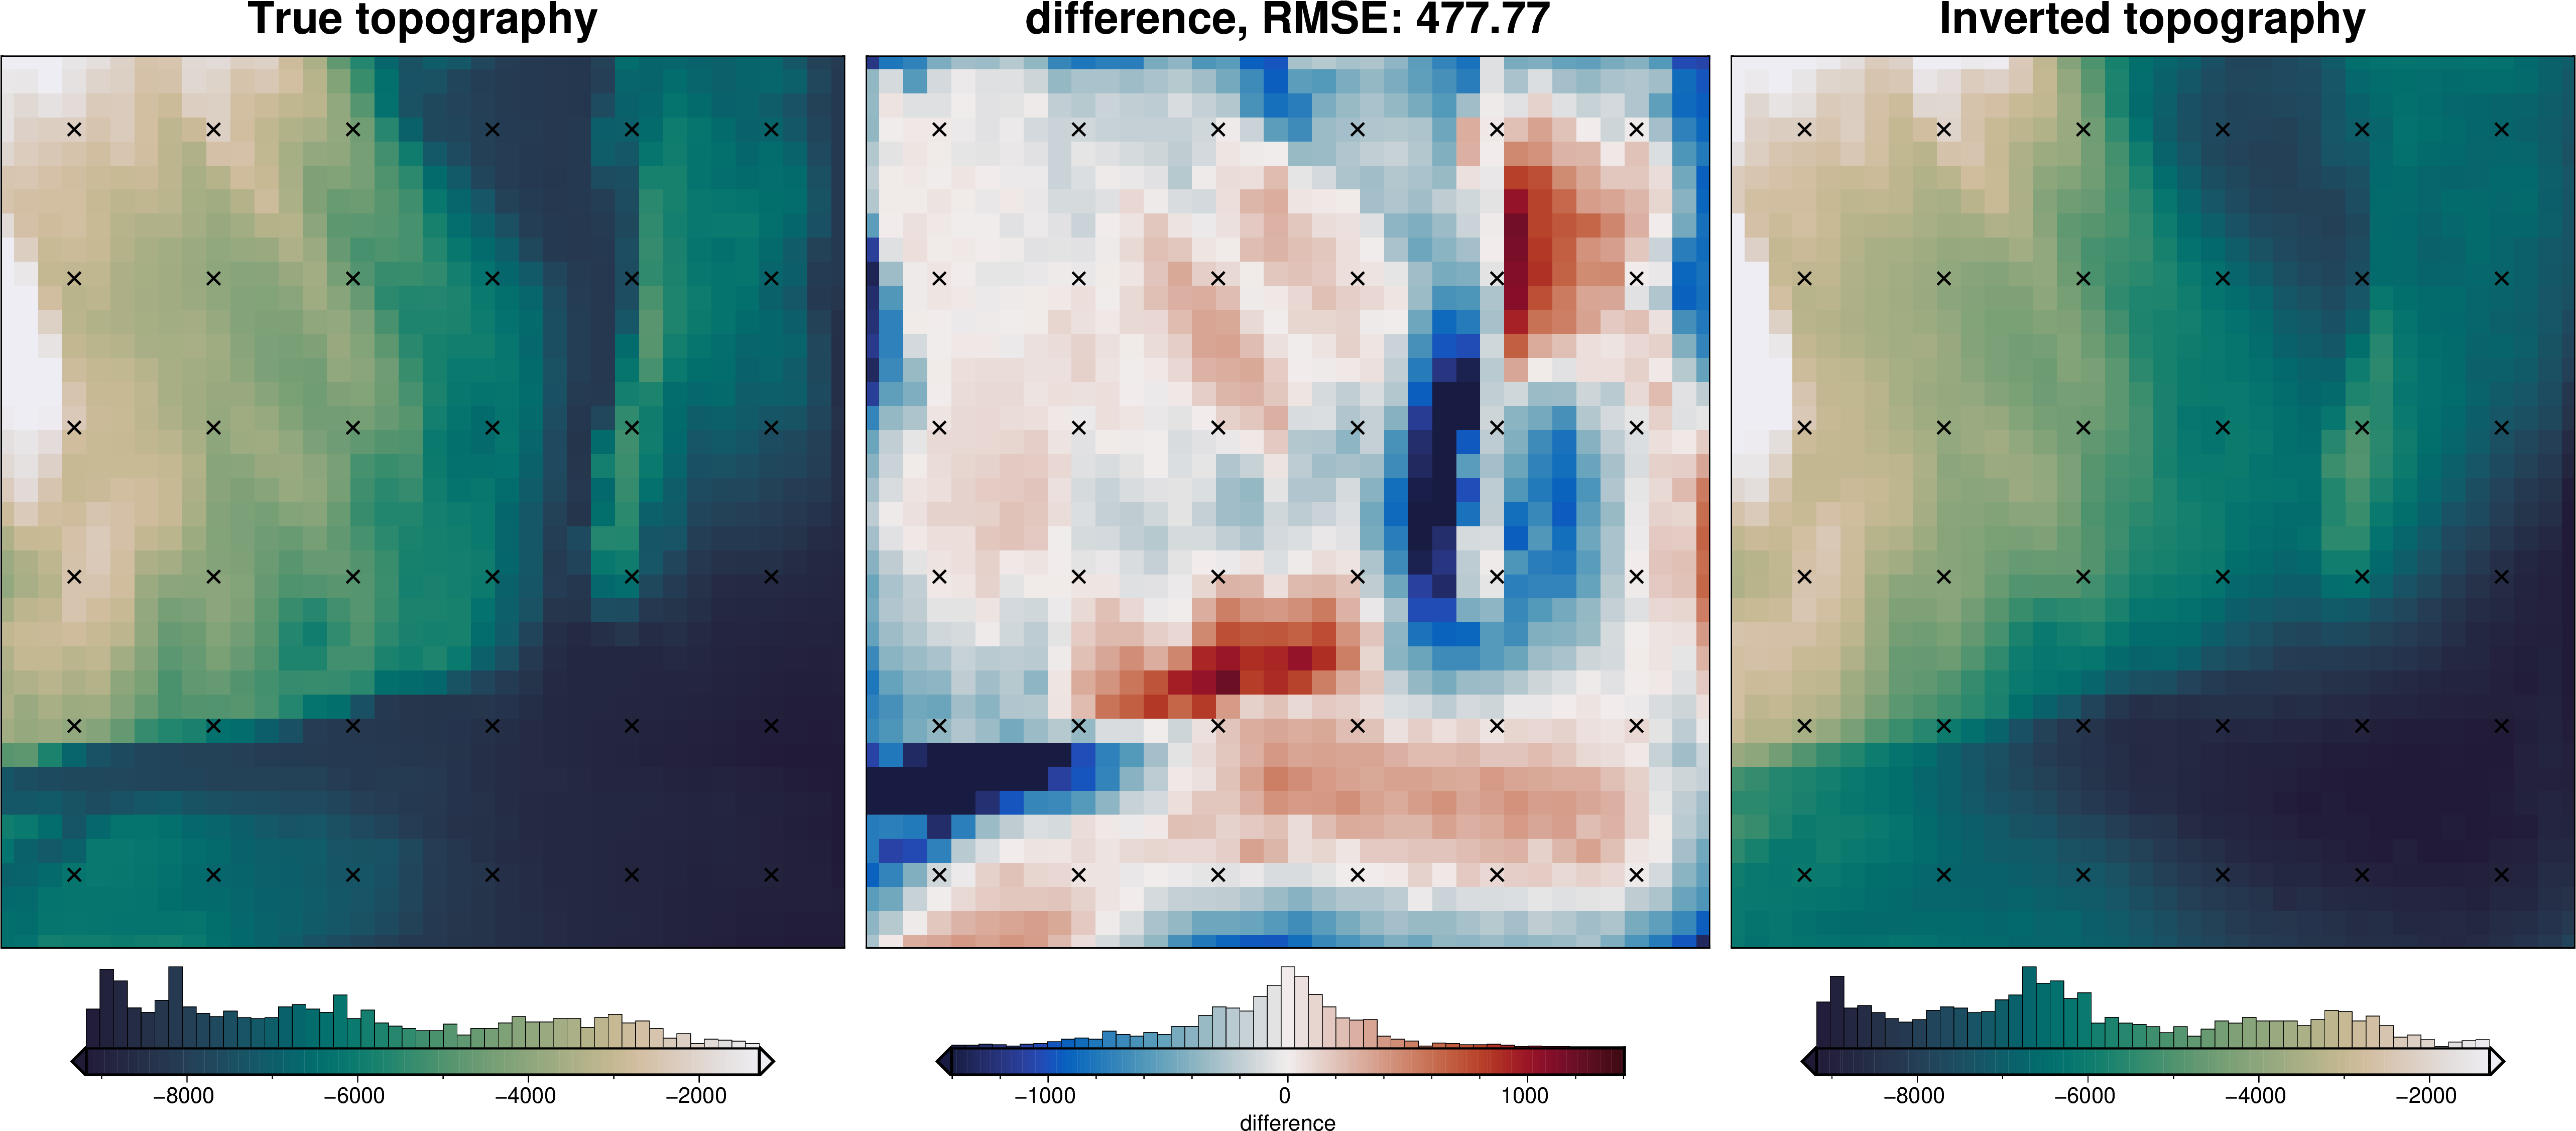

In [37]:
_ = ptk.grid_compare(
    grid.basement_topo,
    optimal_inv.model.topography,
    region=inversion_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [38]:
# sample the inverted topography at the constraint points
constraint_points = ptk.sample_grids(
    constraint_points,
    optimal_inv.model.topography,
    "inverted_topography",
)

rmse = ptk.rmse(constraint_points.true_upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 121.59 m


## Absolute value of inversion error

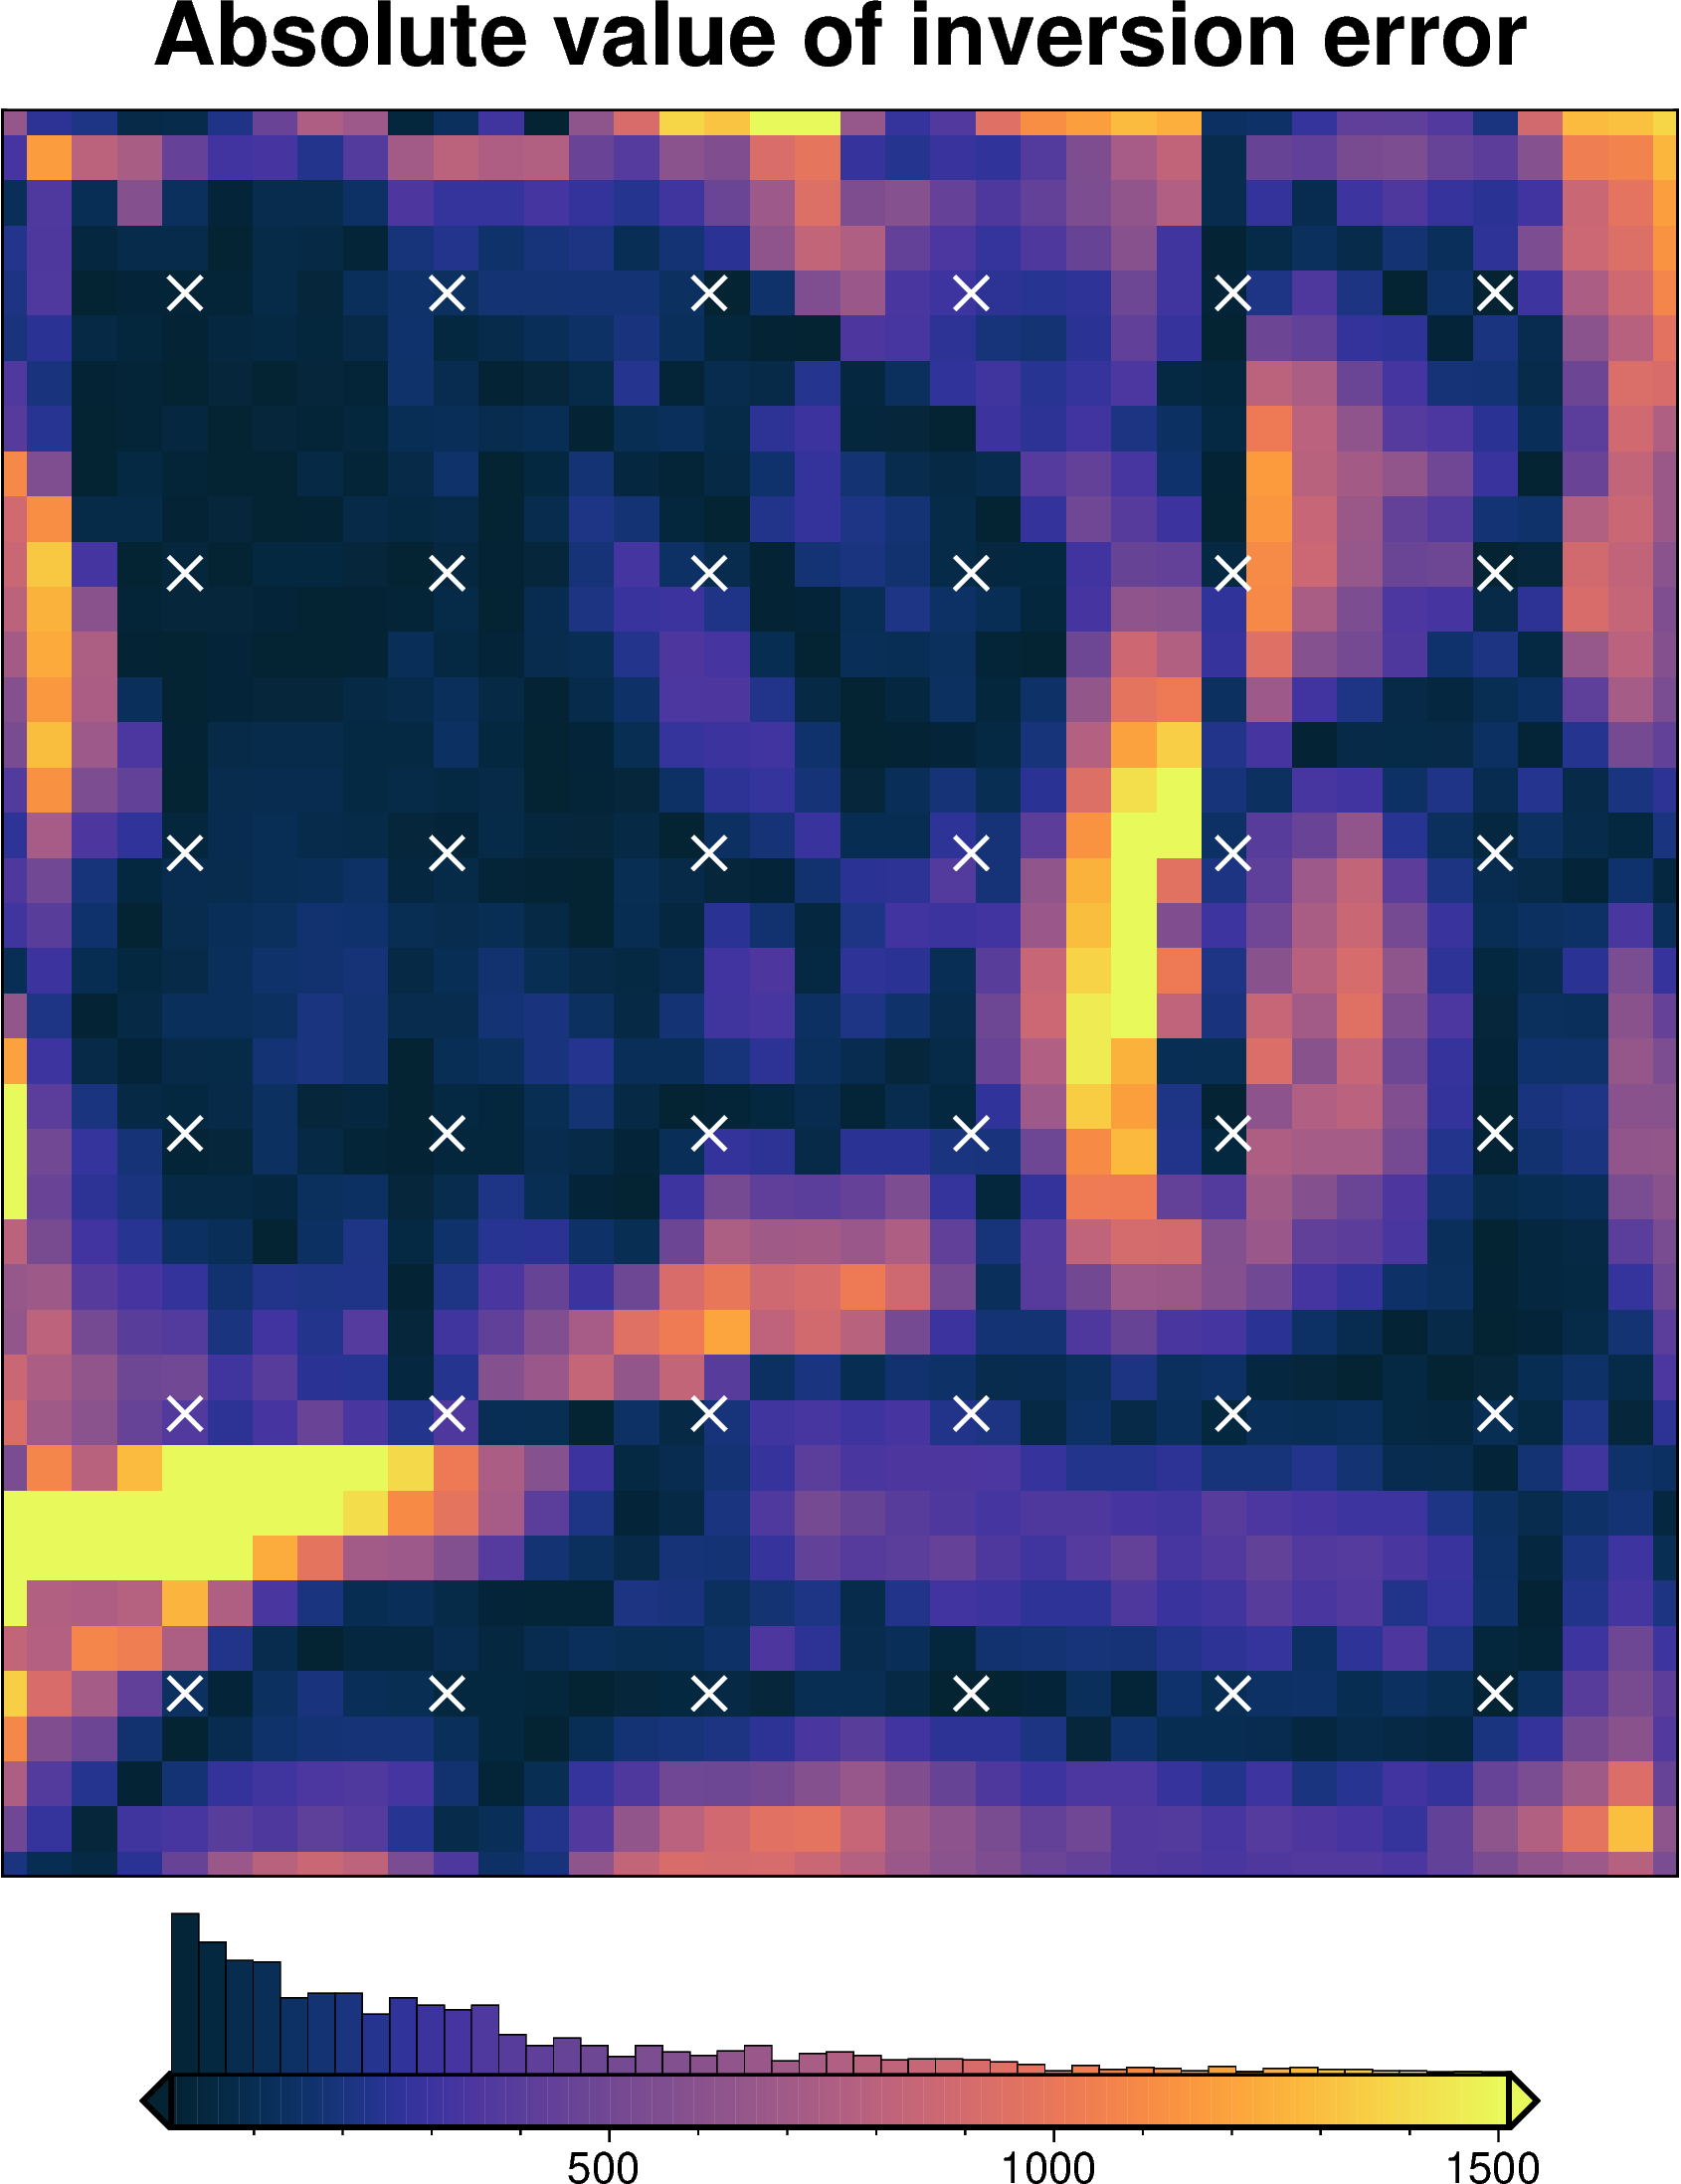

In [39]:
inversion_error = np.abs(grid.basement_topo - optimal_inv.model.topography)
fig = ptk.plot_grid(
    inversion_error,
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraint_points,
    points_style="x.4c",
    # points_pen="1p",
    points_fill="white",
)
fig.show()

In [40]:
# plotting functions for uncertainty results
def uncert_plots(
    results,
    inversion_region,
    spacing,
    true_topography,
    constraints_df=None,
    weight_by=None,
):
    if (weight_by == "constraints") & (constraints_df is None):
        msg = "must provide constraints_df if weighting by constraints"
        raise ValueError(msg)

    stats_ds = invert4geom.merged_stats(
        results=results,
        plot=True,
        constraints_df=constraints_df,
        weight_by=weight_by,
        region=inversion_region,
    )

    try:
        mean = stats_ds.weighted_mean
        stdev = stats_ds.weighted_stdev
    except AttributeError:
        mean = stats_ds.z_mean
        stdev = stats_ds.z_stdev

    _ = ptk.grid_compare(
        true_topography,
        mean,
        region=vd.pad_region(inversion_region, -spacing),
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        title="difference",
        reverse_cpt=True,
        cmap="rain",
        points=constraints_df,
        points_style="x.3c",
    )
    _ = ptk.grid_compare(
        np.abs(true_topography - mean),
        stdev,
        region=vd.pad_region(inversion_region, -spacing),
        grid1_name="True error",
        grid2_name="Stochastic uncertainty",
        cmap="thermal",
        robust=True,
        hist=True,
        inset=False,
        title="difference",
        points=constraints_df,
        points_style="x.3c",
        points_fill="white",
    )
    return stats_ds

## Uncertainty analysis


In [41]:
# get mean spacing between nearest constraints
mean_constraint_spacing = np.mean(
    vd.median_distance(
        (constraint_points.easting, constraint_points.northing),
        k_nearest=1,
    )
)
mean_constraint_spacing

np.float64(58000.0)

In [42]:
# use optimal eq source parameters for regional separation in uncertainty analysis
# re-load the study from the saved pickle file
with pathlib.Path(f"{regional_grav_kwargs.get('cv_kwargs').get('fname')}.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)
reg_eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]
reg_eq_depth = min(study.best_trials, key=lambda t: t.values[0]).params["depth"]

new_regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    damping=reg_eq_damping,
    depth=reg_eq_depth,
    block_size=None,
)

reg_eq_damping, reg_eq_depth

(5.92021021304295e-40, 109845.53034995627)

### Damping component

In [43]:
# load study
with pathlib.Path("../tmp/bishop_model_damping_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
# stdev = 0.4
print(f"using stdev: {stdev}")

calculated stdev: 0.6236500605493486
using stdev: 0.6236500605493486


best: 0.004116553513592815 
std: 0.6236500605493486 
+1std: 0.017305487021985973 
-1std: 0.0009792277333047065


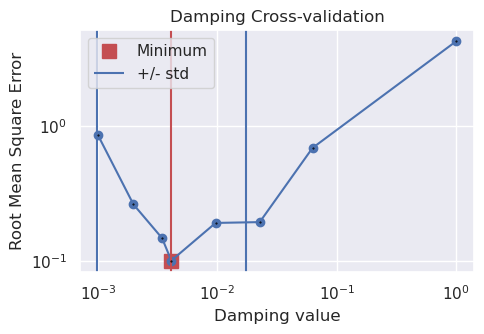

In [44]:
fig = invert4geom.plot_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10 ** (np.log10(best) + stdev))
lower = float(10 ** (np.log10(best) - stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

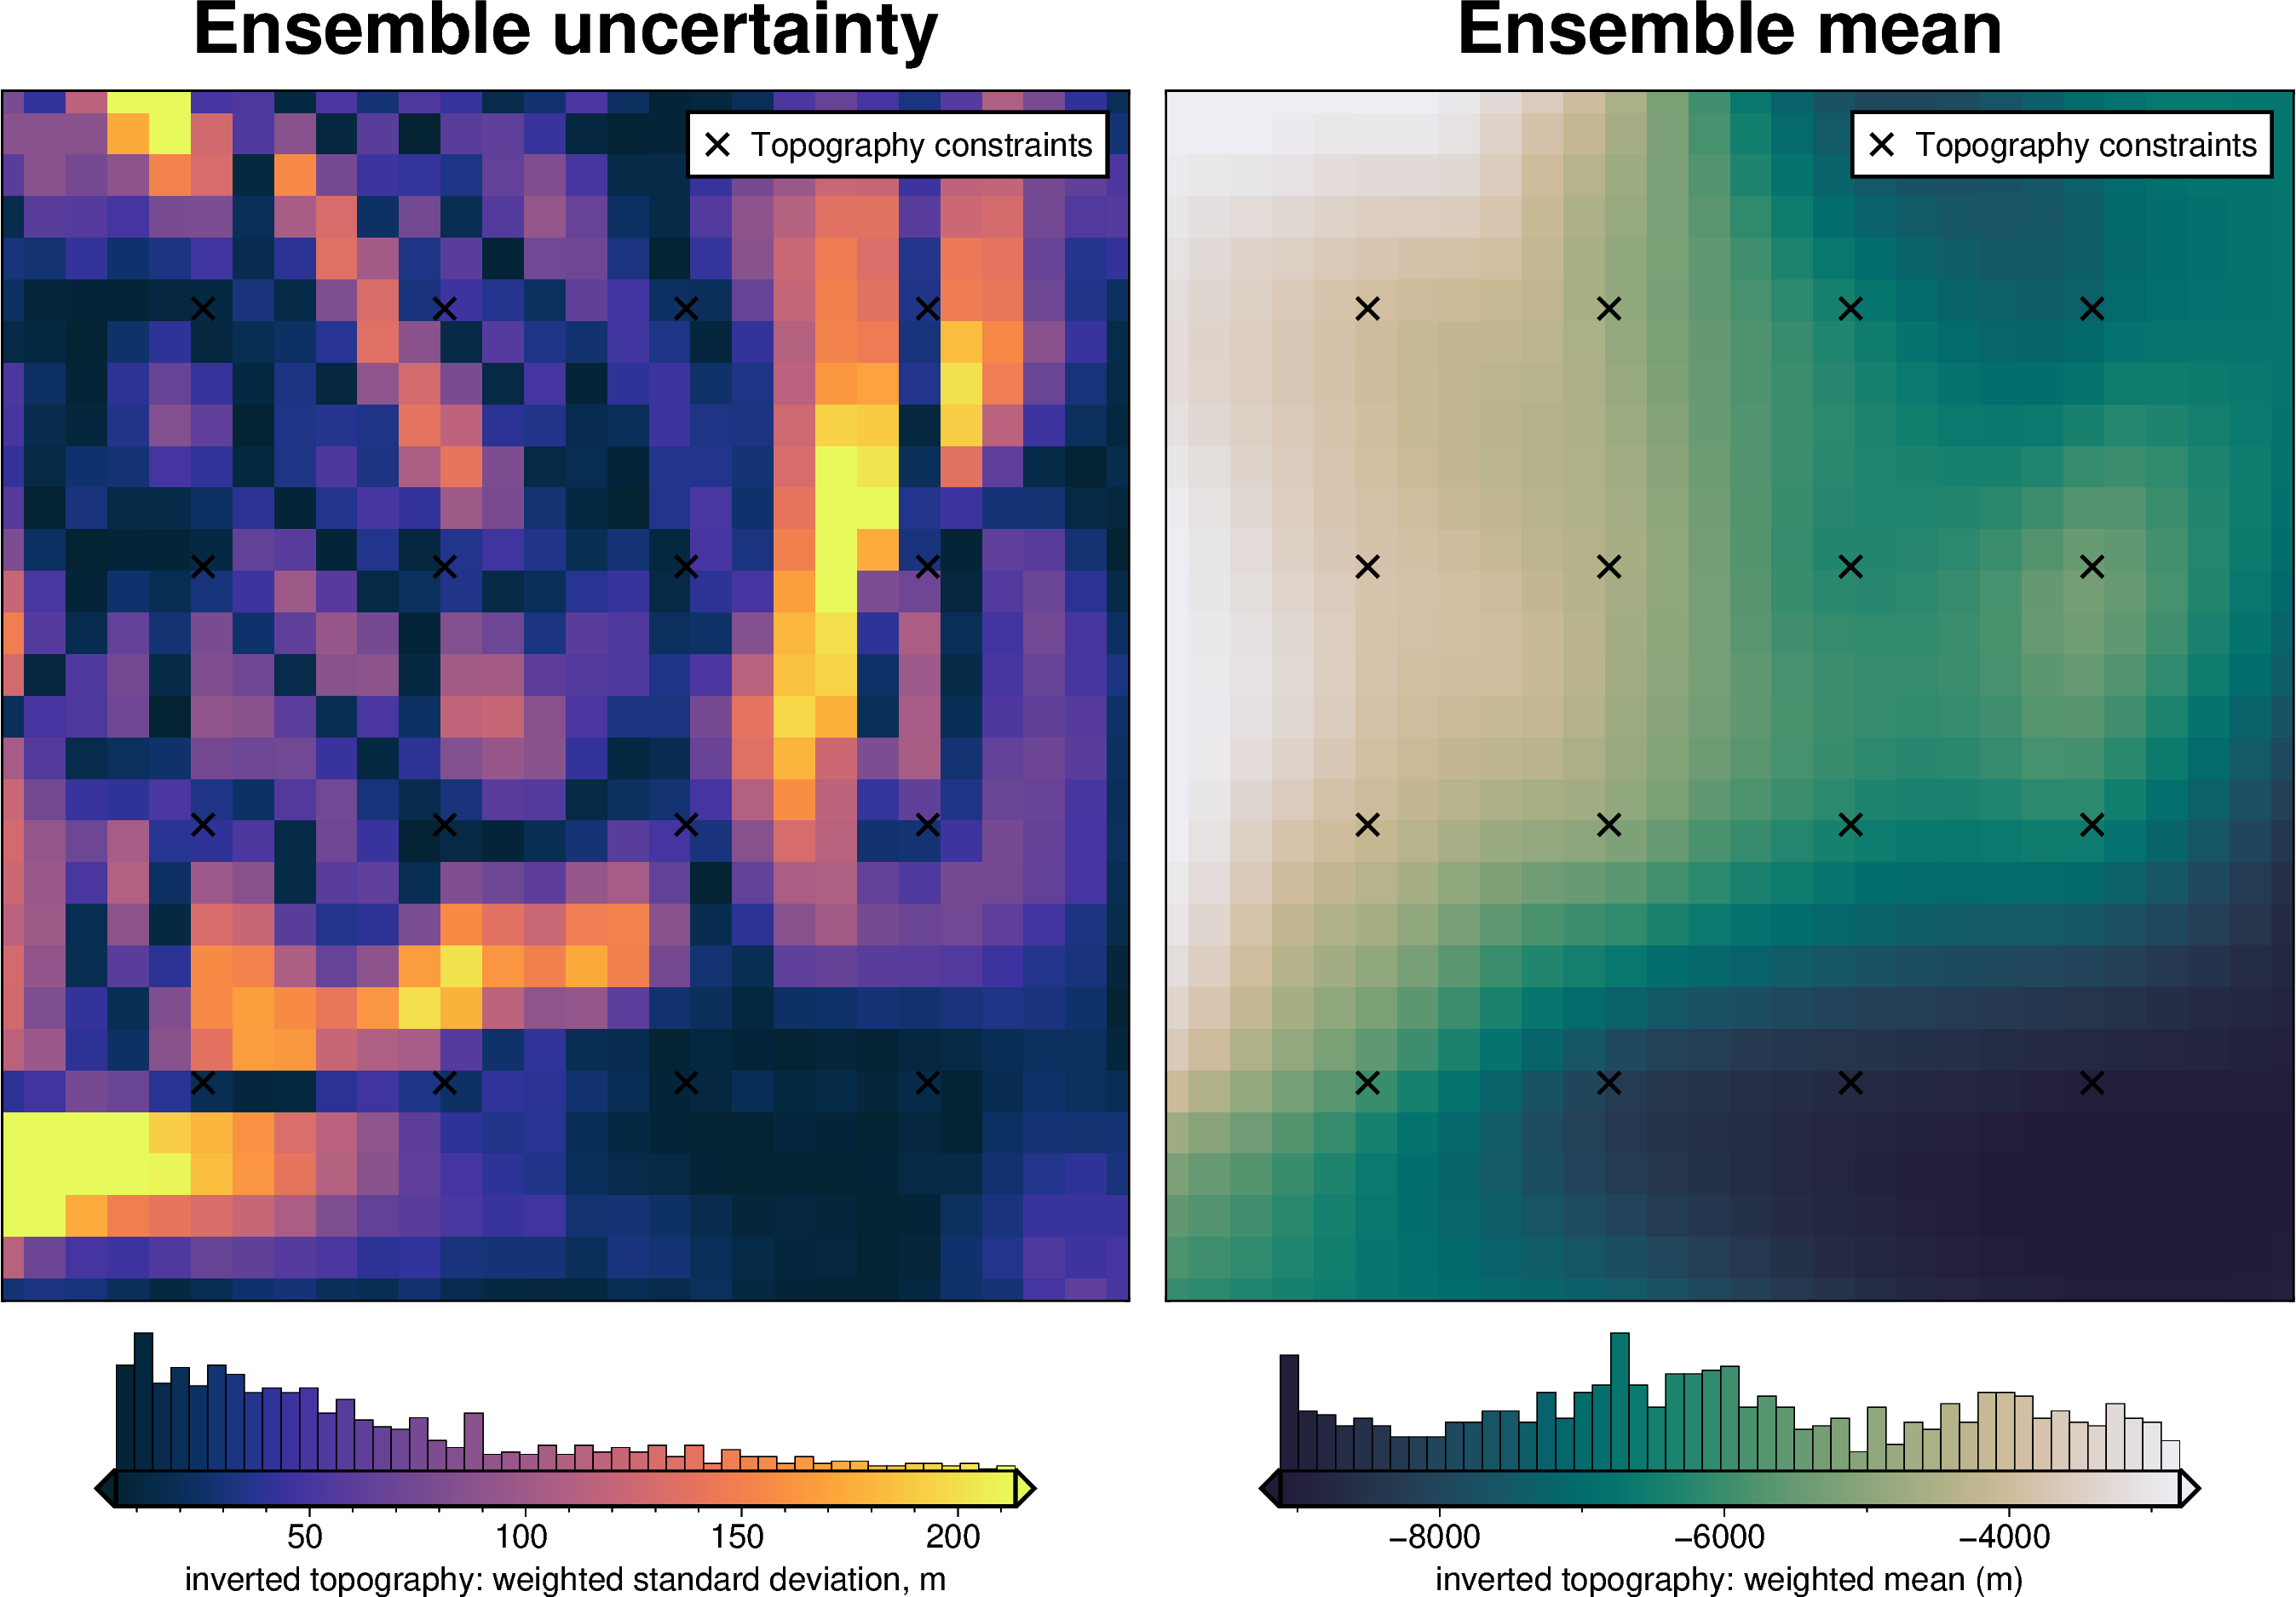

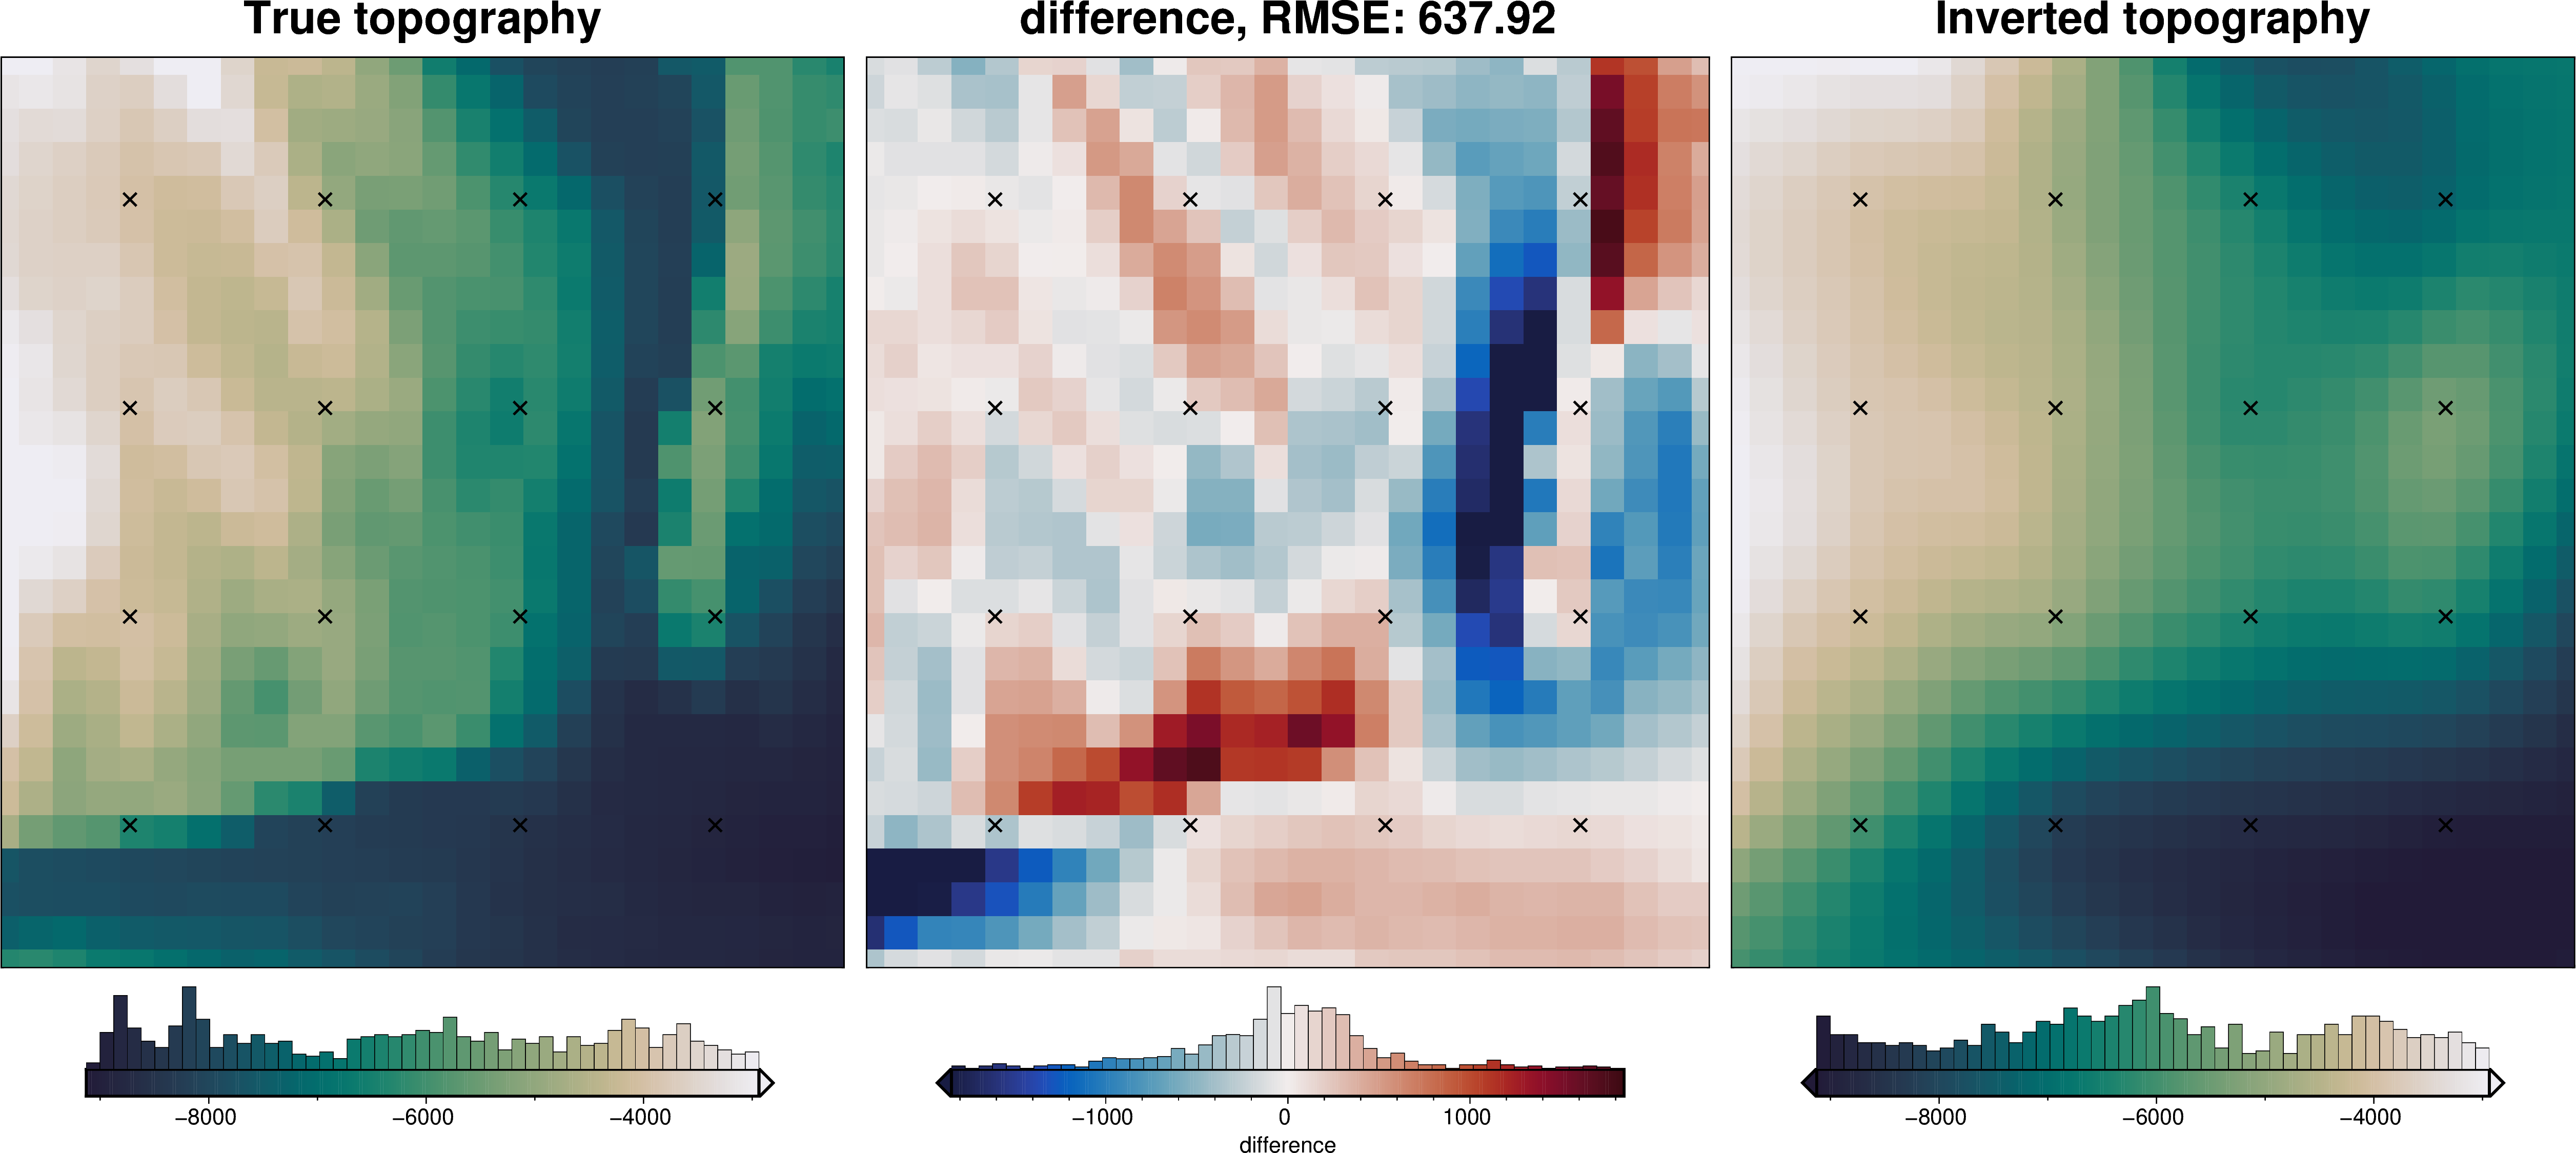

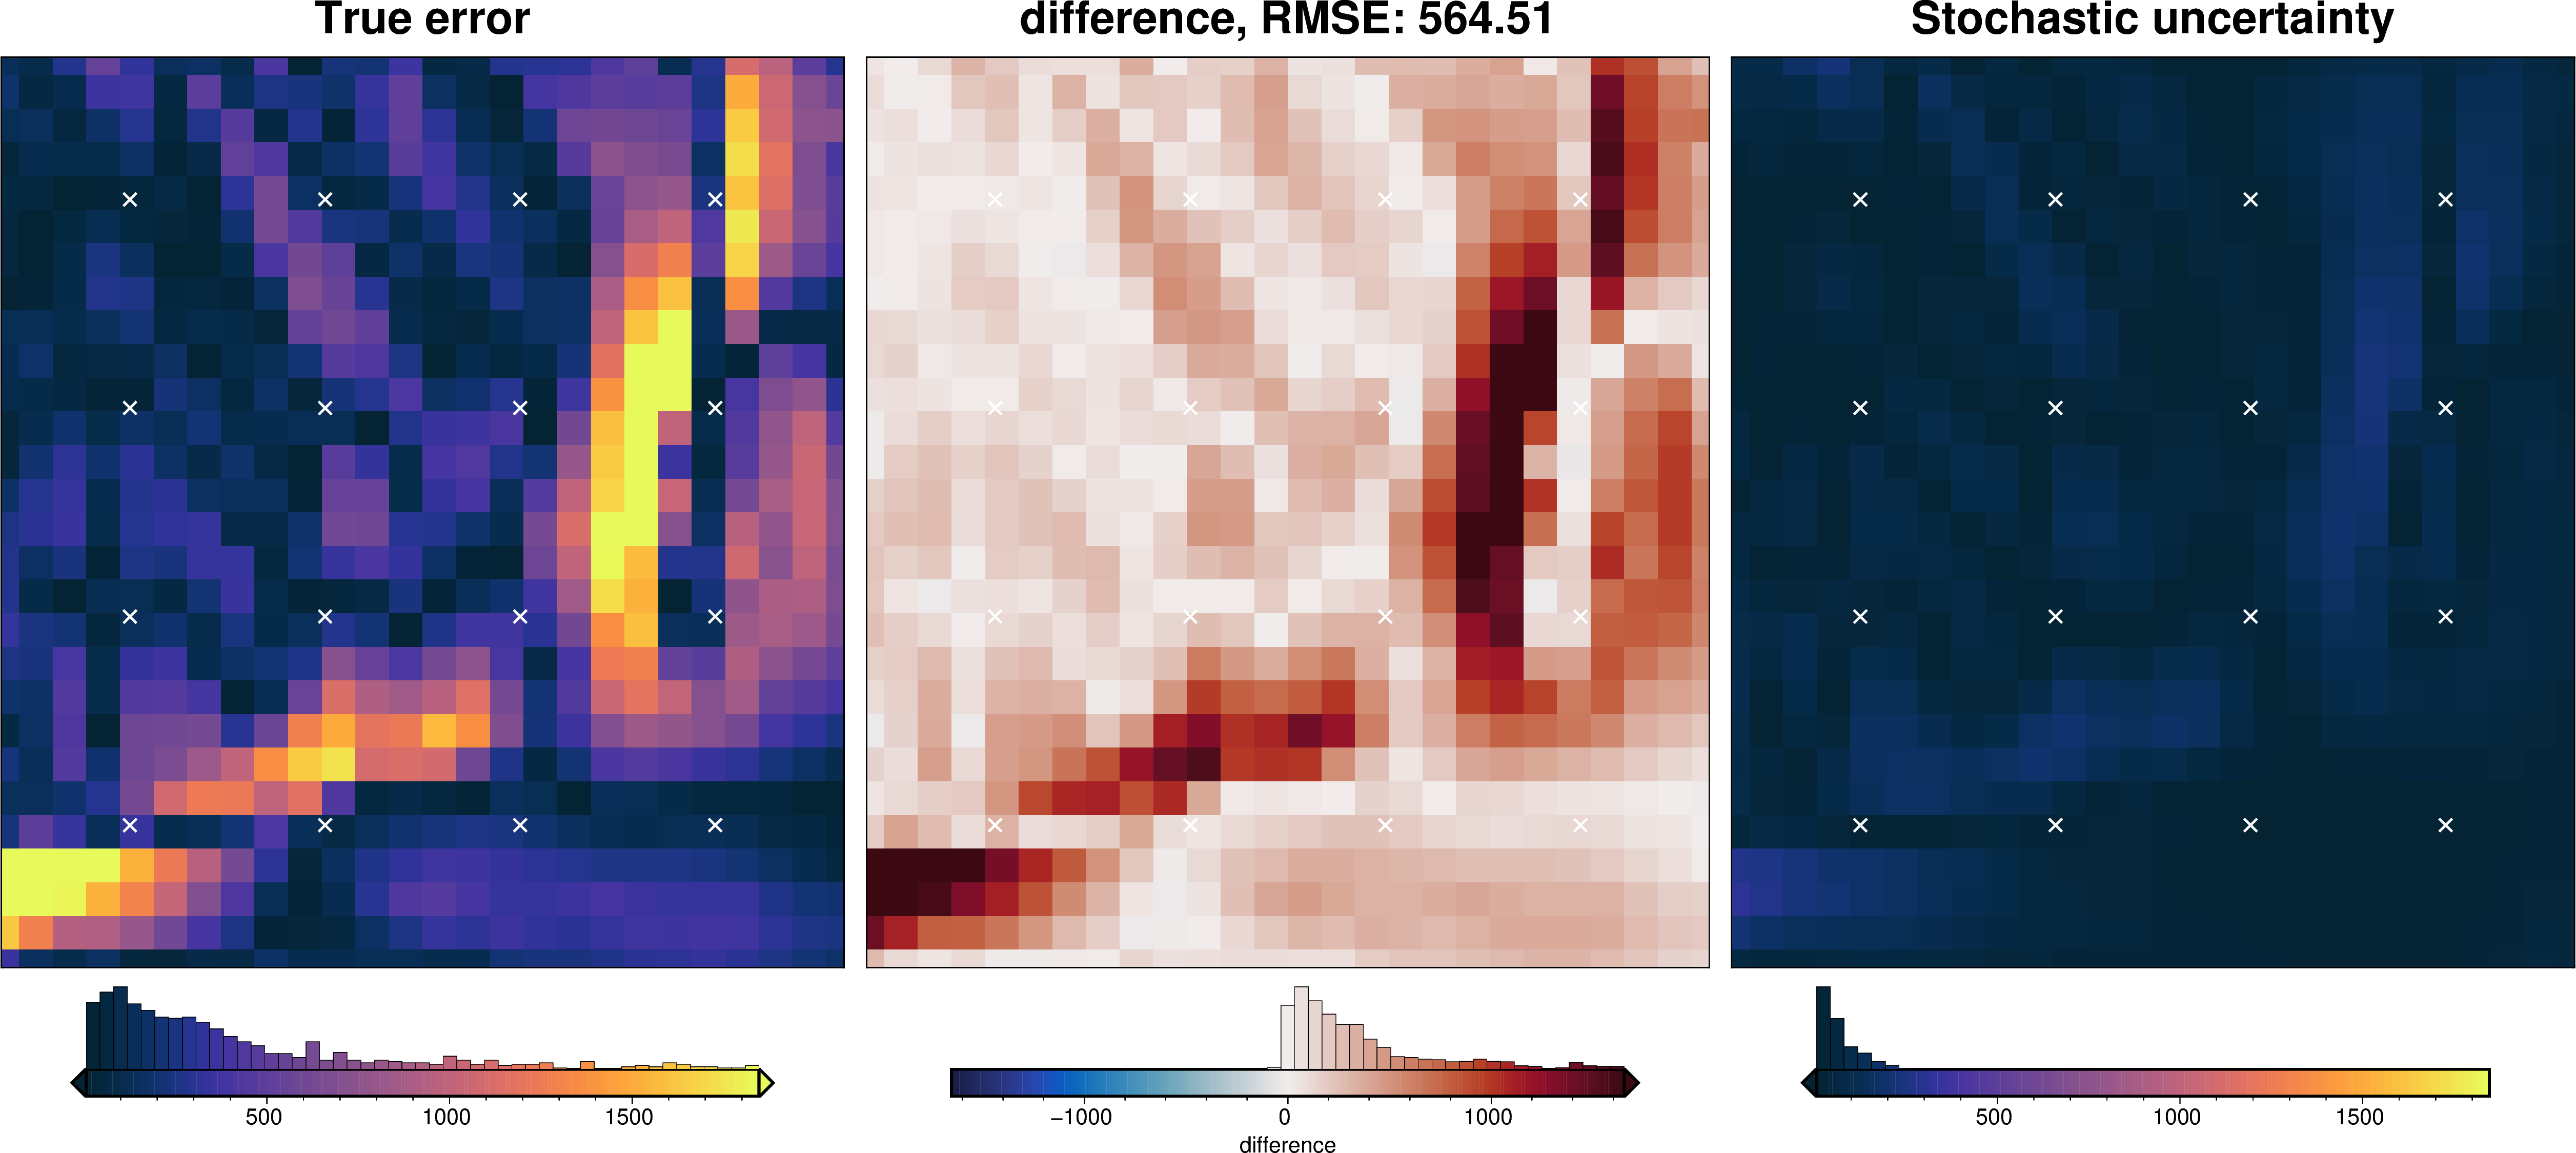

In [45]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(optimal_inv.solver_damping),  # mean base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
    },
}

fname = "../tmp/bishop_model_uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = invert4geom.full_workflow_uncertainty_loop(
    optimal_inv,
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

stats_ds = uncert_plots(
    uncert_damping_results,
    optimal_inv.data.inner_region,
    optimal_inv.data.spacing,
    grid.basement_topo,
    constraints_df=constraint_points,
    weight_by="constraints",
)

### Density component

In [46]:
# load study
with pathlib.Path("../tmp/bishop_model_density_optimization_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

density_stdev = study_df2.params_density_contrast.std()
print(f"calculated stdev: {density_stdev}")

# manually pick a stdev
# density_stdev = 20
print(f"using stdev: {density_stdev}")

calculated stdev: 156.12076877995588
using stdev: 156.12076877995588


best: 600 
std: 156.12076877995588 
+1std: 756.1207687799558 
-1std: 443.8792312200441


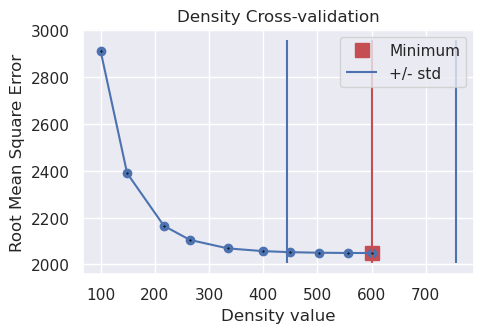

In [47]:
fig = invert4geom.plot_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_density_contrast.values,
    param_name="Density",
    logx=False,
    logy=False,
)
ax = fig.axes[0]

best = study_df2.params_density_contrast.iloc[0]
upper = best + density_stdev
lower = best - density_stdev

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", density_stdev, "\n+1std:", upper, "\n-1std:", lower)

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

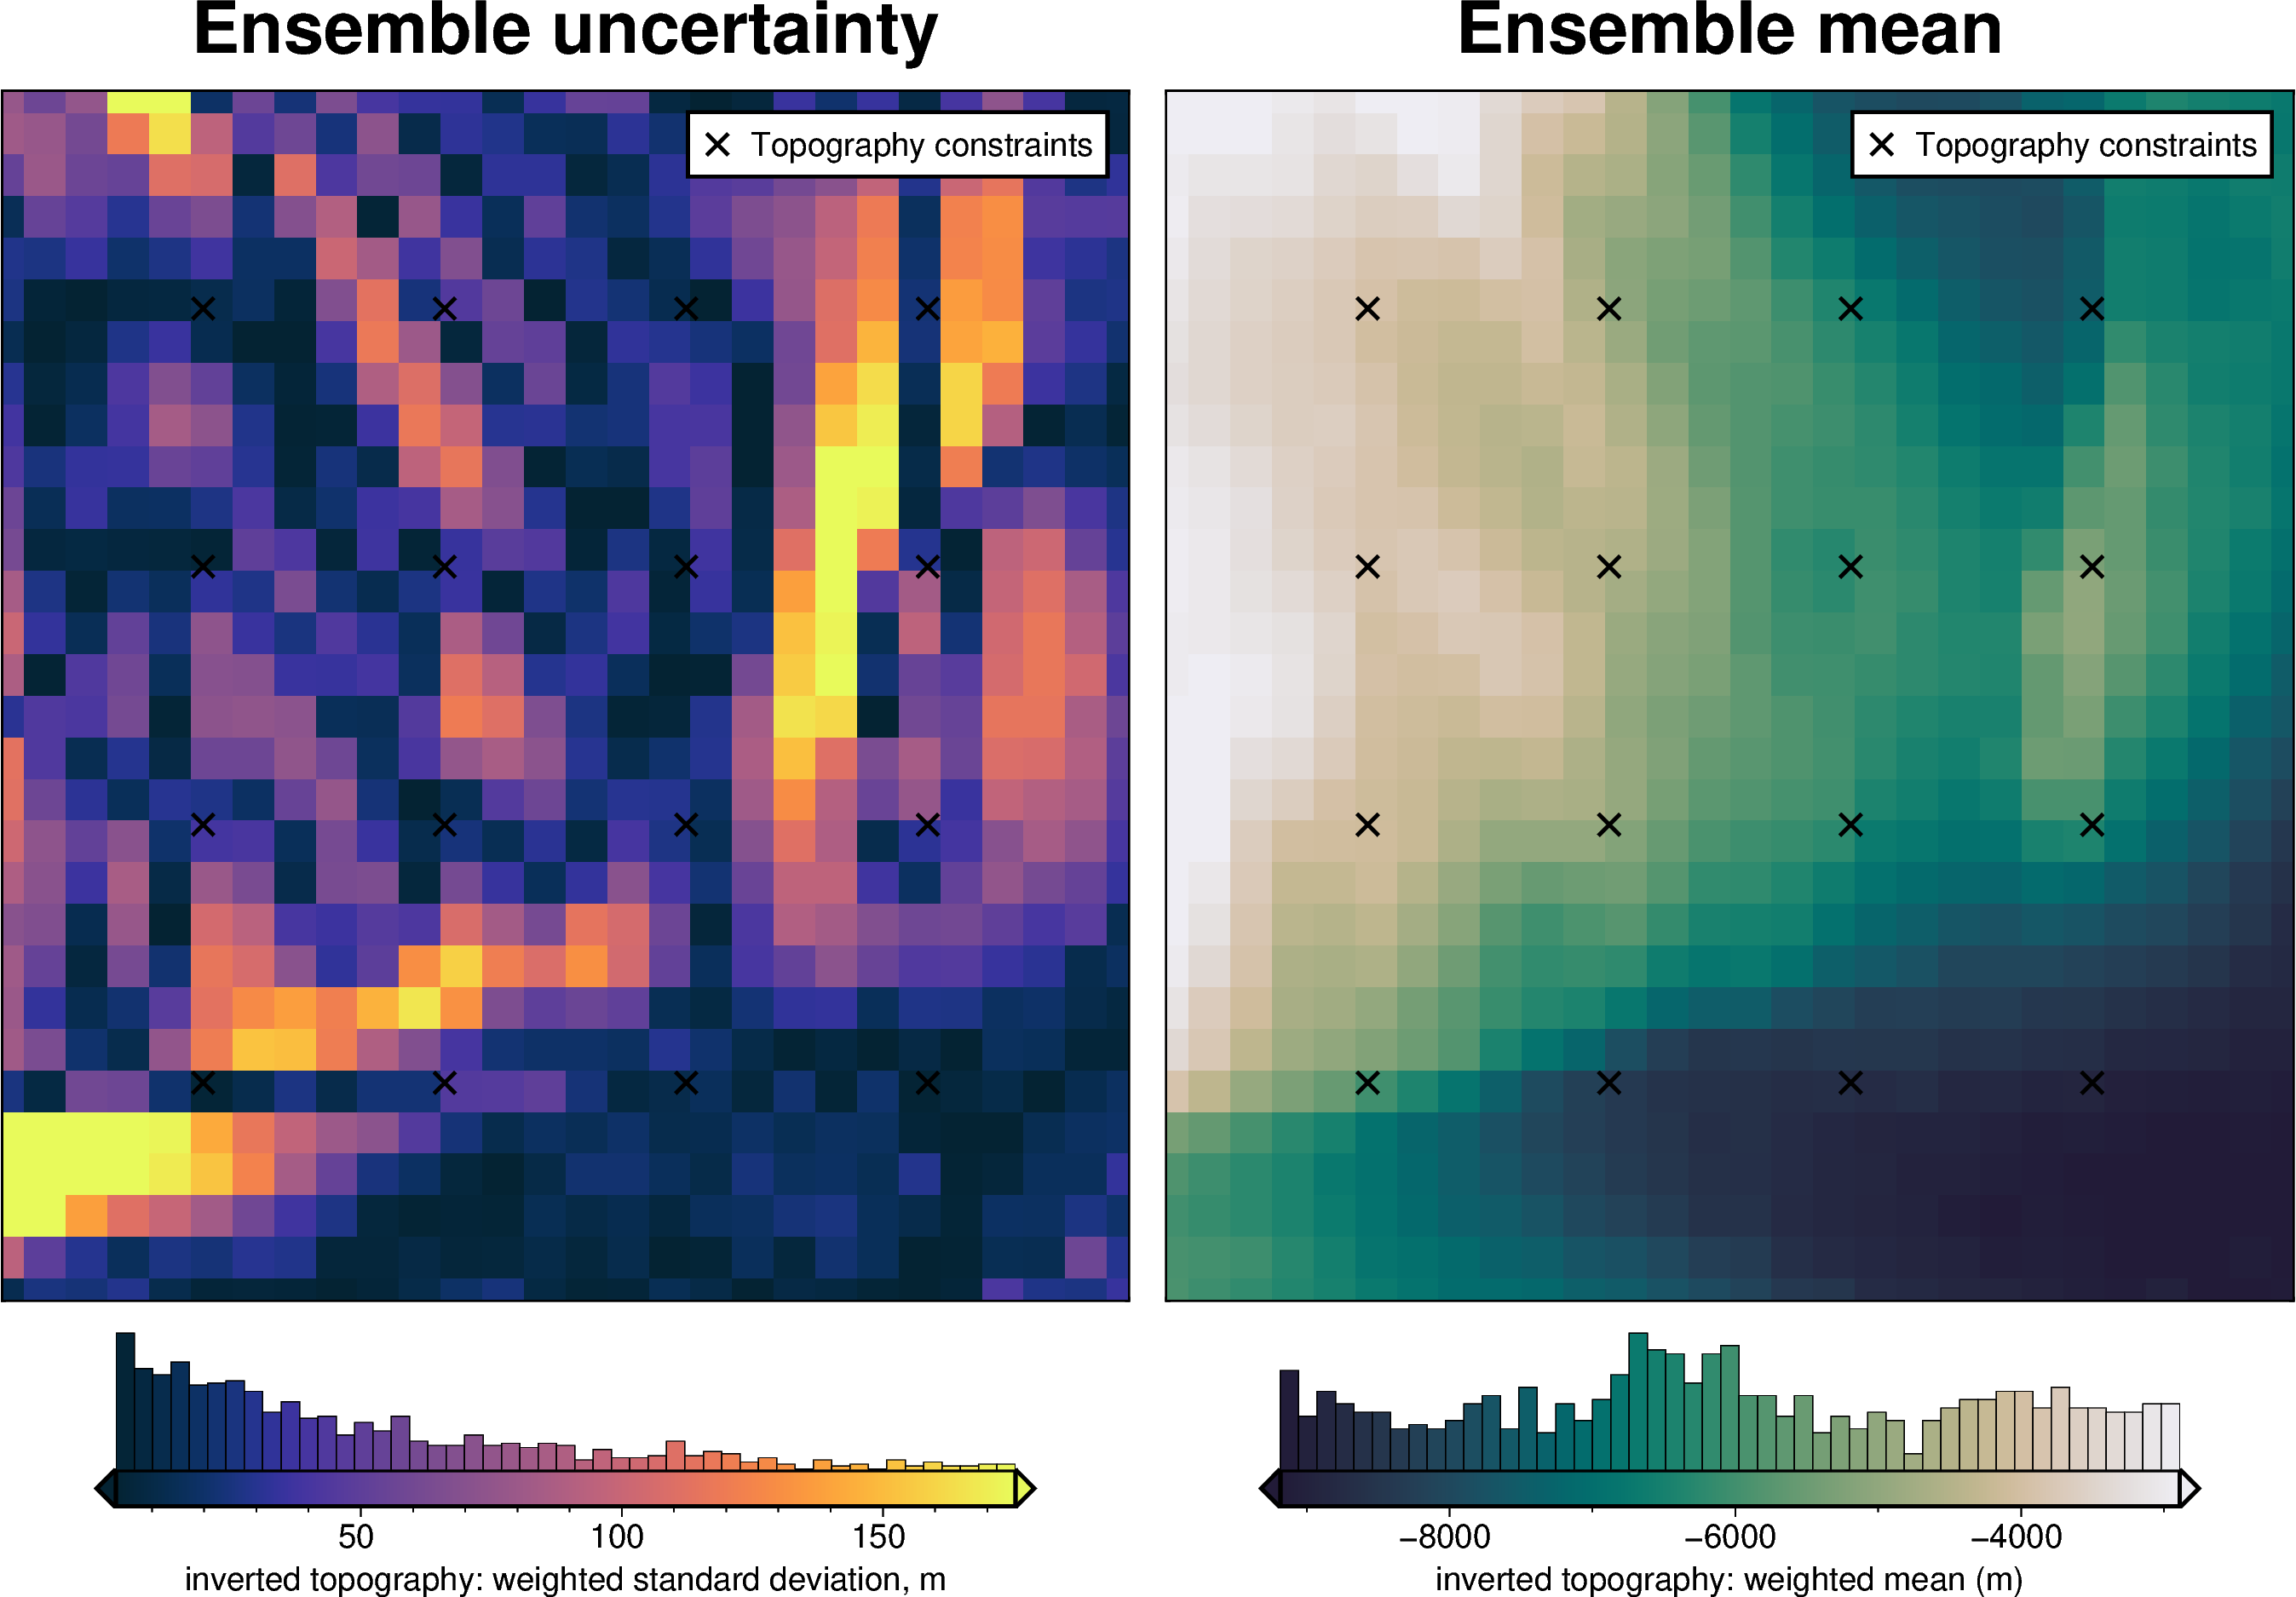

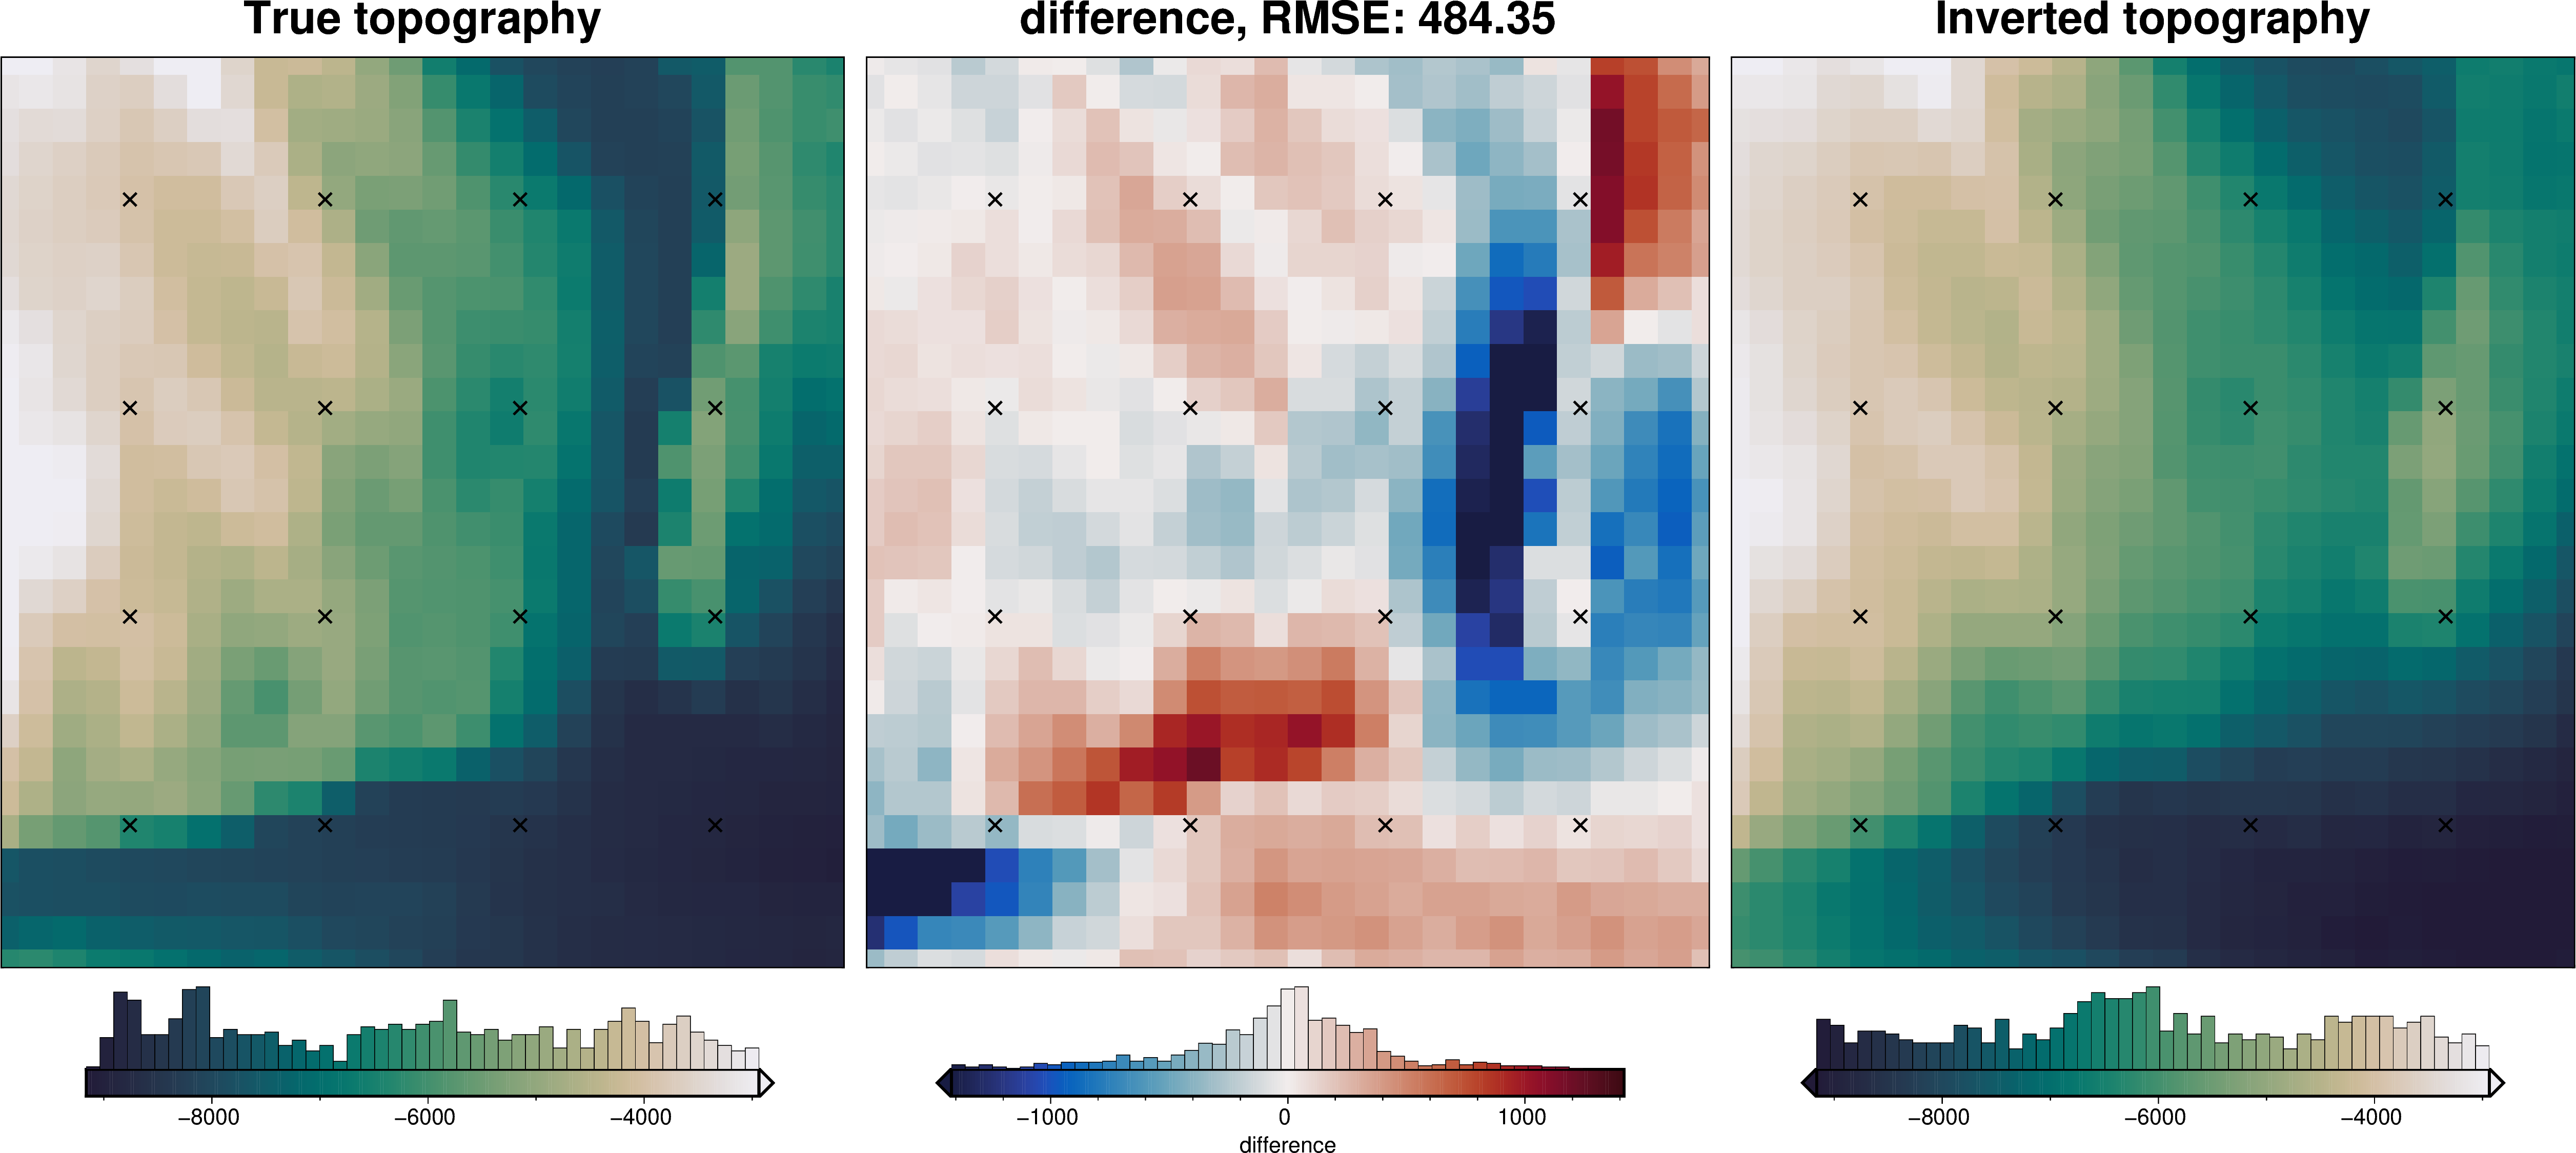

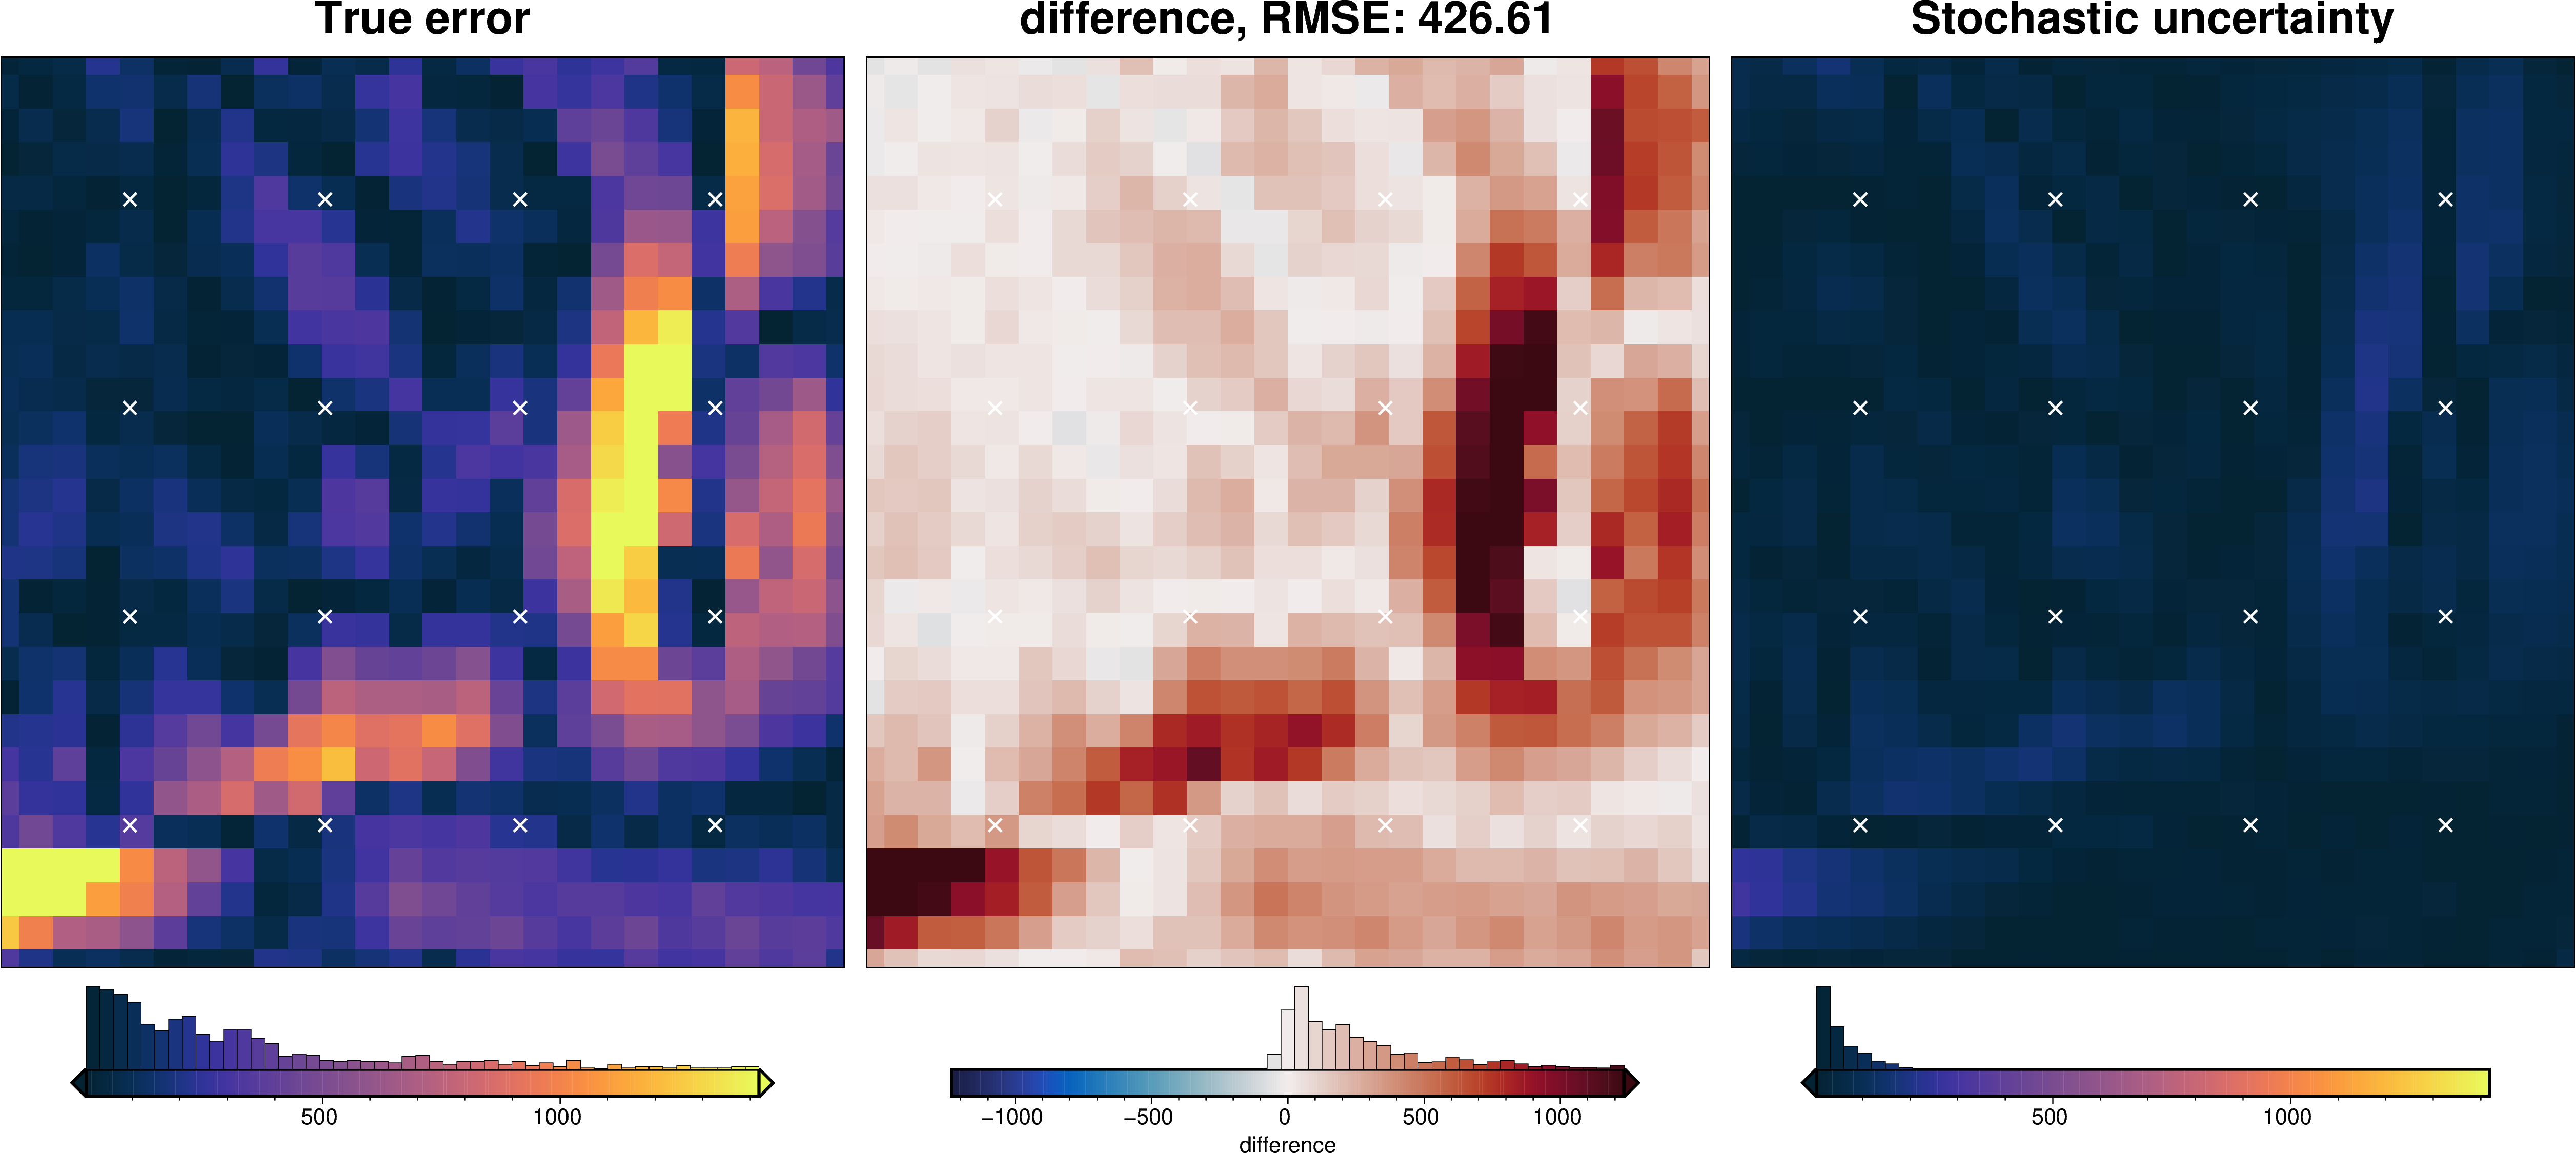

<xarray.Dataset> Size: 122kB
Dimensions:         (northing: 30, easting: 28, runs: 10)
Coordinates:
    top             (northing, easting) float64 7kB -5.892e+03 ... -6.087e+03
    bottom          (northing, easting) float64 7kB -6.087e+03 ... -6.726e+03
  * northing        (northing) float64 240B 1.959e+05 2.059e+05 ... 4.859e+05
  * easting         (easting) float64 224B 5.69e+04 6.69e+04 ... 3.269e+05
  * runs            (runs) <U5 200B 'run_0' 'run_1' 'run_2' ... 'run_8' 'run_9'
Data variables:
    run_num         (runs, northing, easting) float64 67kB -5.892e+03 ... -6....
    z_mean          (northing, easting) float64 7kB -5.899e+03 ... -6.73e+03
    z_stdev         (northing, easting) float64 7kB 15.56 30.89 ... 8.044 9.663
    weighted_mean   (northing, easting) float64 7kB -5.895e+03 ... -6.727e+03
    weighted_stdev  (northing, easting) float64 7kB 12.68 25.43 ... 7.165 7.945
    z_min           (northing, easting) float64 7kB -5.931e+03 ... -6.752e+03
    z_max           (northing, easting) float64 7kB -5.886e+03 ... -6.718e+03

In [48]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": optimal_inv.model.density_contrast,
        "scale": density_stdev,
    },
}

fname = "../tmp/bishop_model_uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = invert4geom.full_workflow_uncertainty_loop(
    optimal_inv,
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

uncert_plots(
    uncert_density_results,
    optimal_inv.data.inner_region,
    optimal_inv.data.spacing,
    grid.basement_topo,
    constraints_df=constraint_points,
    weight_by="constraints",
)

### Zref component

In [49]:
# load study
with pathlib.Path("../tmp/bishop_model_zref_optimization_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

zref_stdev = study_df2.params_zref.std()
print(f"calculated stdev: {zref_stdev}")

# manually pick a stdev
# zref_stdev = 20
print(f"using stdev: {zref_stdev}")

calculated stdev: 1296.630310144196
using stdev: 1296.630310144196


best: -6086.969583903166 
std: 1296.630310144196 
+1std: -4790.339273758969 
-1std: -7383.599894047362


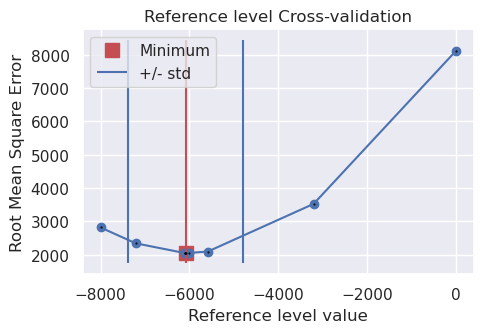

In [50]:
fig = invert4geom.plot_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_zref.values,
    param_name="Reference level",
    logx=False,
    logy=False,
)
ax = fig.axes[0]

best = study_df2.params_zref.iloc[0]
upper = best + zref_stdev
lower = best - zref_stdev

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", zref_stdev, "\n+1std:", upper, "\n-1std:", lower)

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

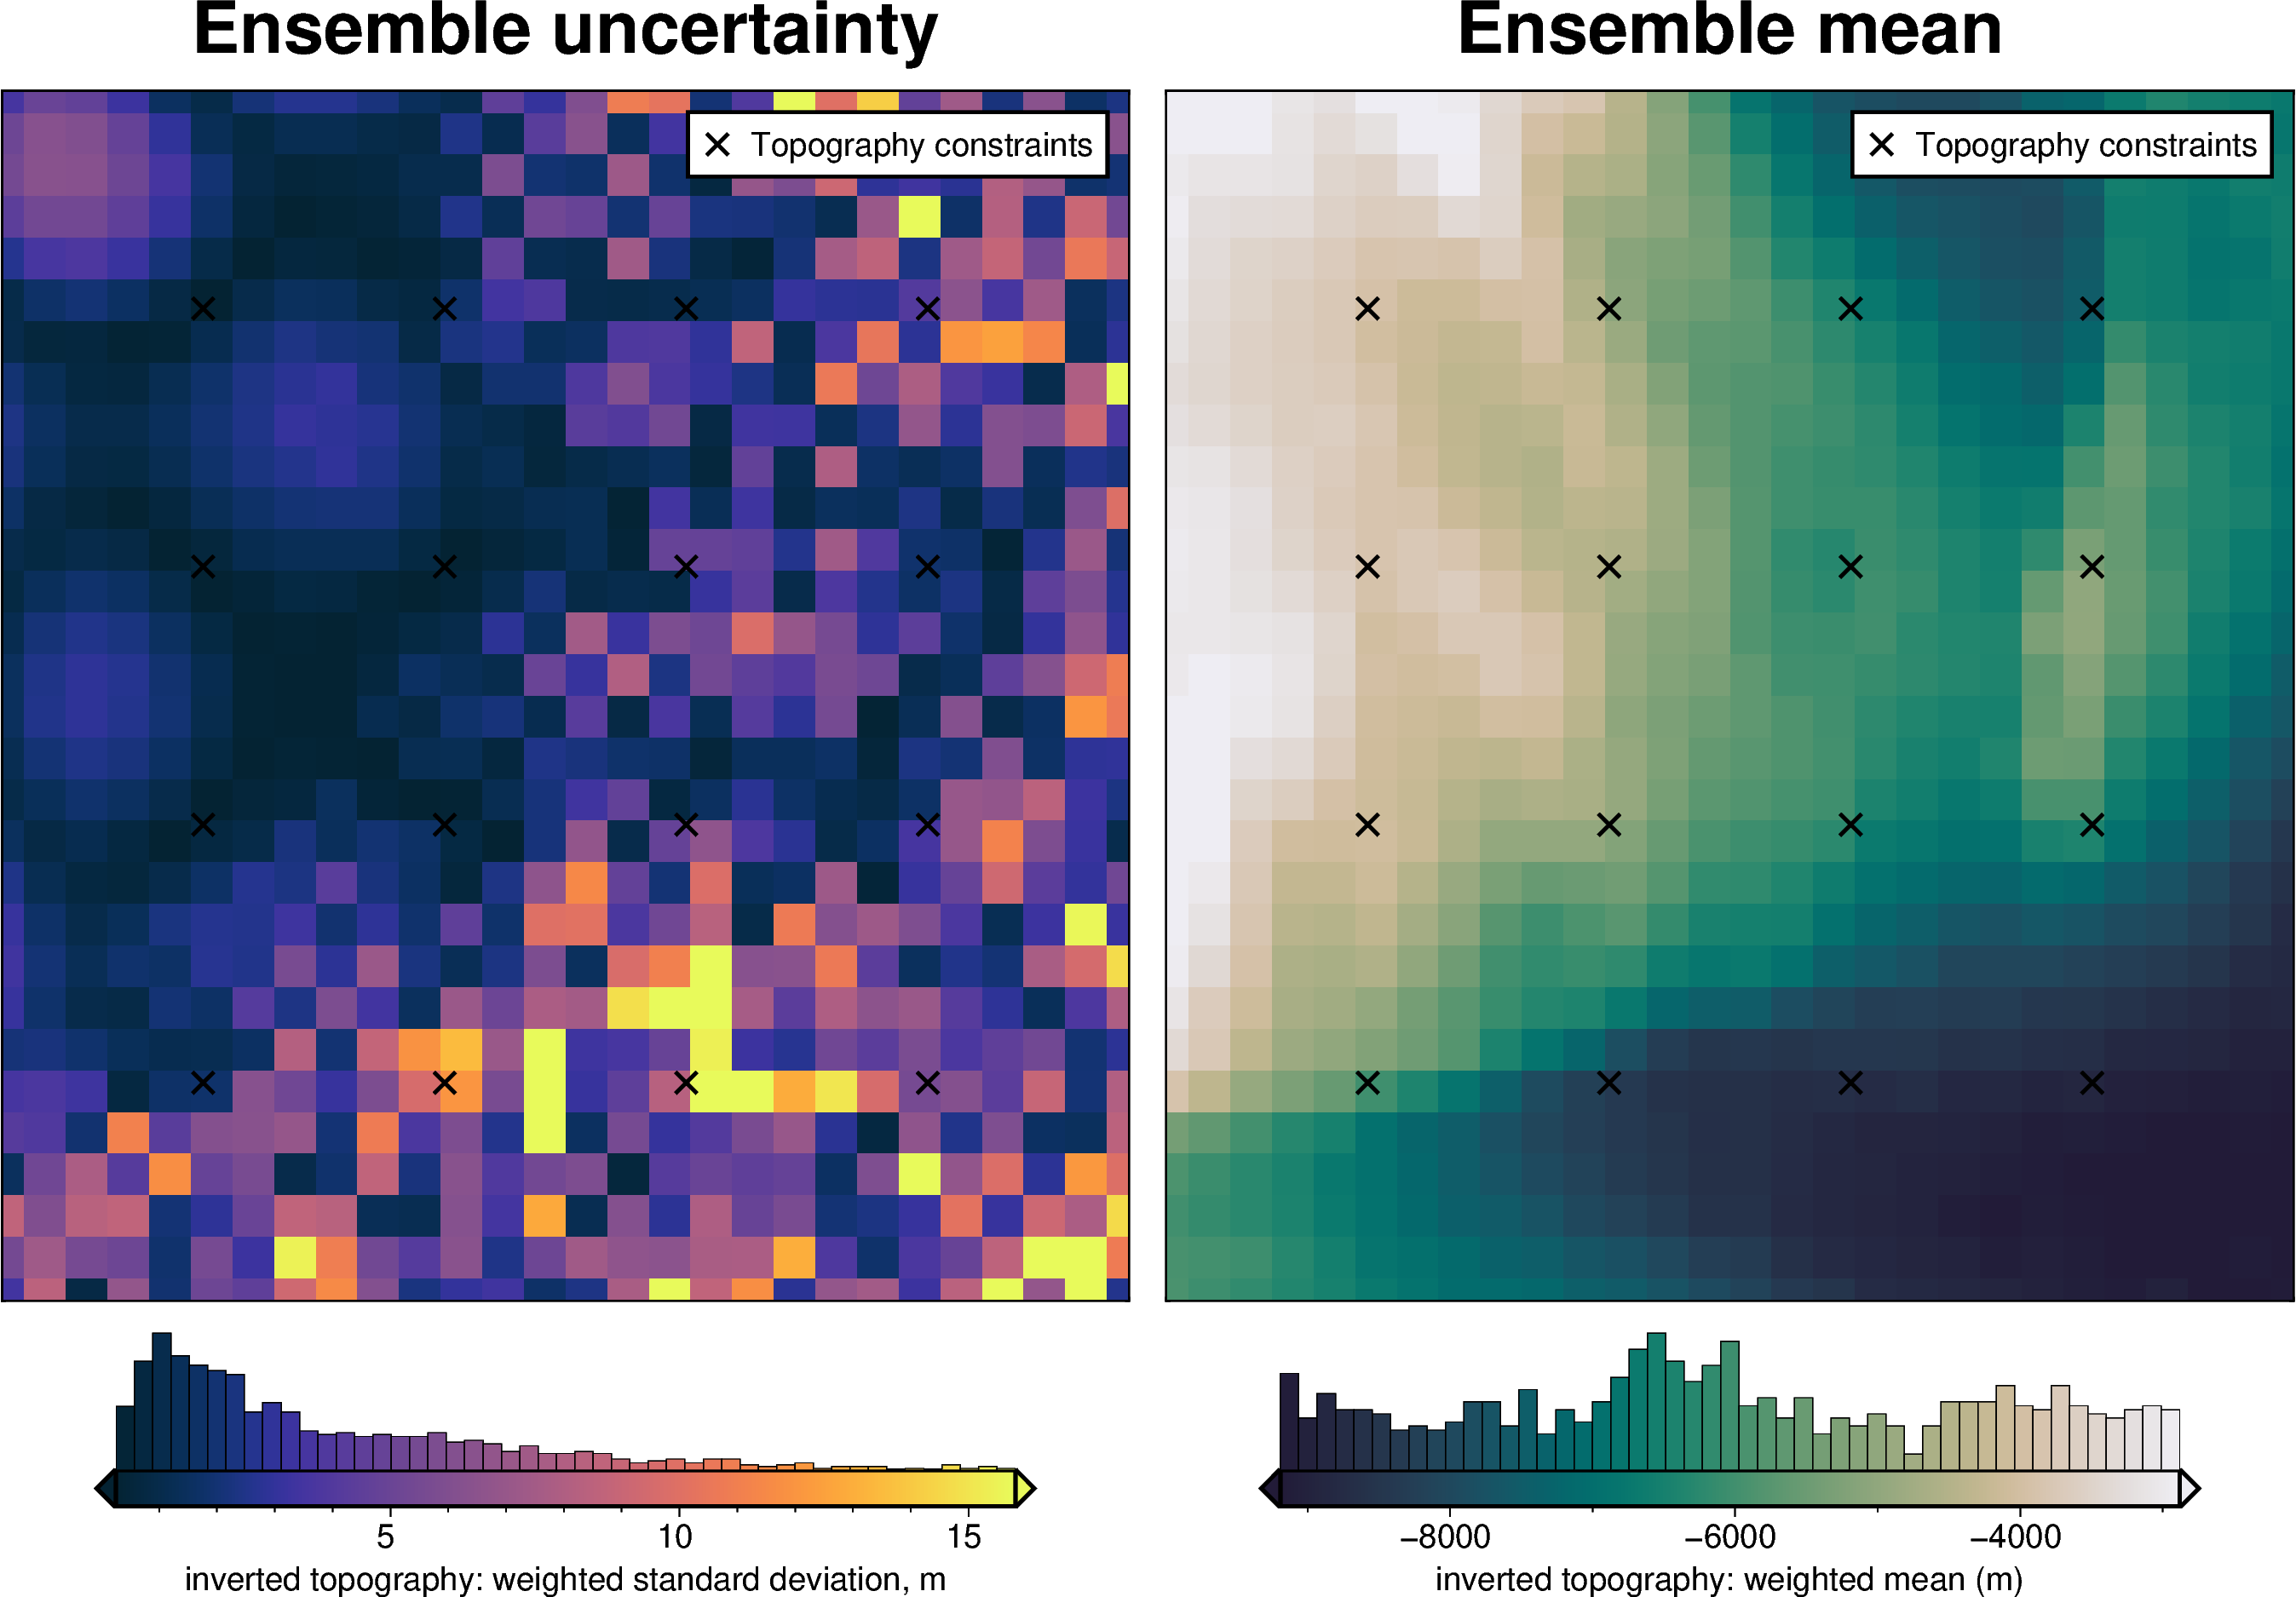

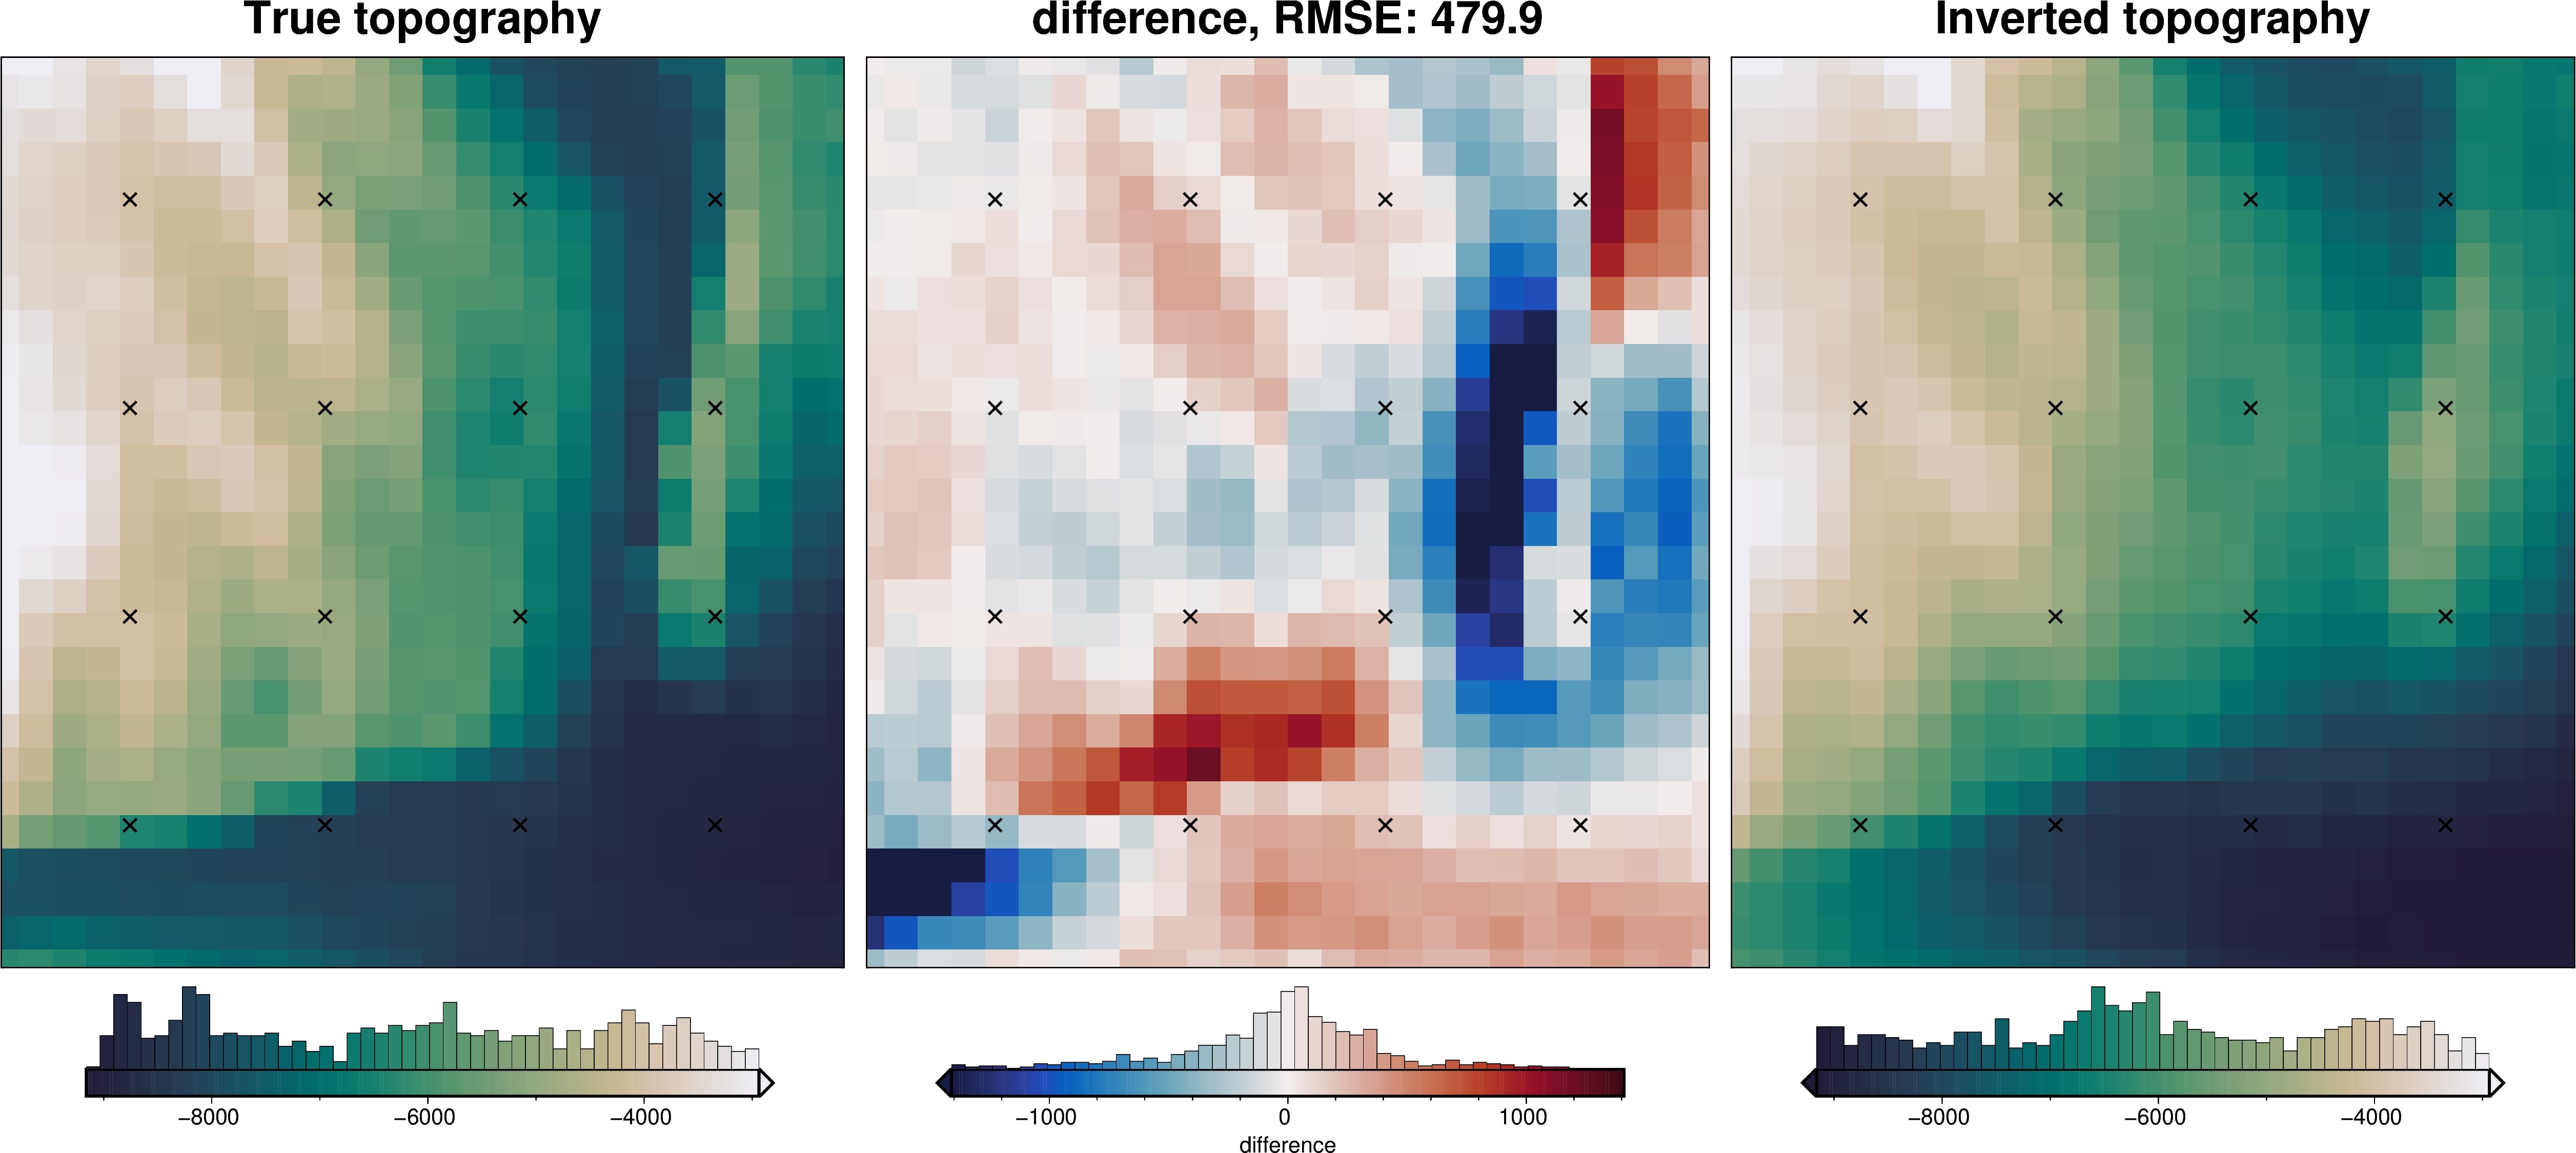

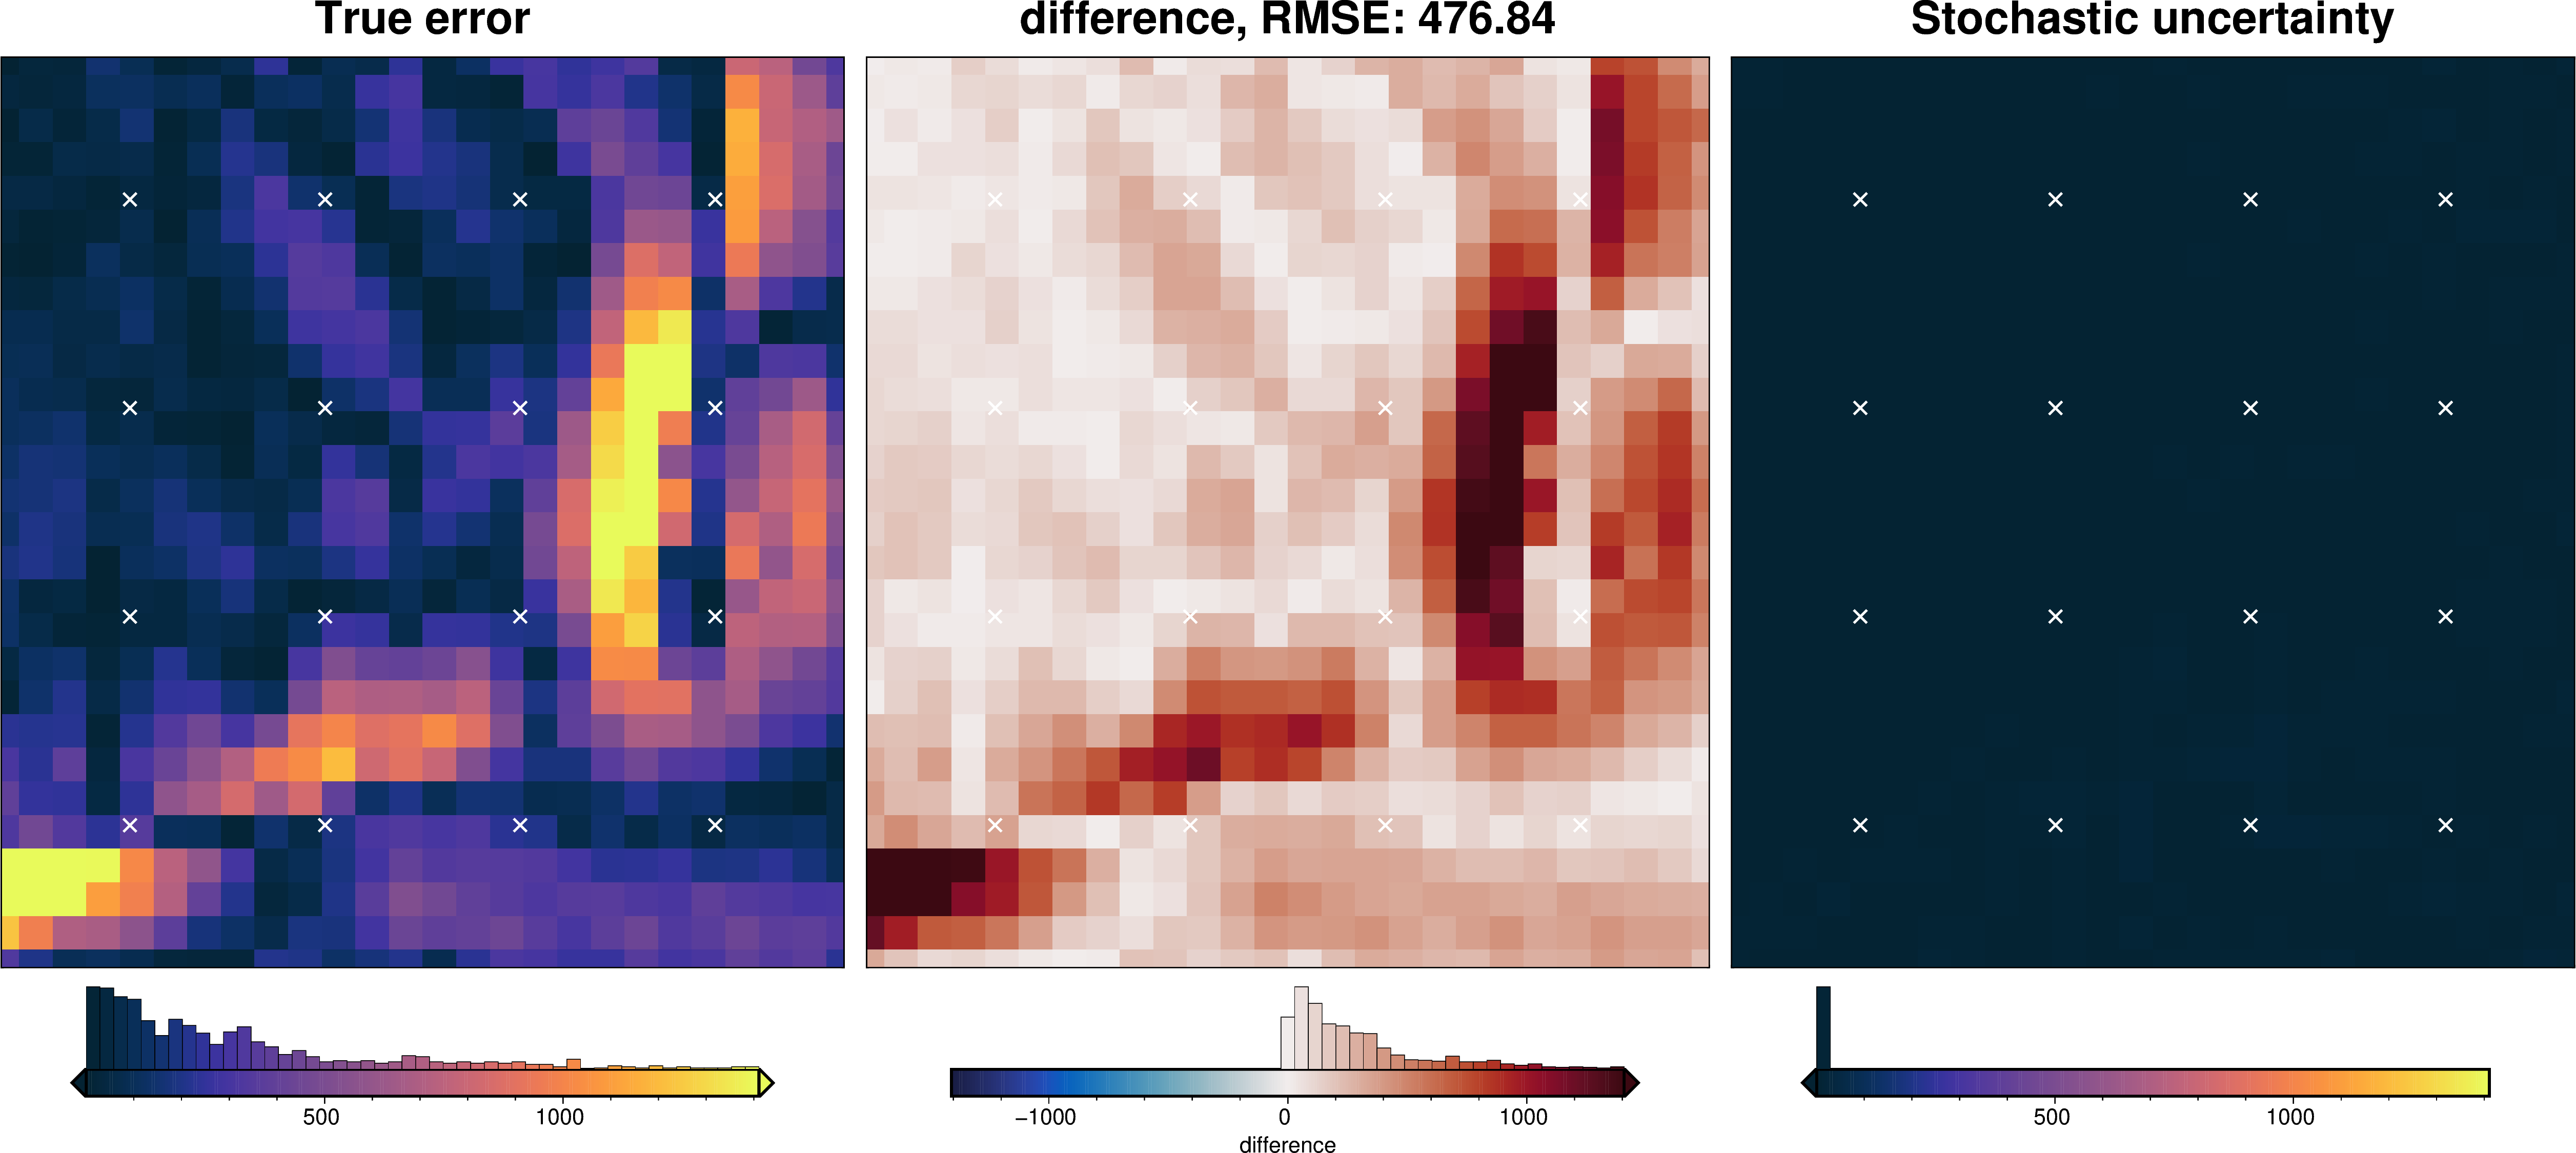

<xarray.Dataset> Size: 122kB
Dimensions:         (northing: 30, easting: 28, runs: 10)
Coordinates:
    top             (northing, easting) float64 7kB -5.892e+03 ... -5.924e+03
    bottom          (northing, easting) float64 7kB -5.924e+03 ... -6.727e+03
  * northing        (northing) float64 240B 1.959e+05 2.059e+05 ... 4.859e+05
  * easting         (easting) float64 224B 5.69e+04 6.69e+04 ... 3.269e+05
  * runs            (runs) <U5 200B 'run_0' 'run_1' 'run_2' ... 'run_8' 'run_9'
Data variables:
    run_num         (runs, northing, easting) float64 67kB -5.892e+03 ... -6....
    z_mean          (northing, easting) float64 7kB -5.89e+03 ... -6.729e+03
    z_stdev         (northing, easting) float64 7kB 3.466 8.533 ... 1.668 2.354
    weighted_mean   (northing, easting) float64 7kB -5.89e+03 ... -6.729e+03
    weighted_stdev  (northing, easting) float64 7kB 3.465 8.459 ... 1.671 2.362
    z_min           (northing, easting) float64 7kB -5.896e+03 ... -6.734e+03
    z_max           (northing, easting) float64 7kB -5.885e+03 ... -6.727e+03

In [51]:
zref_dict = {
    "zref": {
        "distribution": "normal",
        "loc": optimal_inv.model.zref,
        "scale": zref_stdev,
    },
}

fname = "../tmp/bishop_model_uncertainty_zref"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_zref_results = invert4geom.full_workflow_uncertainty_loop(
    optimal_inv,
    fname=fname,
    runs=10,
    parameter_dict=zref_dict,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

uncert_plots(
    uncert_zref_results,
    optimal_inv.data.inner_region,
    optimal_inv.data.spacing,
    grid.basement_topo,
    constraints_df=constraint_points,
    weight_by="constraints",
)

### Constraints component

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

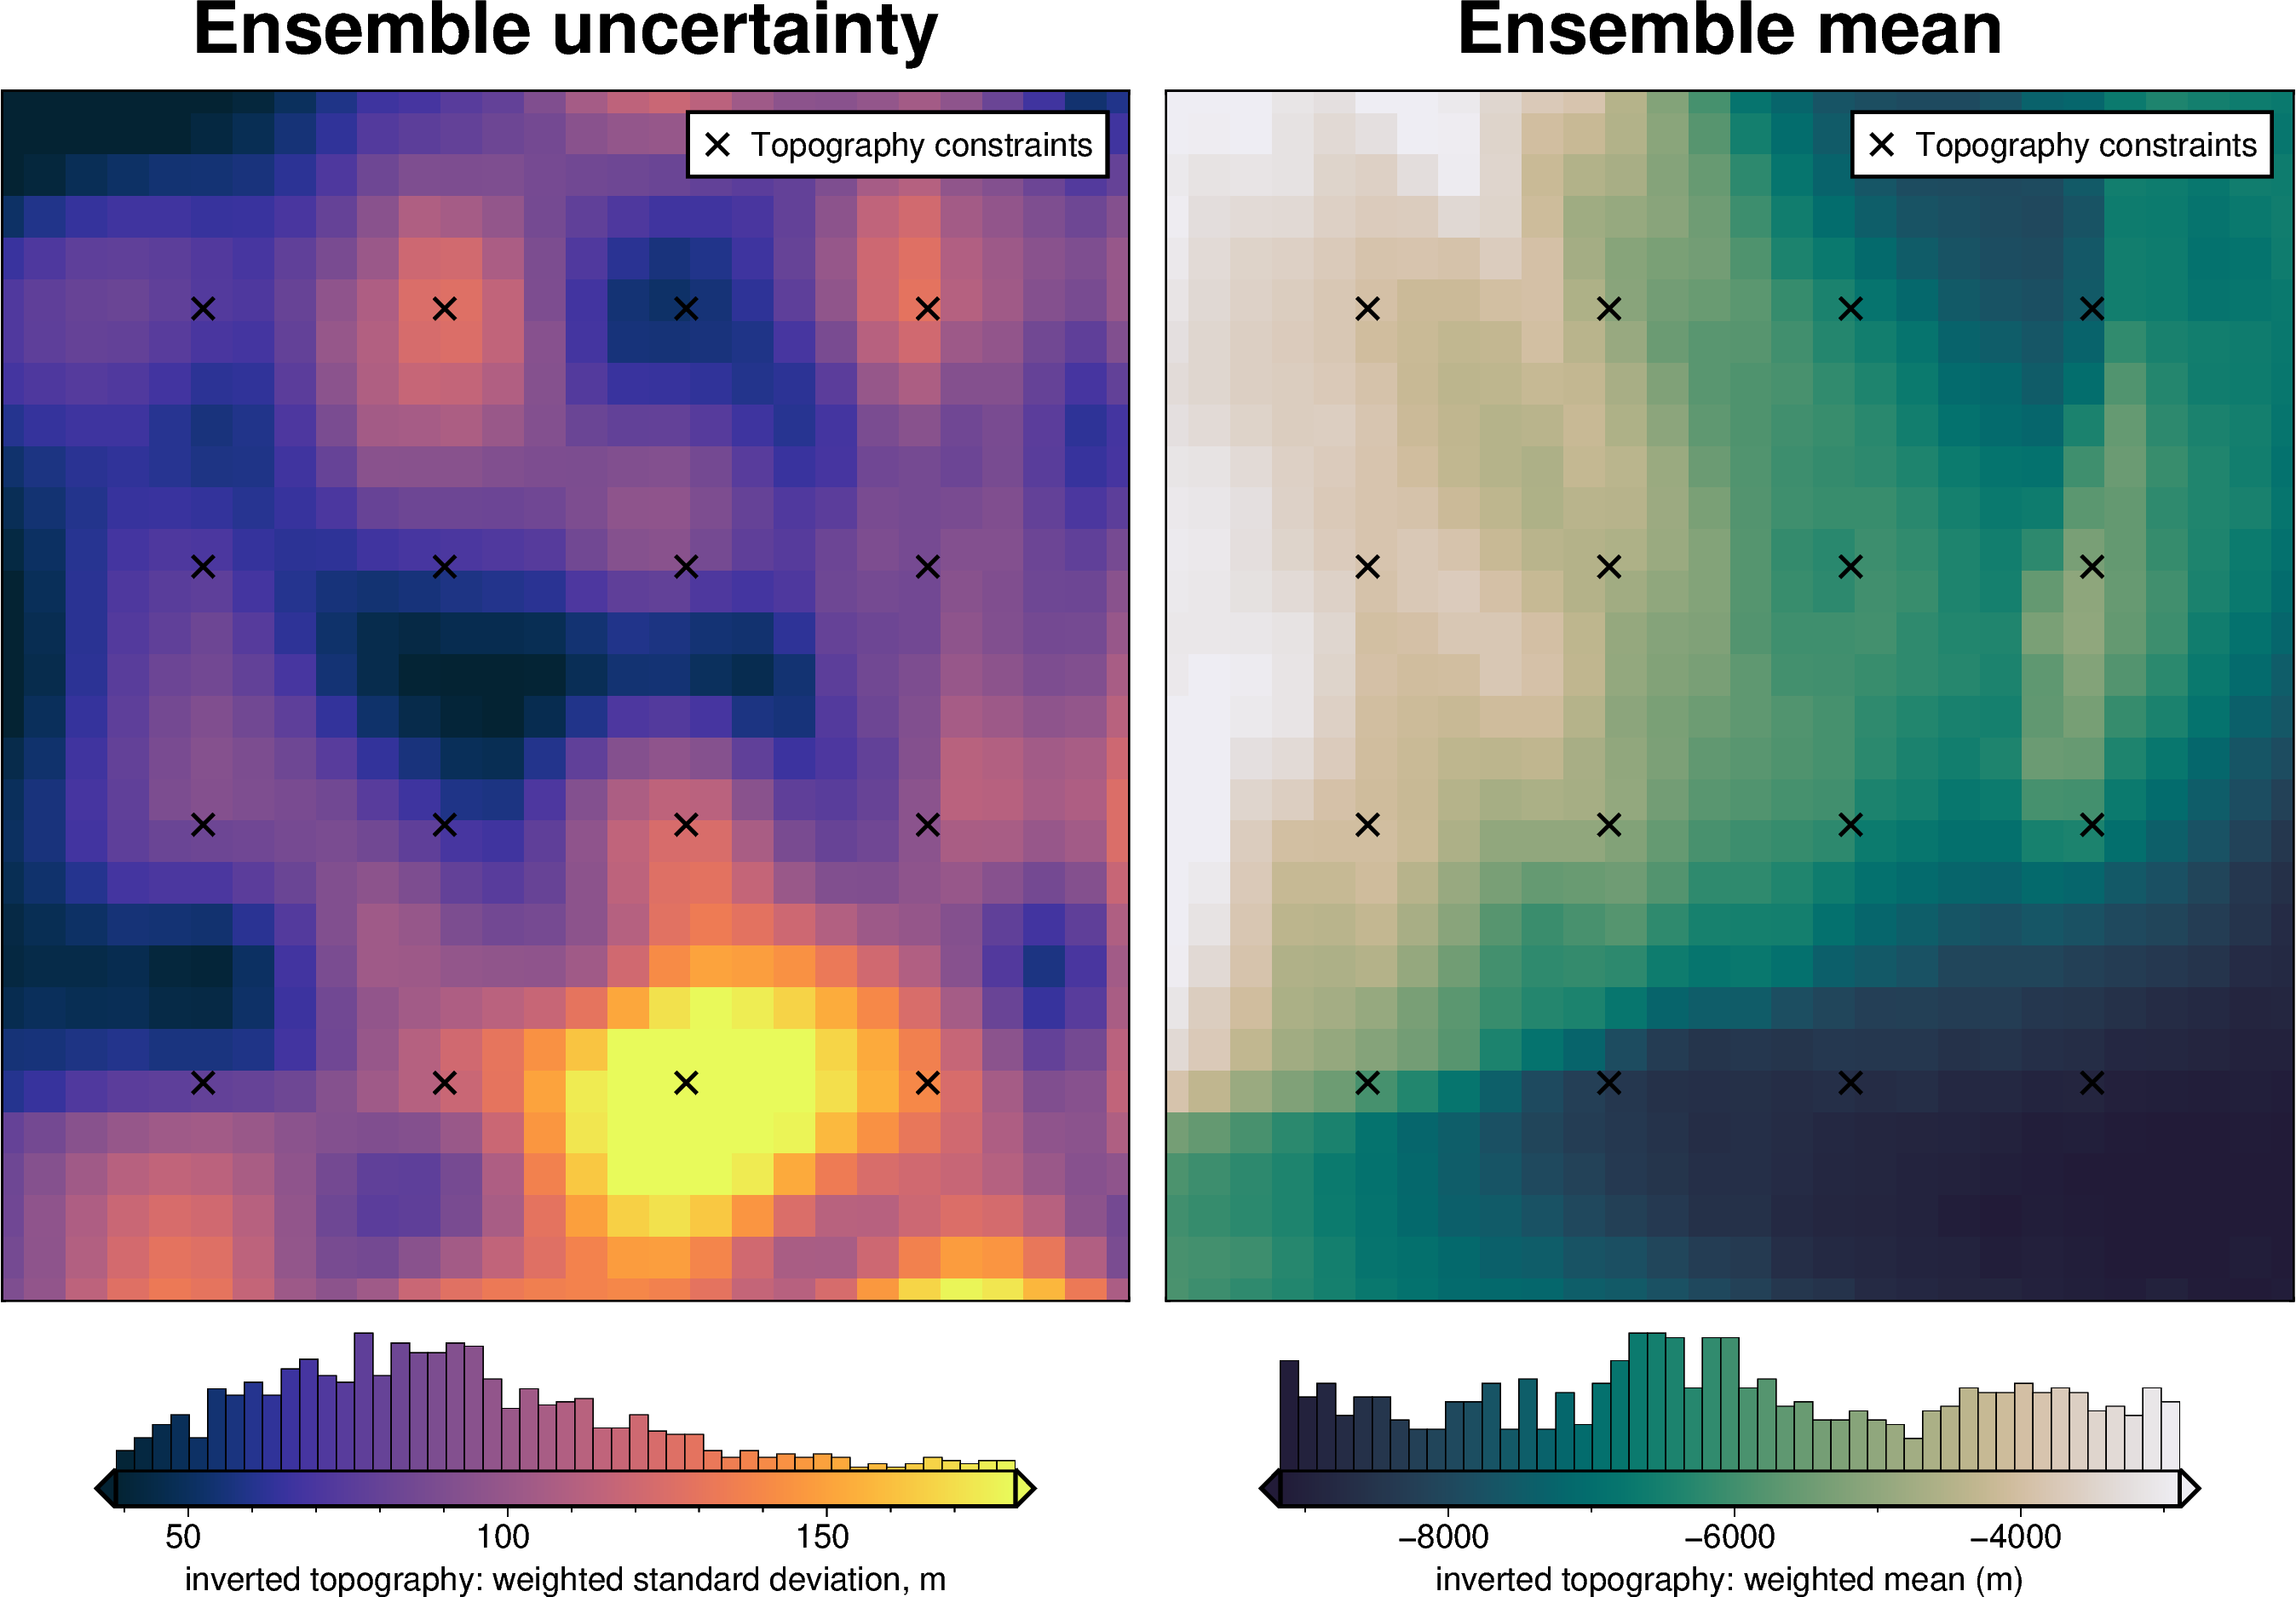

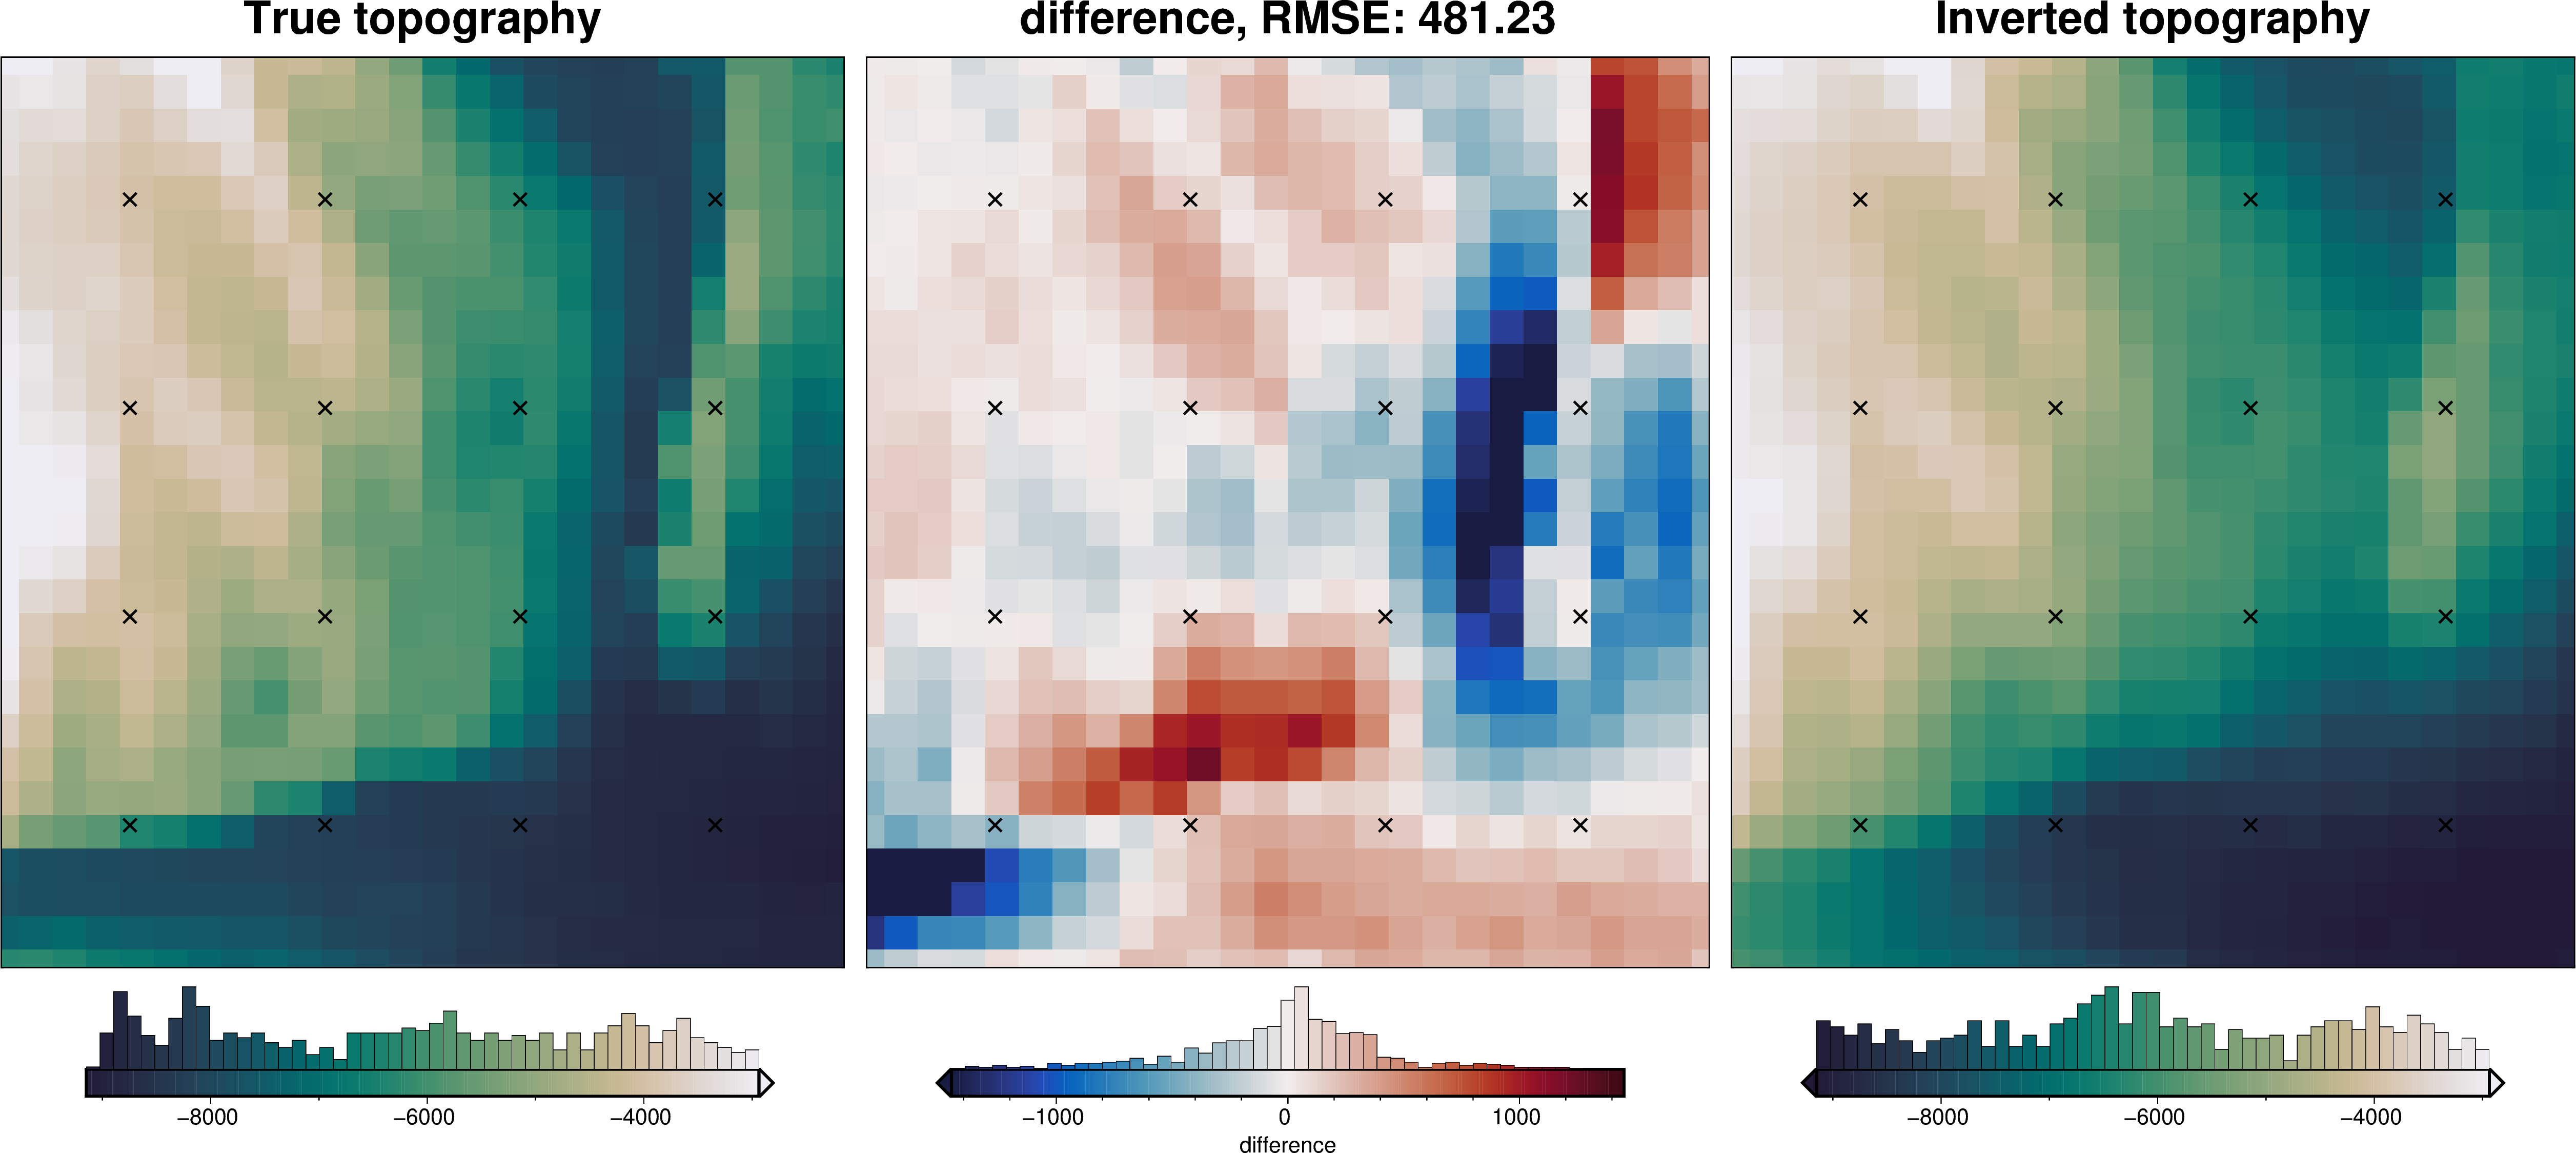

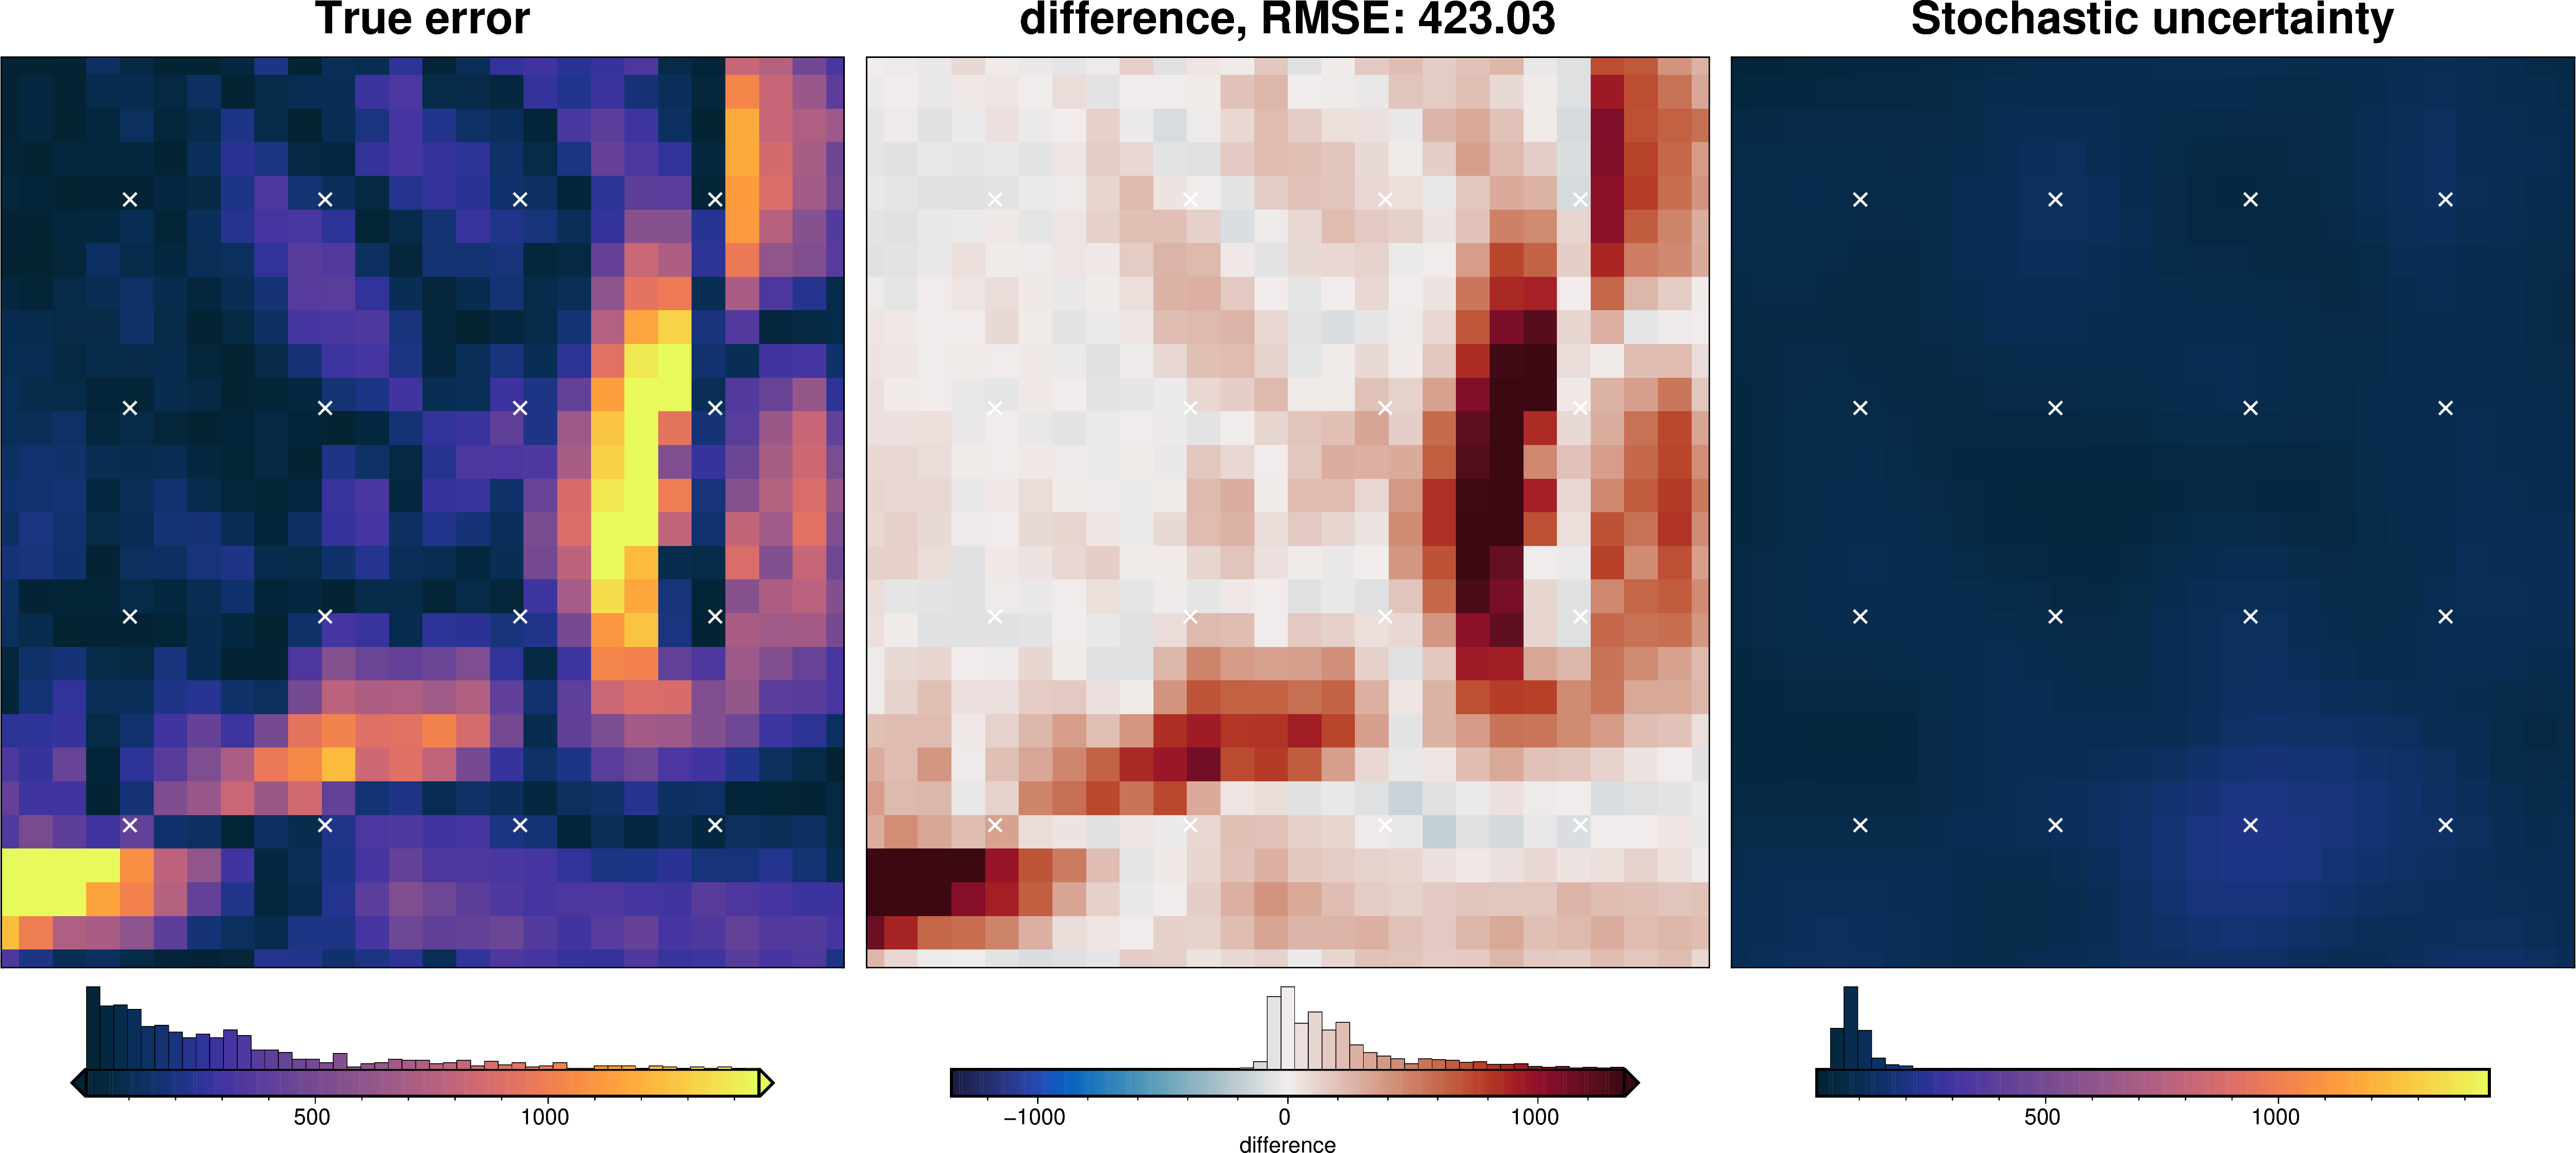

<xarray.Dataset> Size: 122kB
Dimensions:         (northing: 30, easting: 28, runs: 10)
Coordinates:
    top             (northing, easting) float64 7kB -5.851e+03 ... -6.087e+03
    bottom          (northing, easting) float64 7kB -6.087e+03 ... -6.695e+03
  * northing        (northing) float64 240B 1.959e+05 2.059e+05 ... 4.859e+05
  * easting         (easting) float64 224B 5.69e+04 6.69e+04 ... 3.269e+05
  * runs            (runs) <U5 200B 'run_0' 'run_1' 'run_2' ... 'run_8' 'run_9'
Data variables:
    run_num         (runs, northing, easting) float64 67kB -5.851e+03 ... -6....
    z_mean          (northing, easting) float64 7kB -5.897e+03 ... -6.706e+03
    z_stdev         (northing, easting) float64 7kB 99.44 107.1 ... 54.9 61.86
    weighted_mean   (northing, easting) float64 7kB -5.897e+03 ... -6.714e+03
    weighted_stdev  (northing, easting) float64 7kB 90.02 97.59 ... 53.75 59.08
    z_min           (northing, easting) float64 7kB -6.072e+03 ... -6.804e+03
    z_max           (northing, easting) float64 7kB -5.701e+03 ... -6.586e+03

In [52]:
fname = "../tmp/bishop_model_uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = invert4geom.full_workflow_uncertainty_loop(
    optimal_inv,
    fname=fname,
    runs=10,
    sample_constraints=True,
    constraints_df=constraint_points,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

uncert_plots(
    uncert_constraints_results,
    optimal_inv.data.inner_region,
    optimal_inv.data.spacing,
    grid.basement_topo,
    constraints_df=constraint_points,
    weight_by="constraints",
)

### Gravity component

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

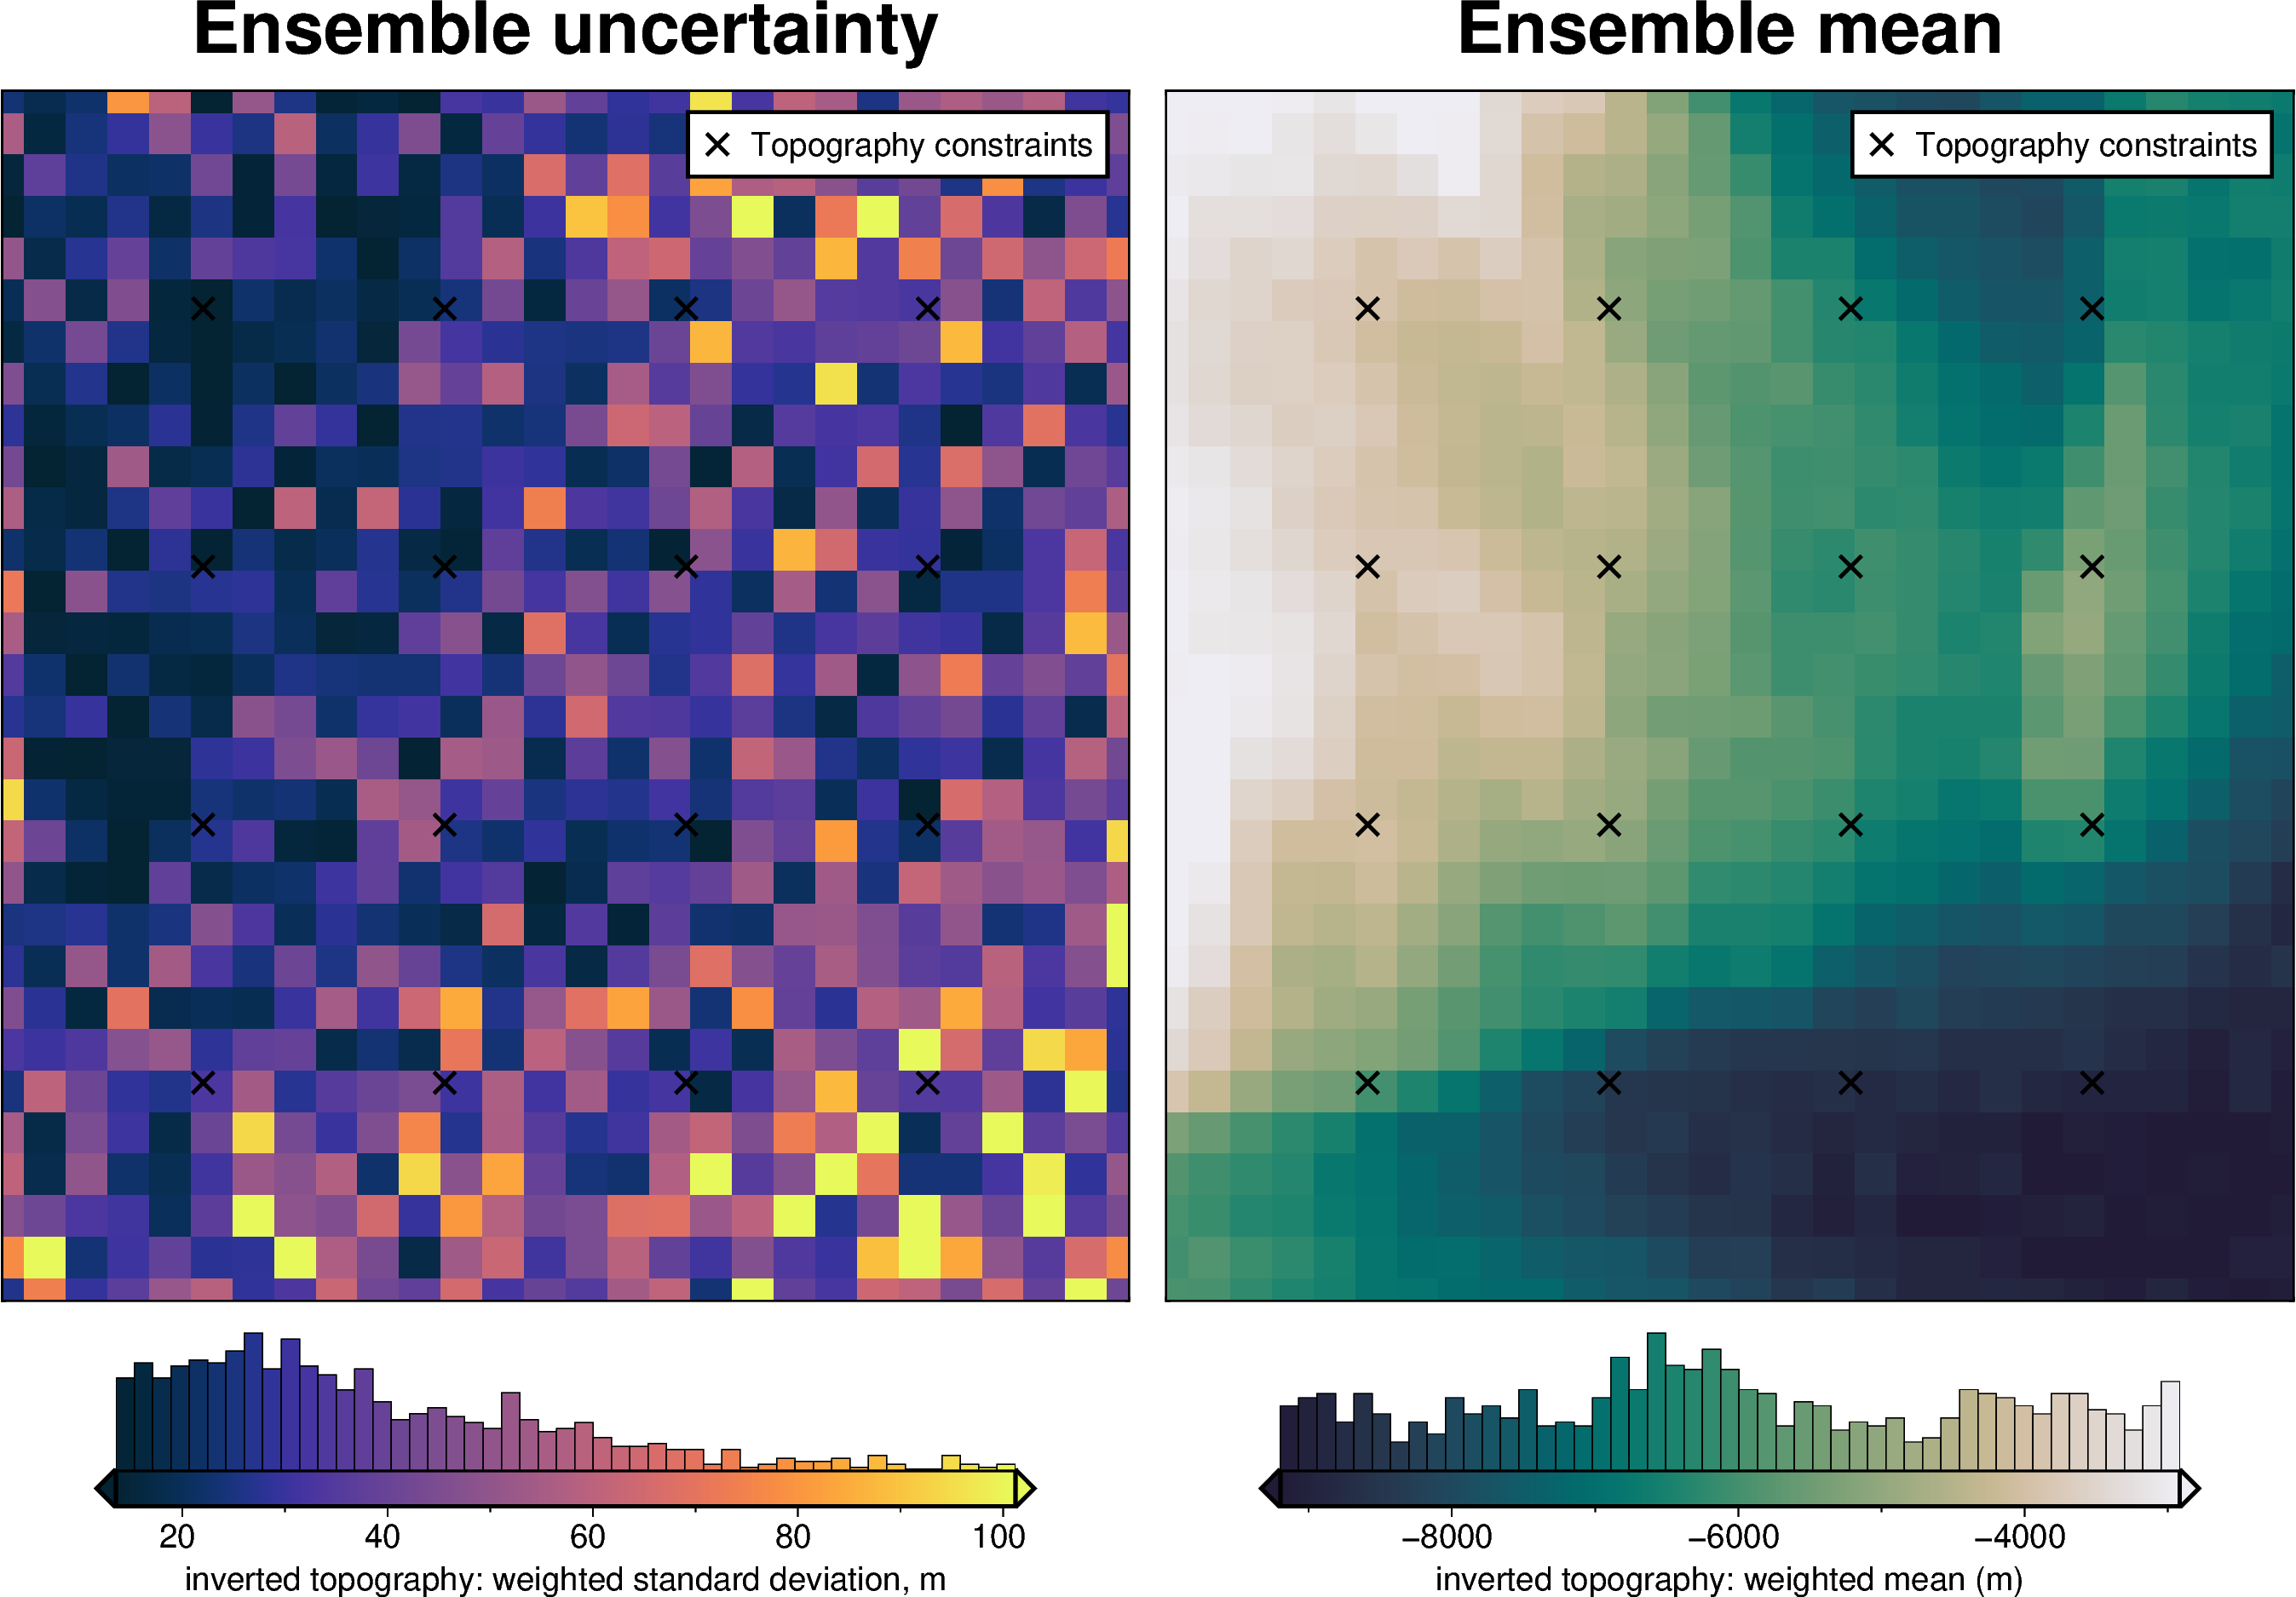

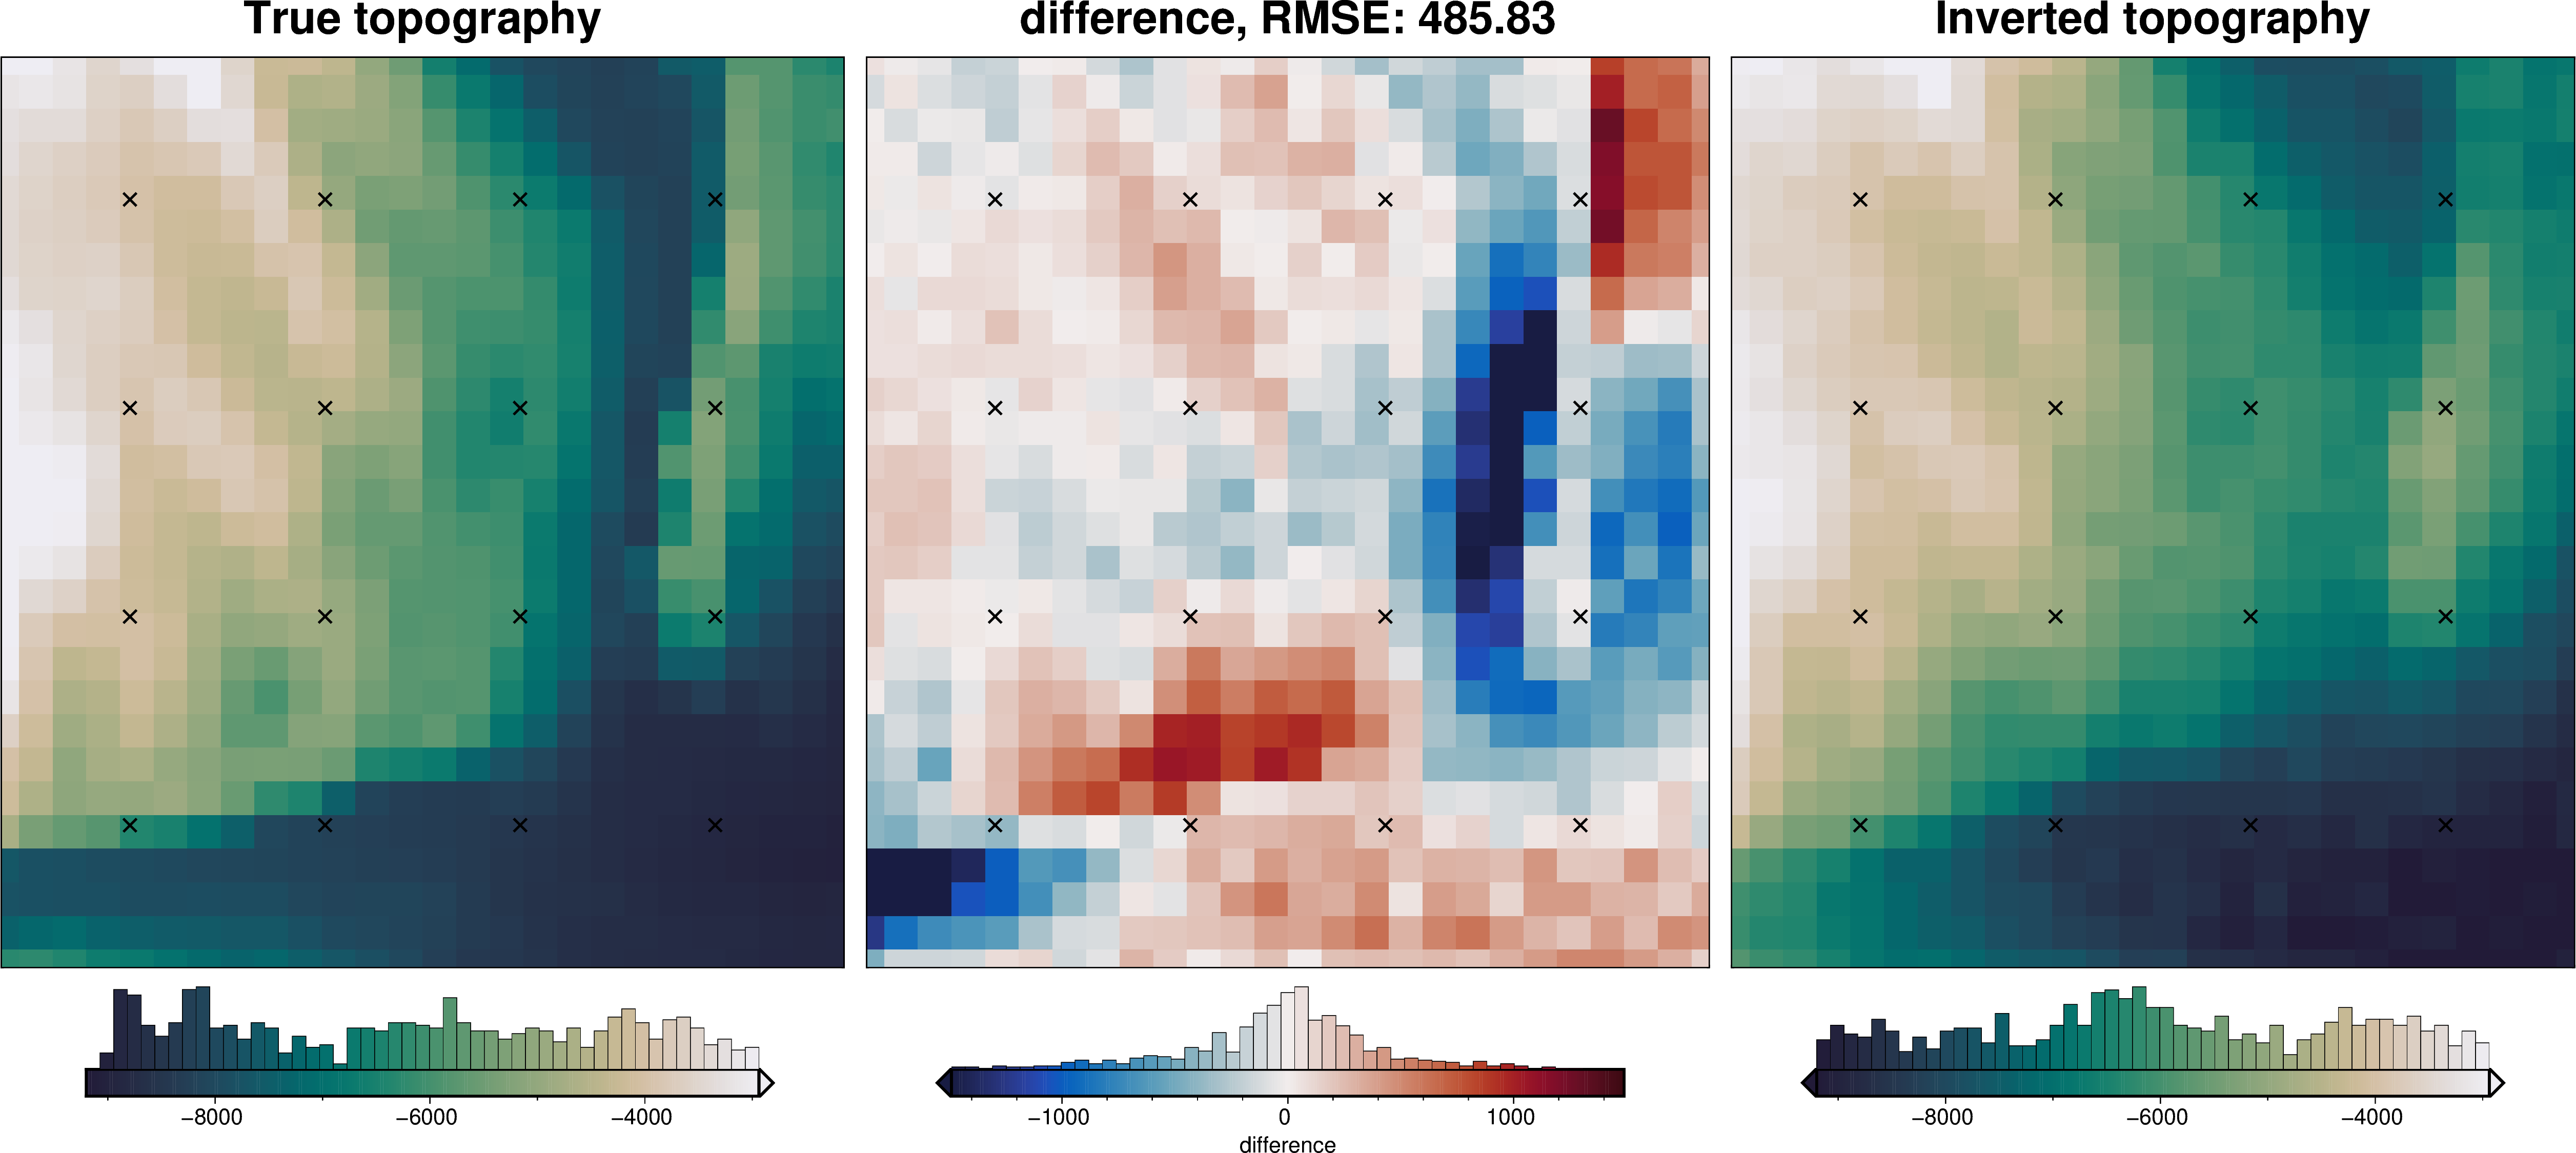

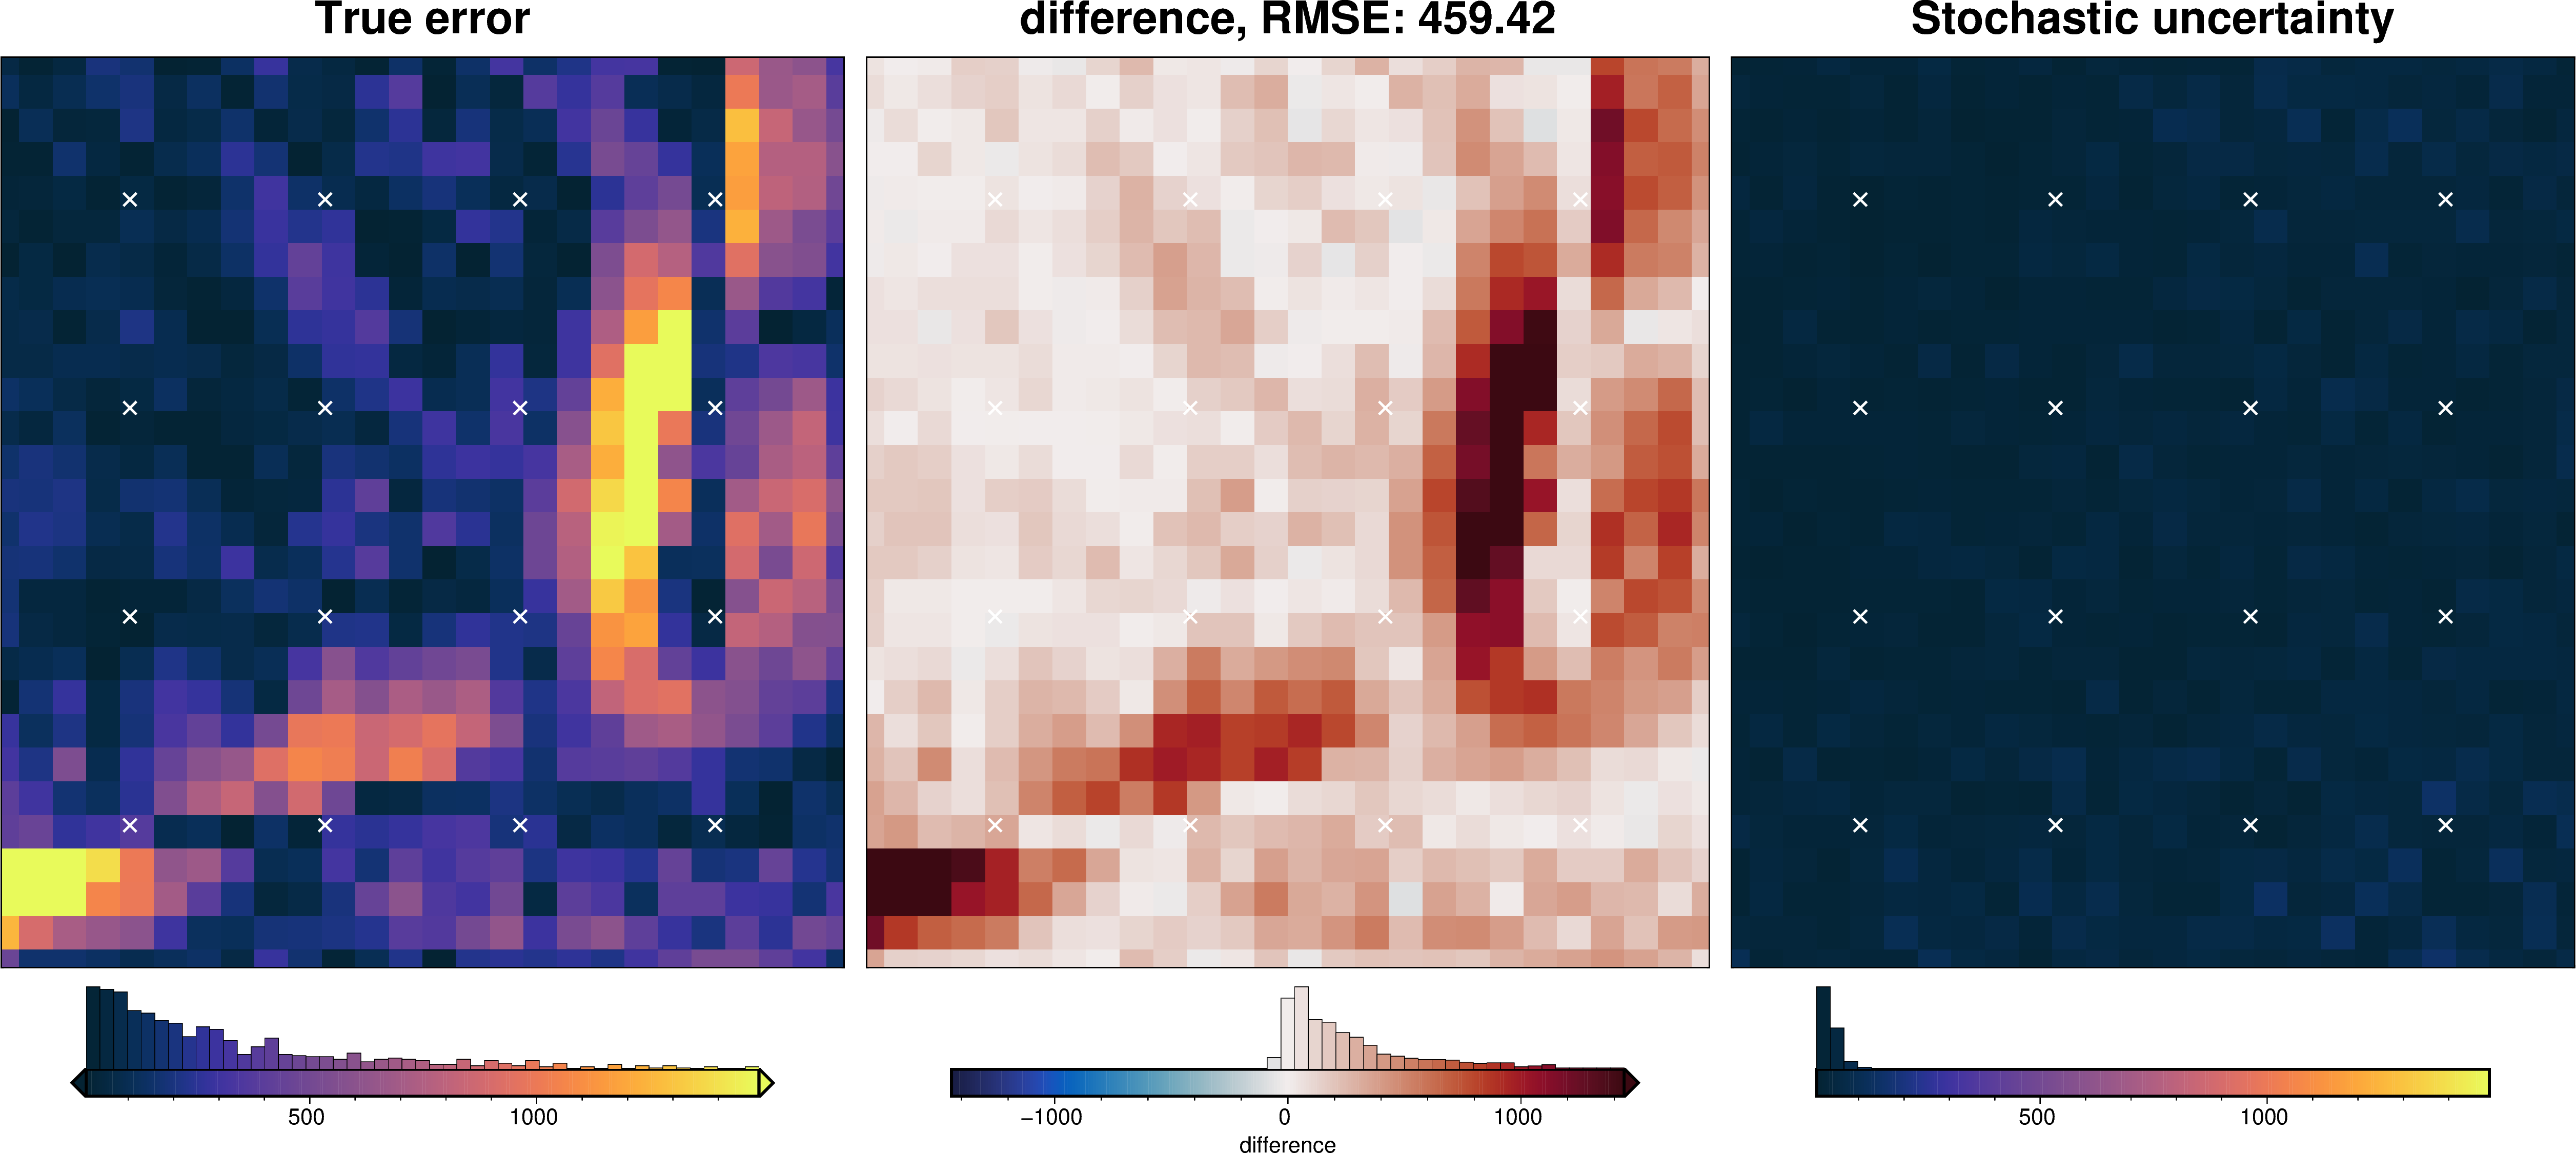

<xarray.Dataset> Size: 122kB
Dimensions:         (northing: 30, easting: 28, runs: 10)
Coordinates:
    top             (northing, easting) float64 7kB -5.915e+03 ... -6.087e+03
    bottom          (northing, easting) float64 7kB -6.087e+03 ... -6.728e+03
  * northing        (northing) float64 240B 1.959e+05 2.059e+05 ... 4.859e+05
  * easting         (easting) float64 224B 5.69e+04 6.69e+04 ... 3.269e+05
  * runs            (runs) <U5 200B 'run_0' 'run_1' 'run_2' ... 'run_8' 'run_9'
Data variables:
    run_num         (runs, northing, easting) float64 67kB -5.915e+03 ... -6....
    z_mean          (northing, easting) float64 7kB -5.935e+03 ... -6.7e+03
    z_stdev         (northing, easting) float64 7kB 26.46 74.13 ... 31.1 29.34
    weighted_mean   (northing, easting) float64 7kB -5.934e+03 ... -6.701e+03
    weighted_stdev  (northing, easting) float64 7kB 26.46 74.0 ... 31.14 29.43
    z_min           (northing, easting) float64 7kB -5.979e+03 ... -6.74e+03
    z_max           (northing, easting) float64 7kB -5.897e+03 ... -6.655e+03

In [53]:
fname = "../tmp/bishop_model_uncertainty_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = invert4geom.full_workflow_uncertainty_loop(
    optimal_inv,
    fname=fname,
    runs=10,
    sample_gravity=True,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

uncert_plots(
    uncert_grav_results,
    optimal_inv.data.inner_region,
    optimal_inv.data.spacing,
    grid.basement_topo,
    constraints_df=constraint_points,
    weight_by="constraints",
)

### Regional field estimation uncertainty

We will do the same thing for the regional estimation procedure. First we will re-separate the regional to see what equivalent source gridding parameter values were determined optimal. We then estimate an uncertainty distribution for these parameter values, and create an ensemble of regional models which each randomly sample both the parameter values and the gravity data. 

In [54]:
mean_constraint_spacing, reg_eq_depth, reg_eq_damping

(np.float64(58000.0), 109845.53034995627, 5.92021021304295e-40)

In [55]:
np.abs(np.log10(reg_eq_damping))

np.float64(39.22766287220551)

starting regional ensemble:   0%|          | 0/100 [00:00<?, ?it/s]

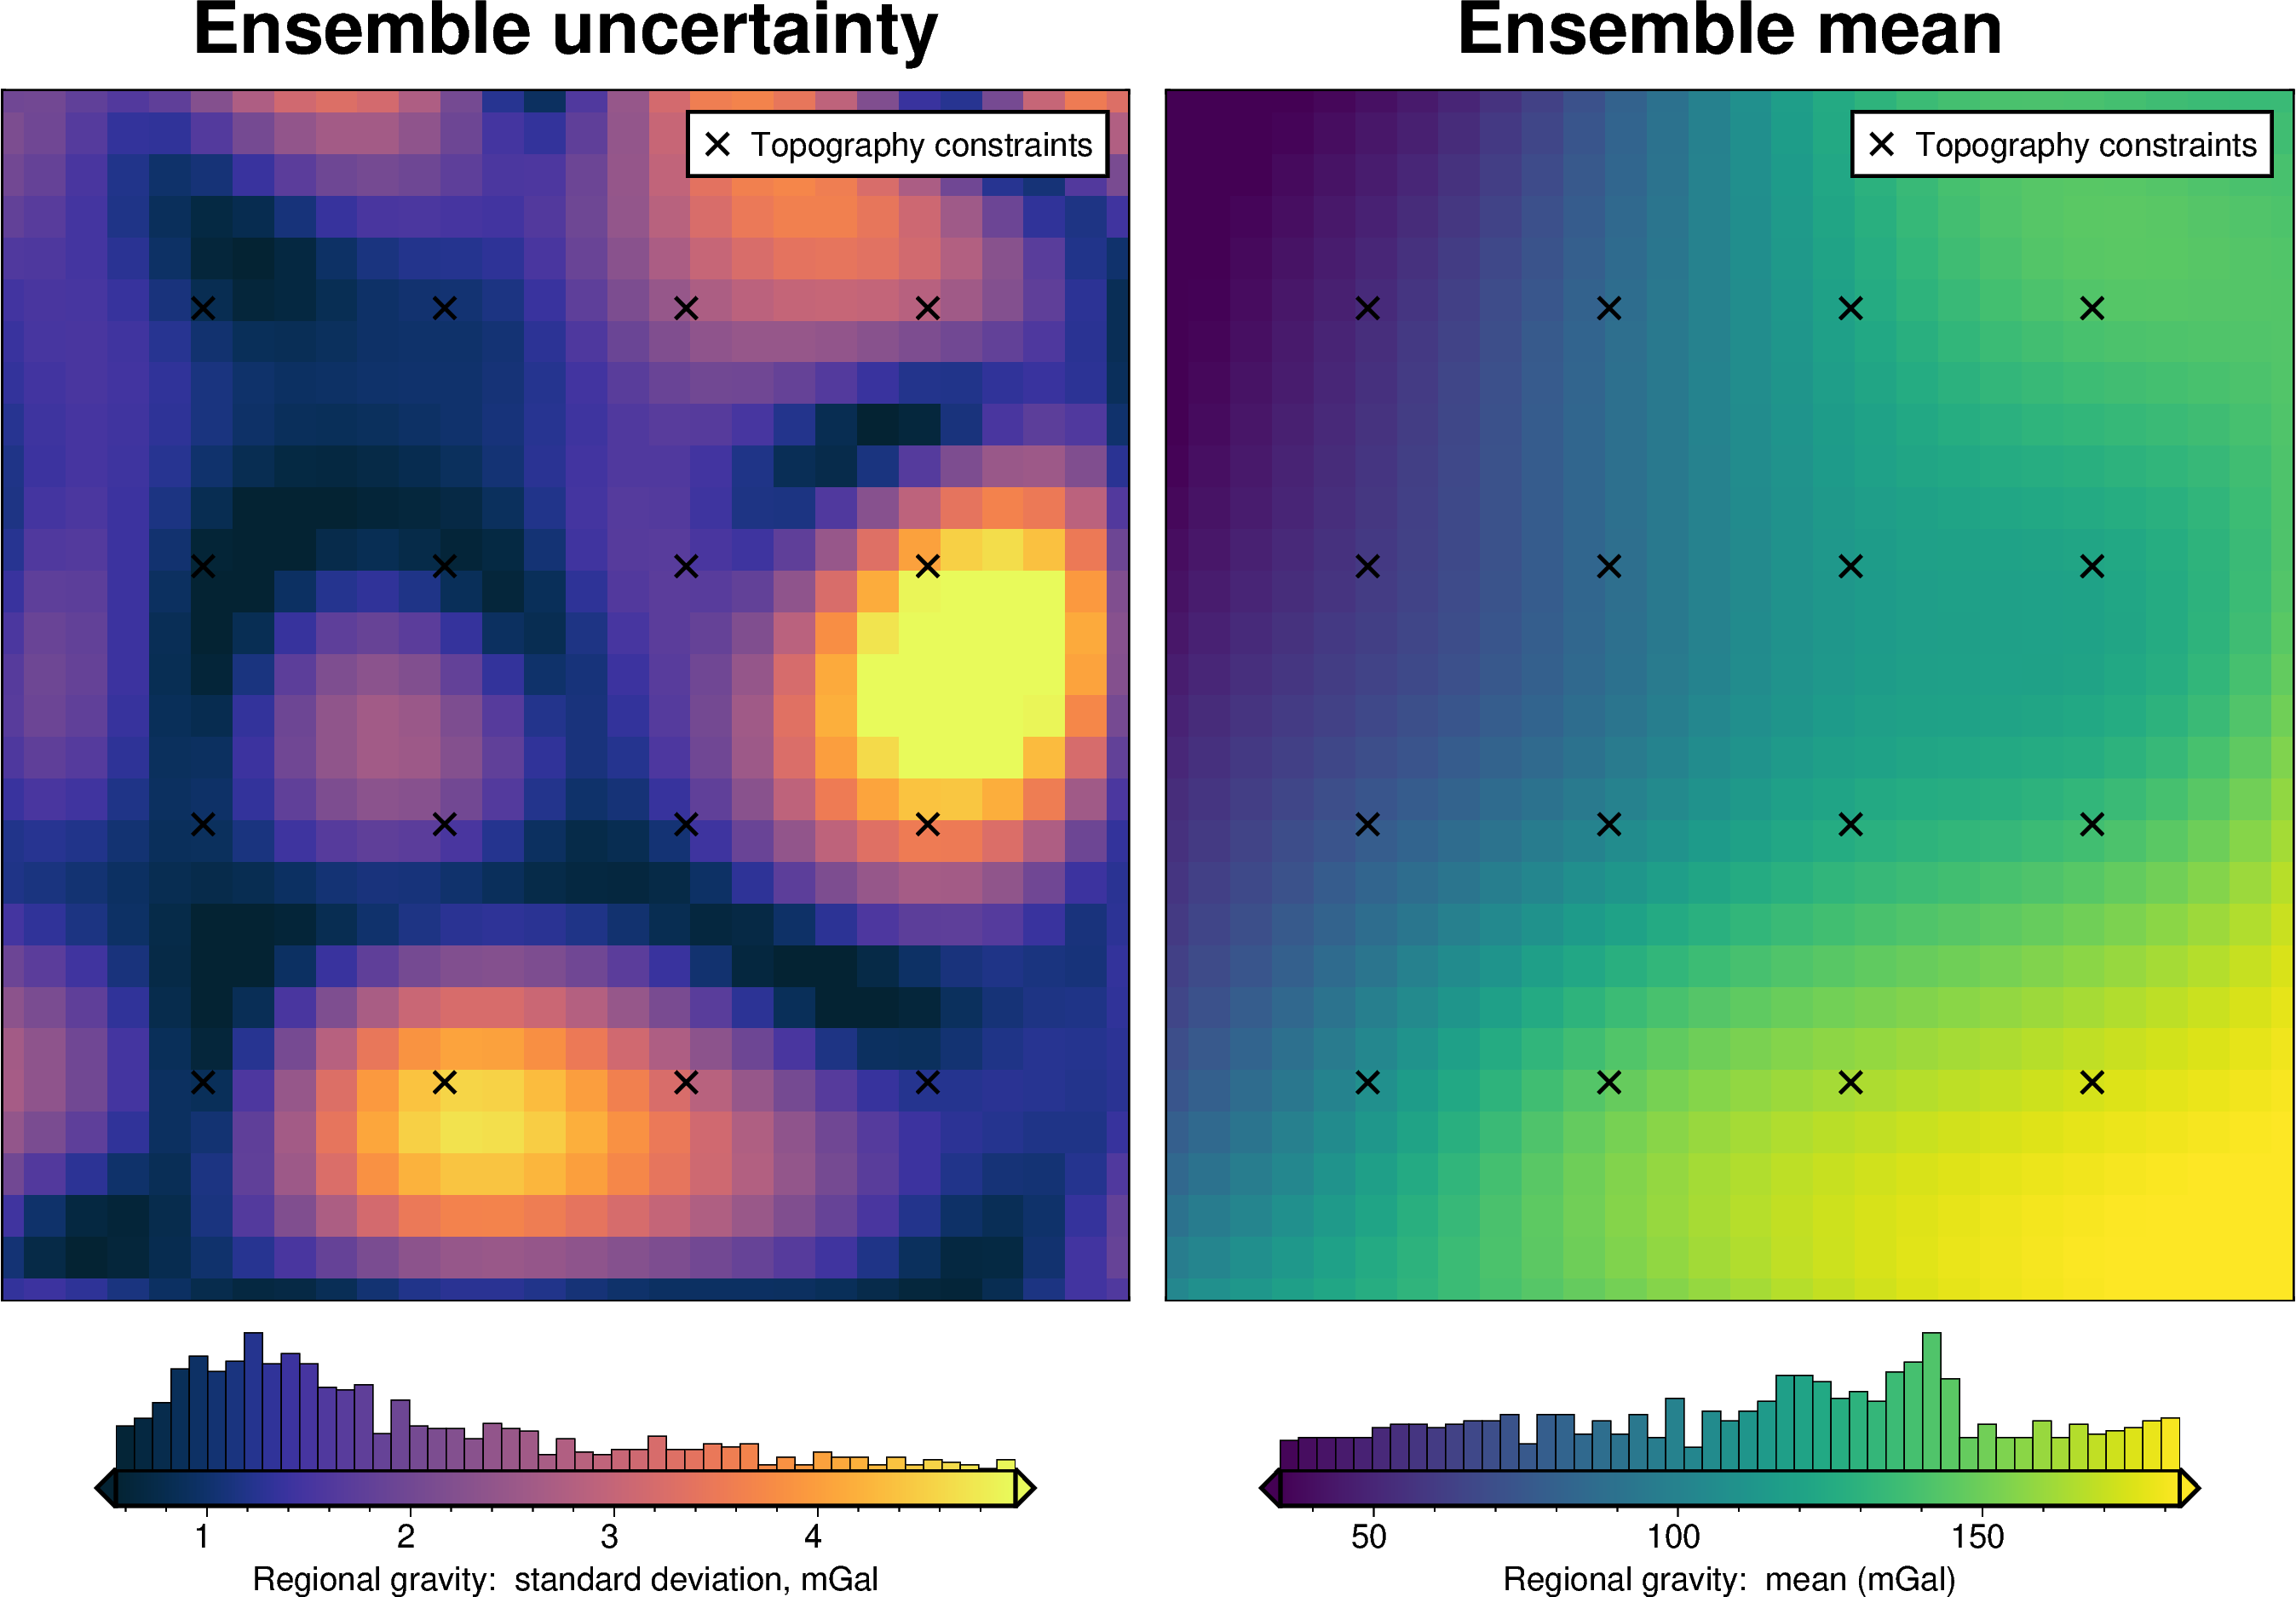

In [56]:
regional_misfit_parameter_dict = {
    "depth": {
        "distribution": "uniform",
        "loc": 2 * mean_constraint_spacing,  # lower bound
        "scale": 5 * mean_constraint_spacing,  # range, 2+5=7
    },
    # "depth": {
    #     "distribution": "normal",
    #     "loc": reg_eq_depth,  # mean base 10 exponent
    #     "scale": reg_eq_depth / 5,  # standard deviation of exponent
    # },
    "damping": {
        "distribution": "uniform",
        "loc": np.log10(reg_eq_damping),
        "scale": np.abs(np.log10(reg_eq_damping)),
        # "scale": 2,
        "log": True,
    },
}

regional_misfit_stats, _ = invert4geom.regional_misfit_uncertainty(
    runs=100,
    parameter_dict=regional_misfit_parameter_dict,
    grav_ds=optimal_inv.data,
    region=optimal_inv.data.inner_region,
    **new_regional_grav_kwargs,
)

In [57]:
# update grav dataset
optimal_inv.data["reg_uncert"] = regional_misfit_stats.z_stdev

### Regional gravity component

stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

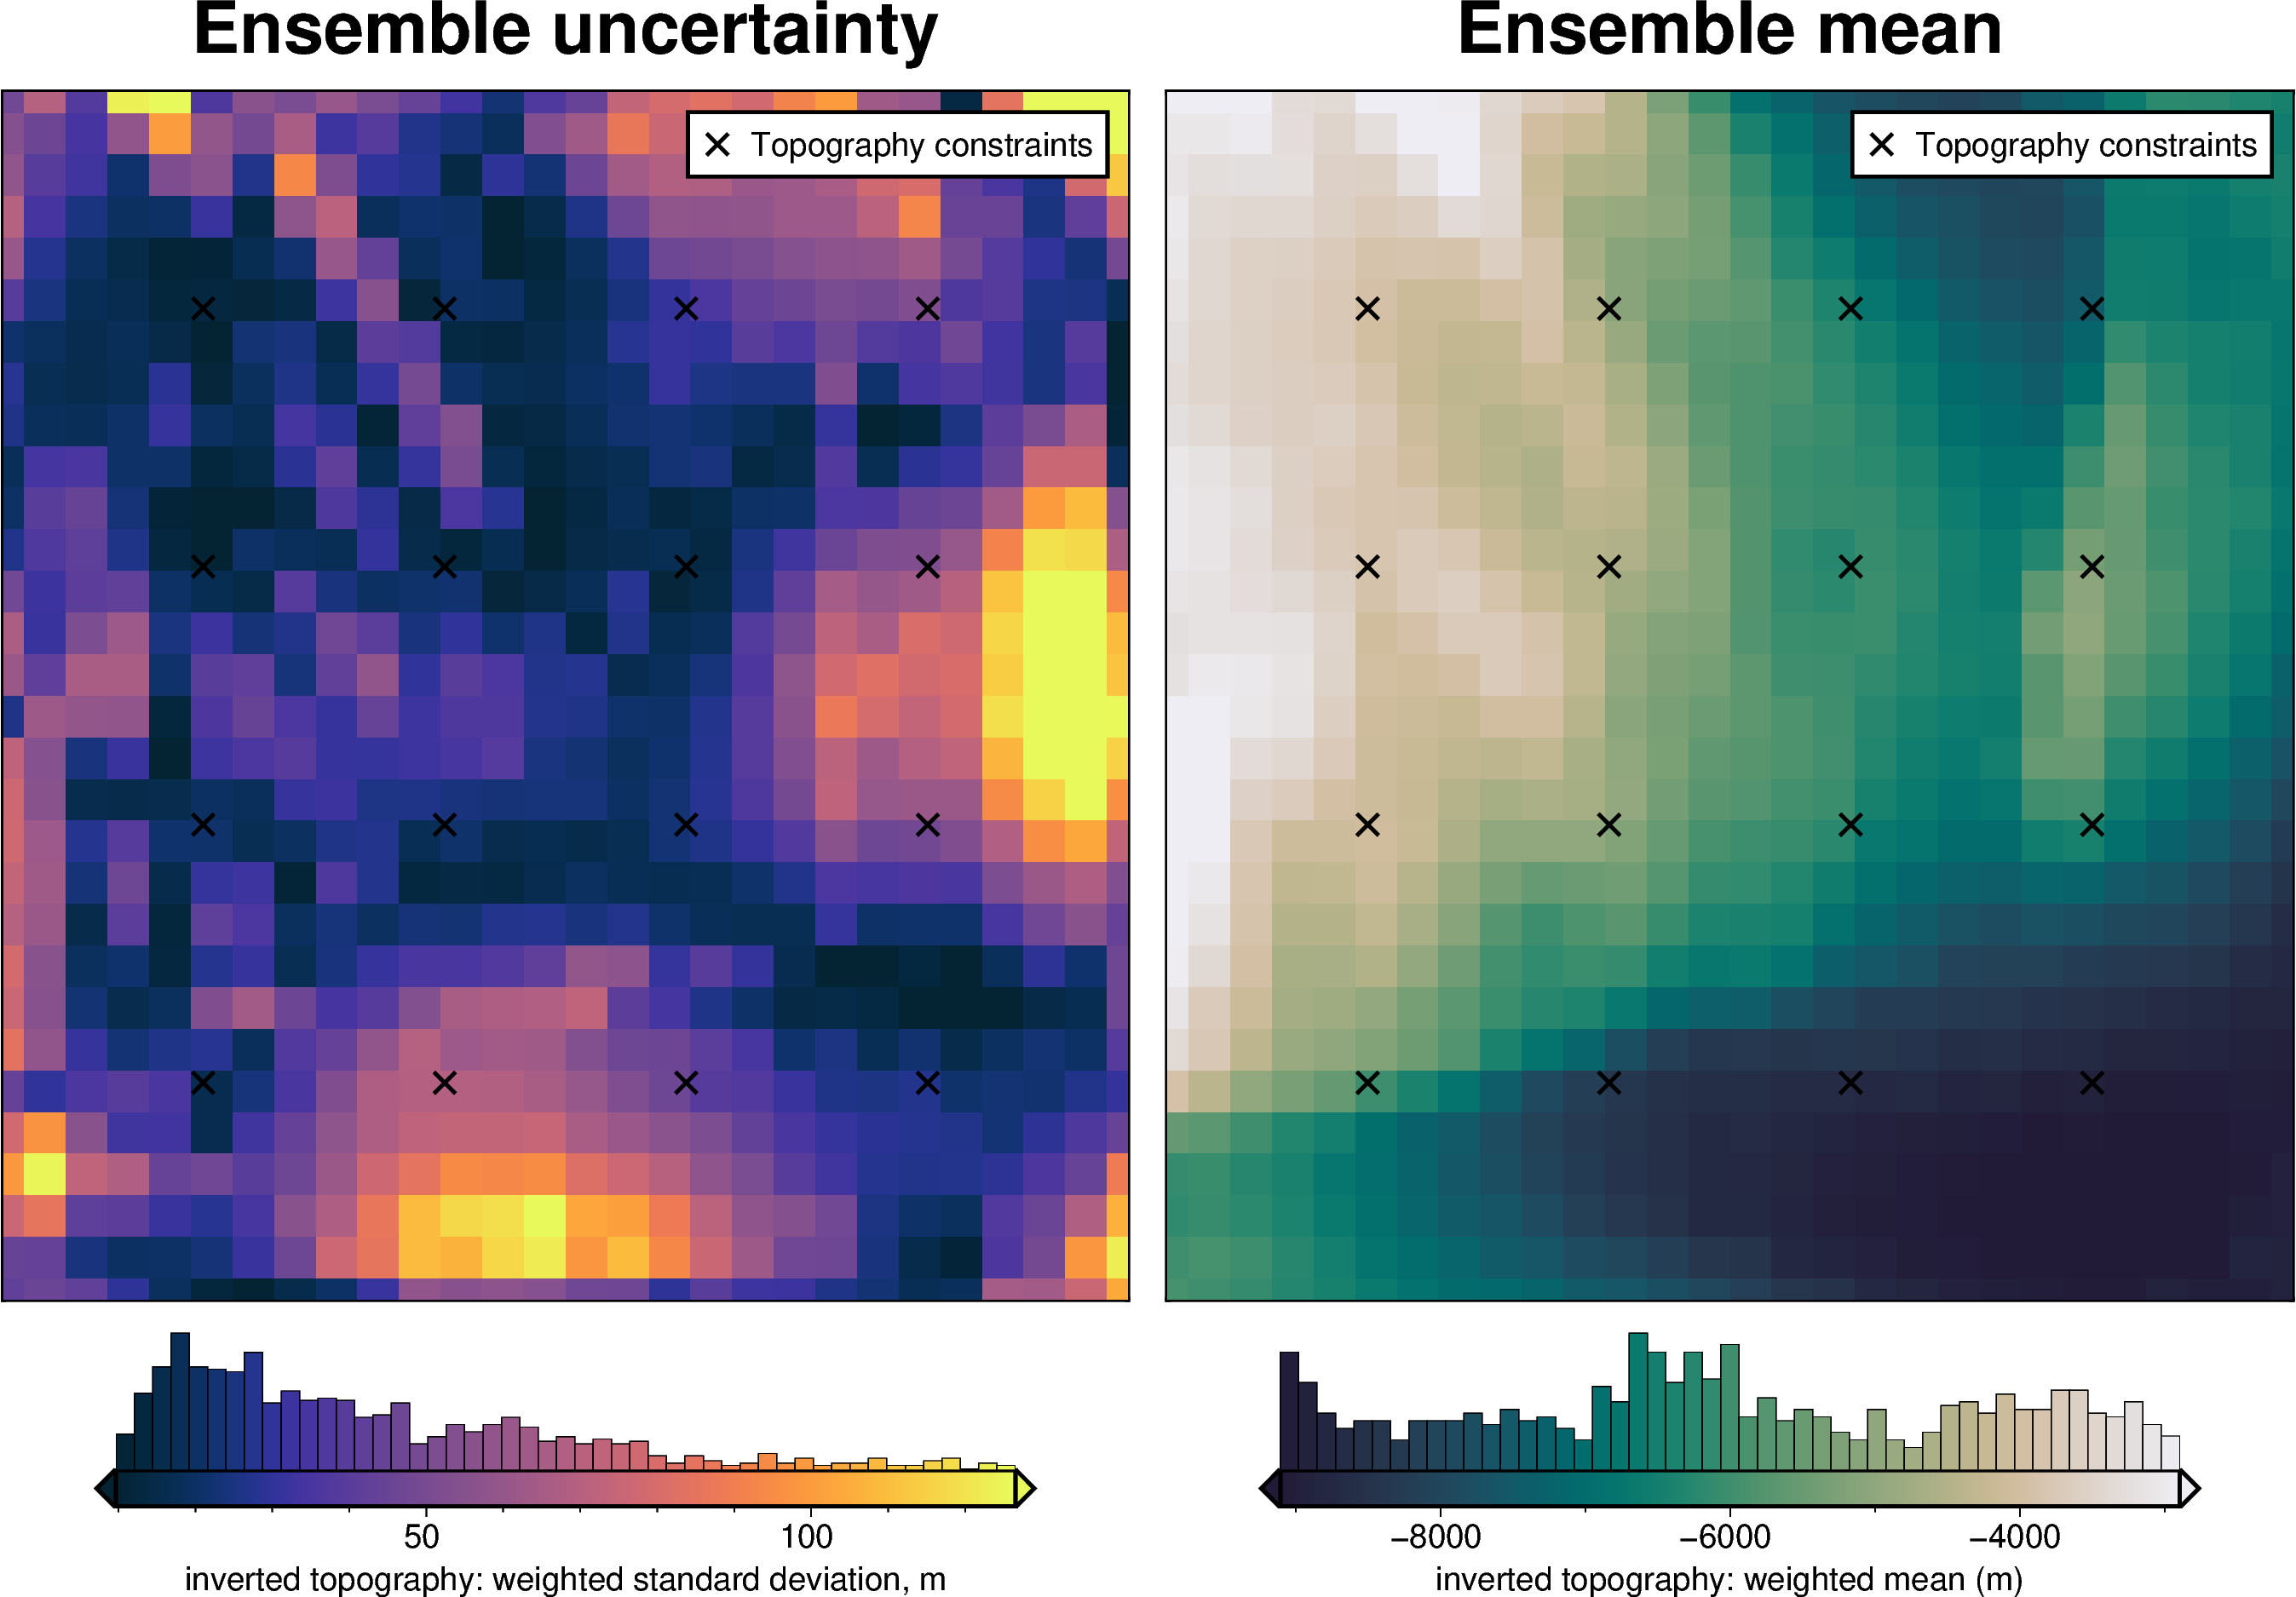

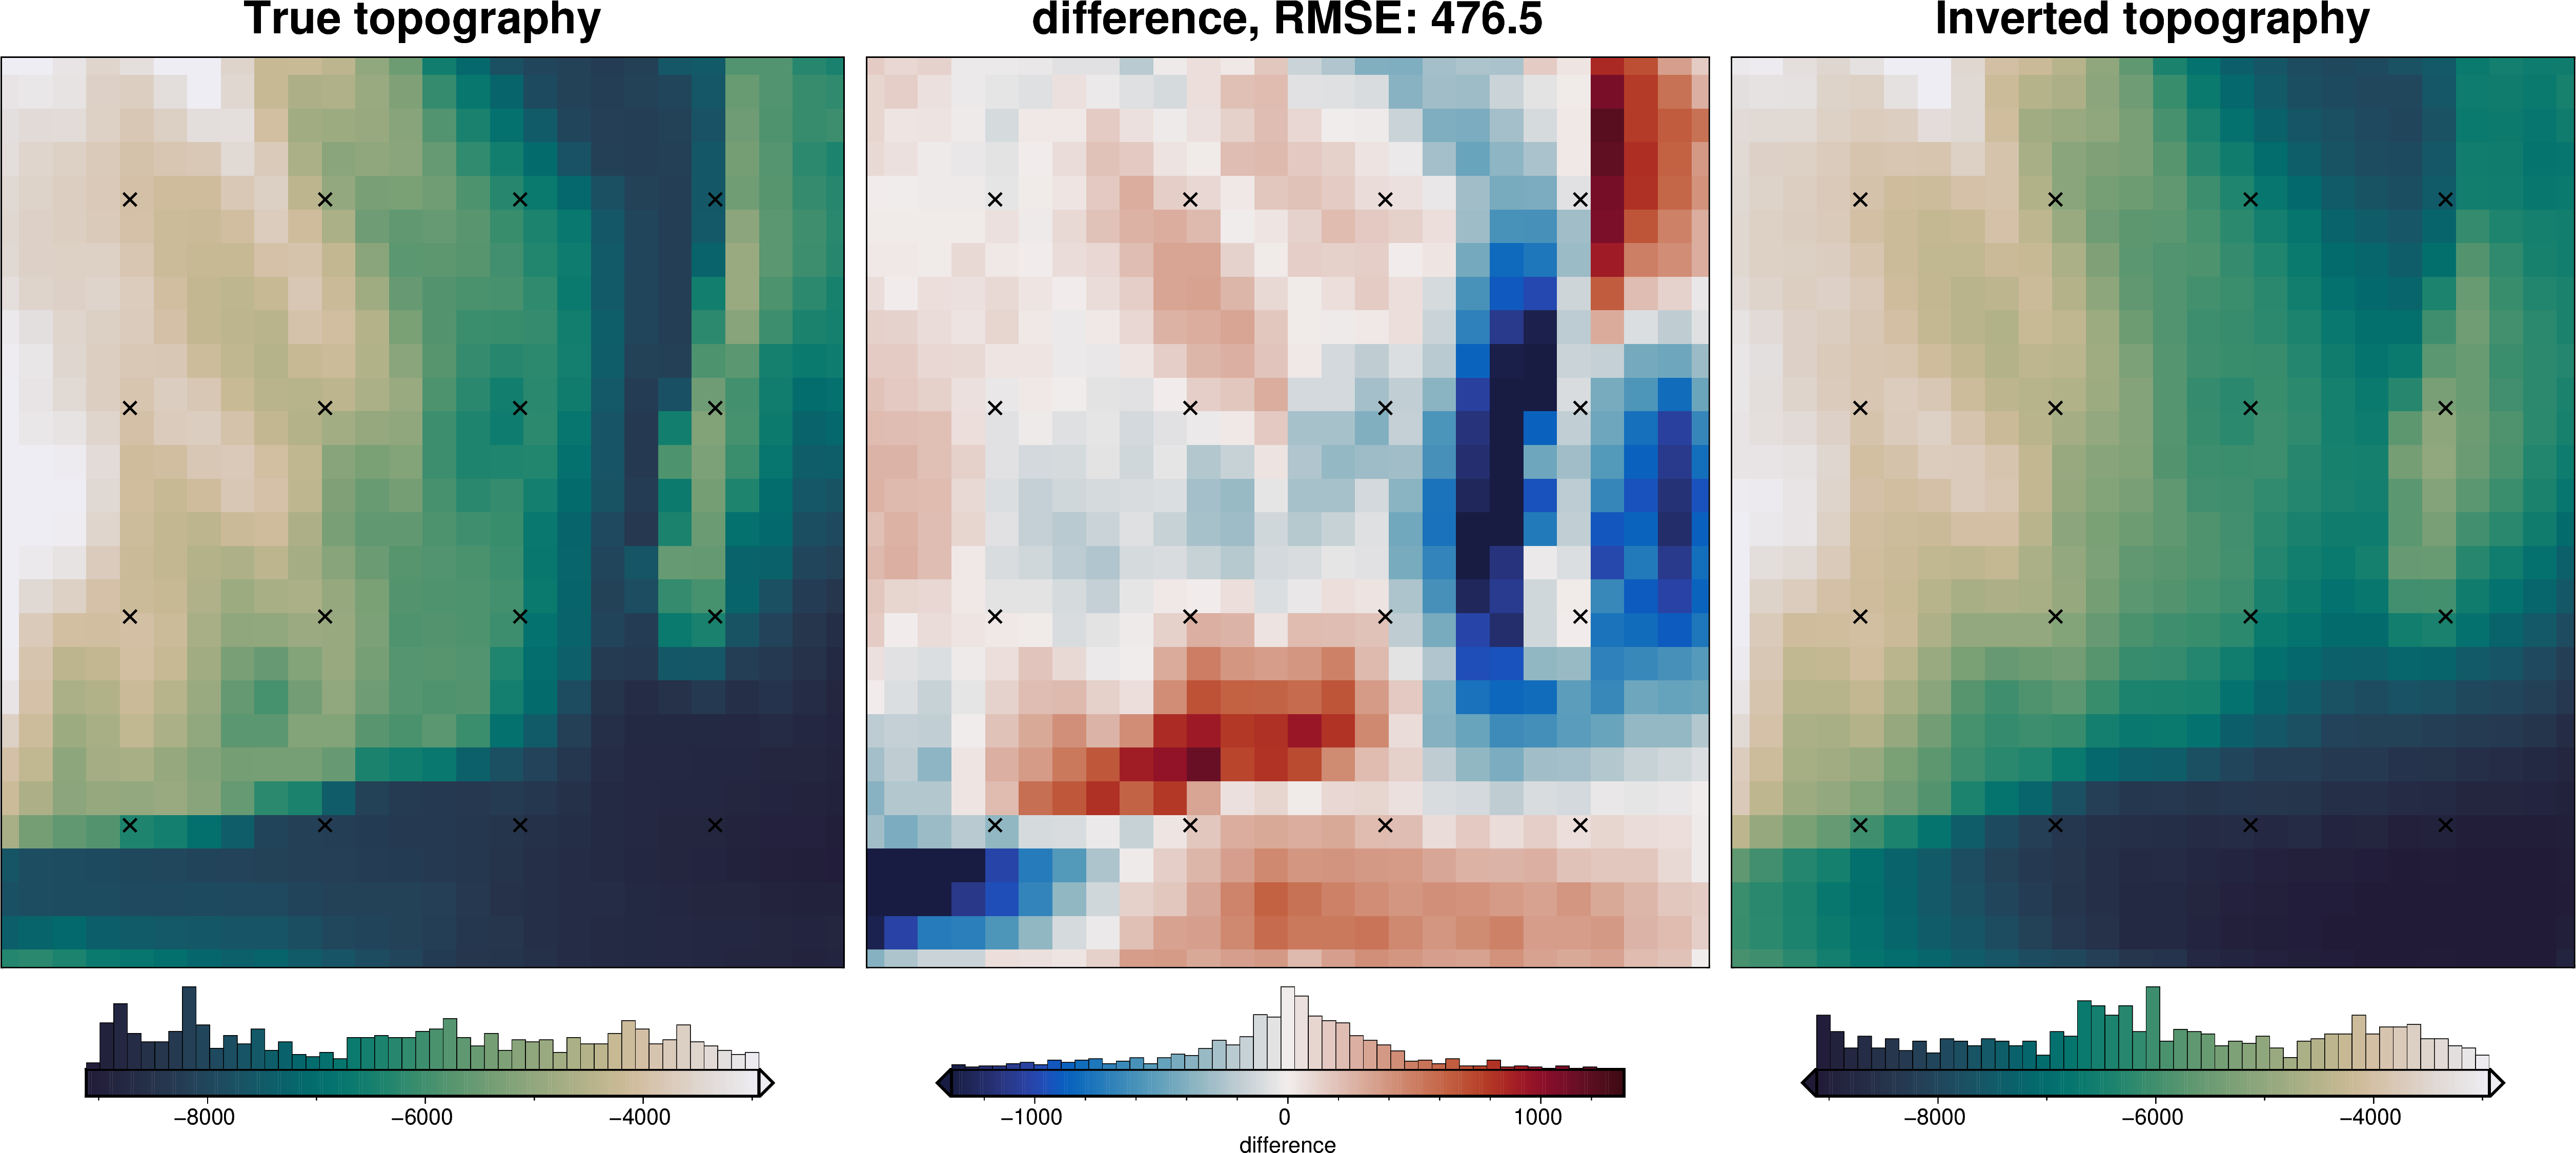

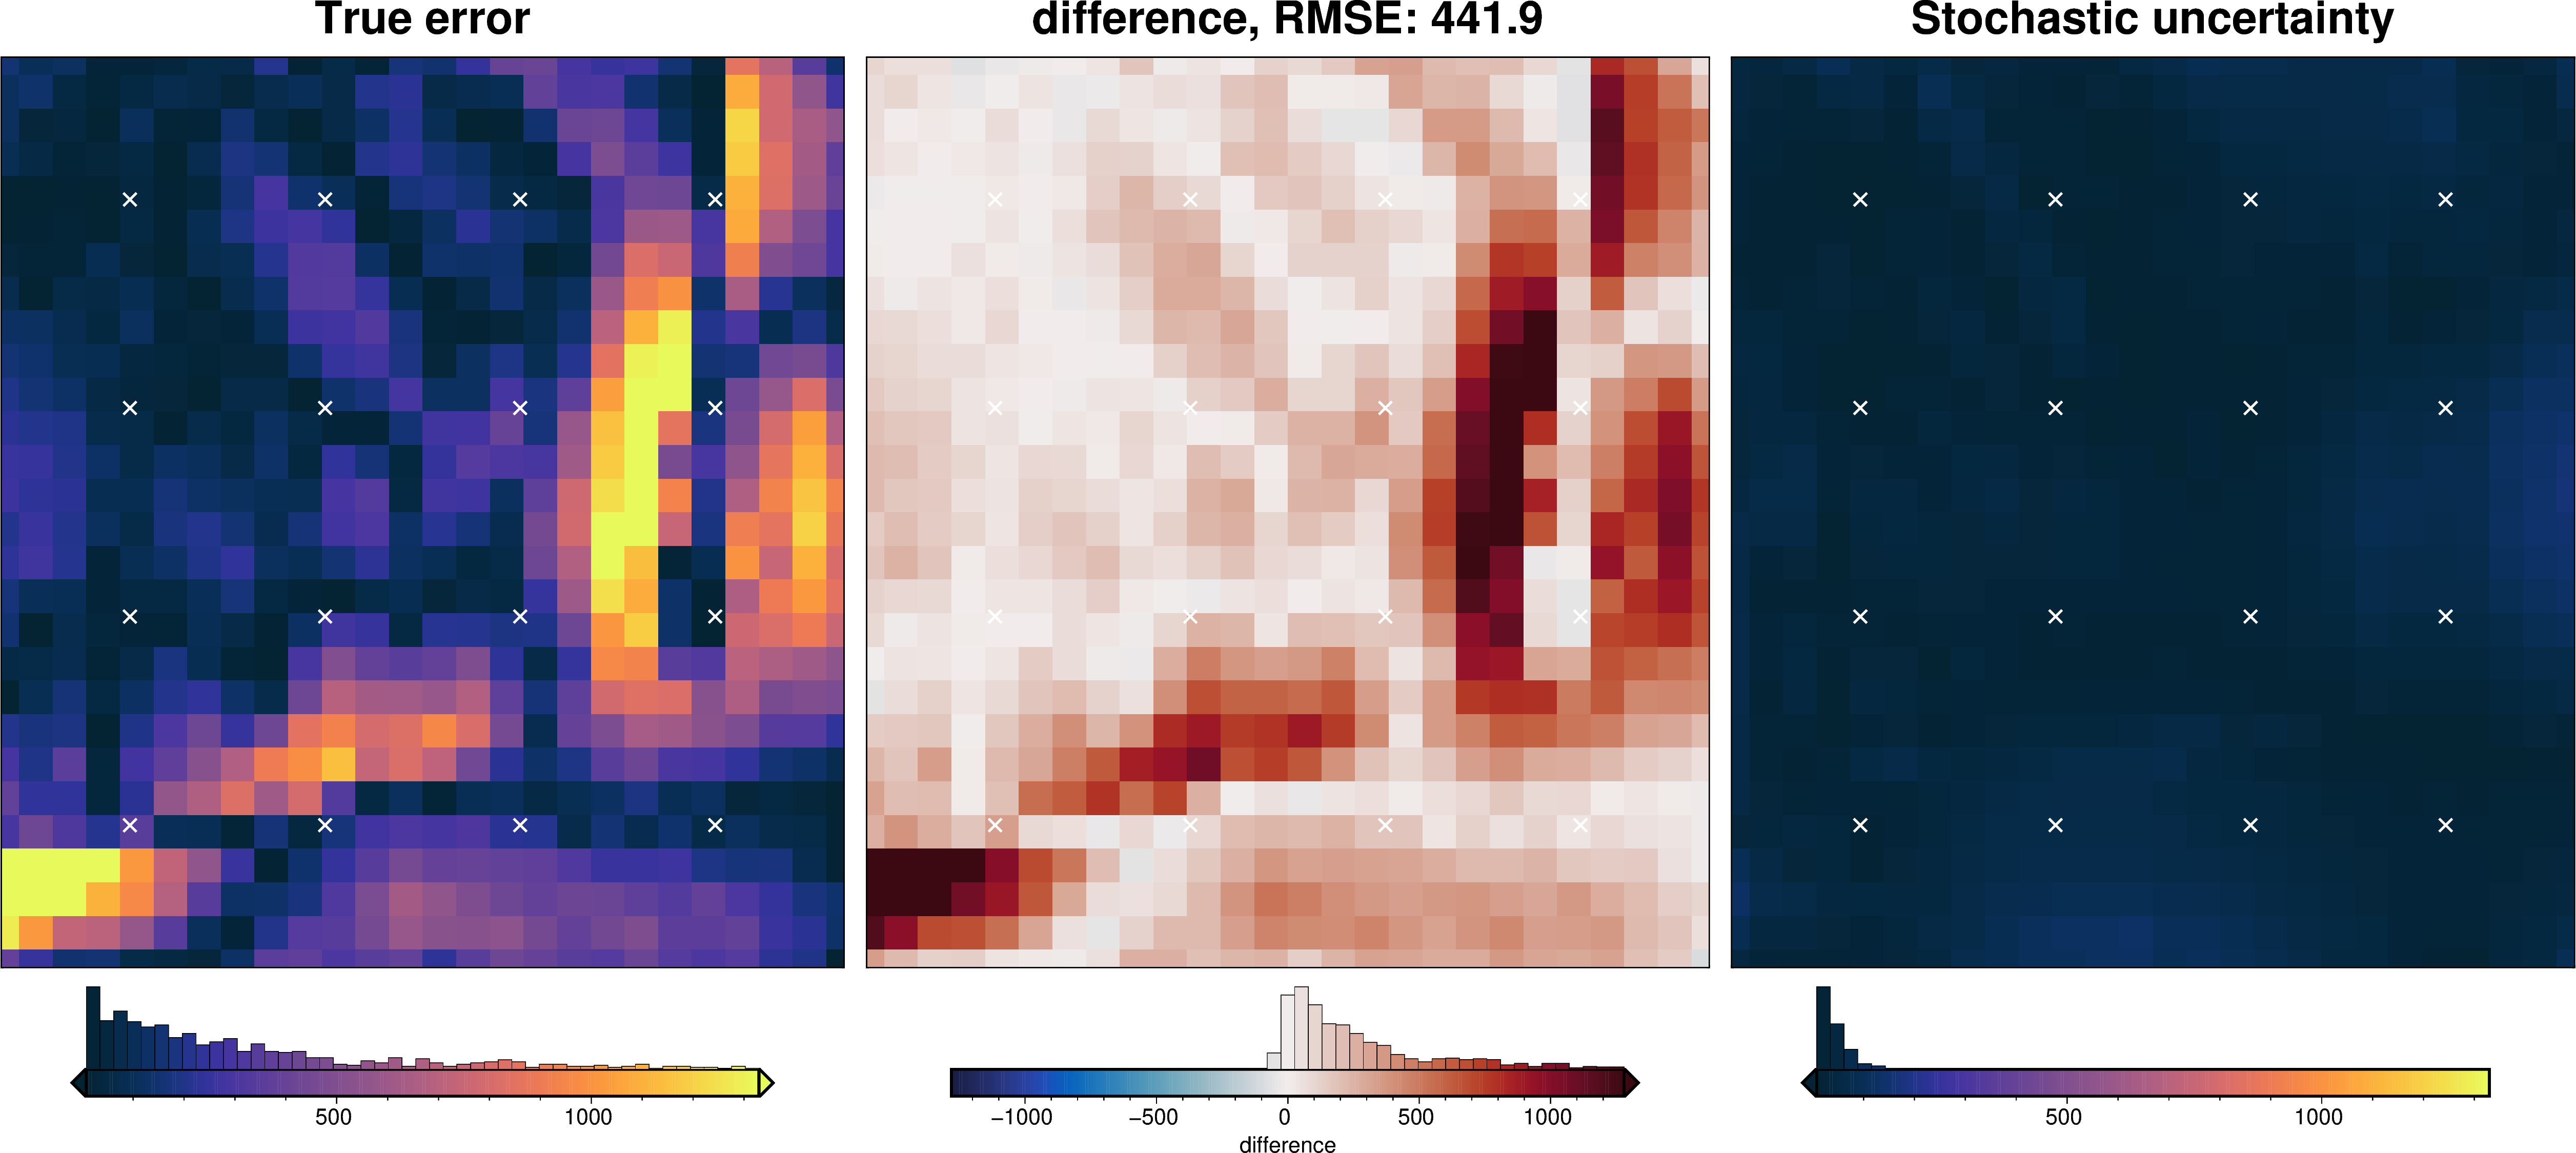

<xarray.Dataset> Size: 122kB
Dimensions:         (northing: 30, easting: 28, runs: 10)
Coordinates:
    top             (northing, easting) float64 7kB -5.932e+03 ... -6.087e+03
    bottom          (northing, easting) float64 7kB -6.087e+03 ... -6.249e+03
  * northing        (northing) float64 240B 1.959e+05 2.059e+05 ... 4.859e+05
  * easting         (easting) float64 224B 5.69e+04 6.69e+04 ... 3.269e+05
  * runs            (runs) <U5 200B 'run_0' 'run_1' 'run_2' ... 'run_8' 'run_9'
Data variables:
    run_num         (runs, northing, easting) float64 67kB -5.932e+03 ... -6....
    z_mean          (northing, easting) float64 7kB -5.889e+03 ... -6.512e+03
    z_stdev         (northing, easting) float64 7kB 77.25 84.21 ... 268.8 306.9
    weighted_mean   (northing, easting) float64 7kB -5.909e+03 ... -6.45e+03
    weighted_stdev  (northing, easting) float64 7kB 42.53 45.31 ... 186.2 186.0
    z_min           (northing, easting) float64 7kB -5.994e+03 ... -7.273e+03
    z_max           (northing, easting) float64 7kB -5.689e+03 ... -6.09e+03

In [58]:
fname = "../tmp/bishop_model_uncertainty_regional"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_regional_results = invert4geom.full_workflow_uncertainty_loop(
    optimal_inv,
    fname=fname,
    runs=10,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

uncert_plots(
    uncert_regional_results,
    optimal_inv.data.inner_region,
    optimal_inv.data.spacing,
    grid.basement_topo,
    constraints_df=constraint_points,
    weight_by="constraints",
)

### Total Uncertainty

stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

Iteration:   1%|1         | 1/100 [00:00<?, ?it/s]

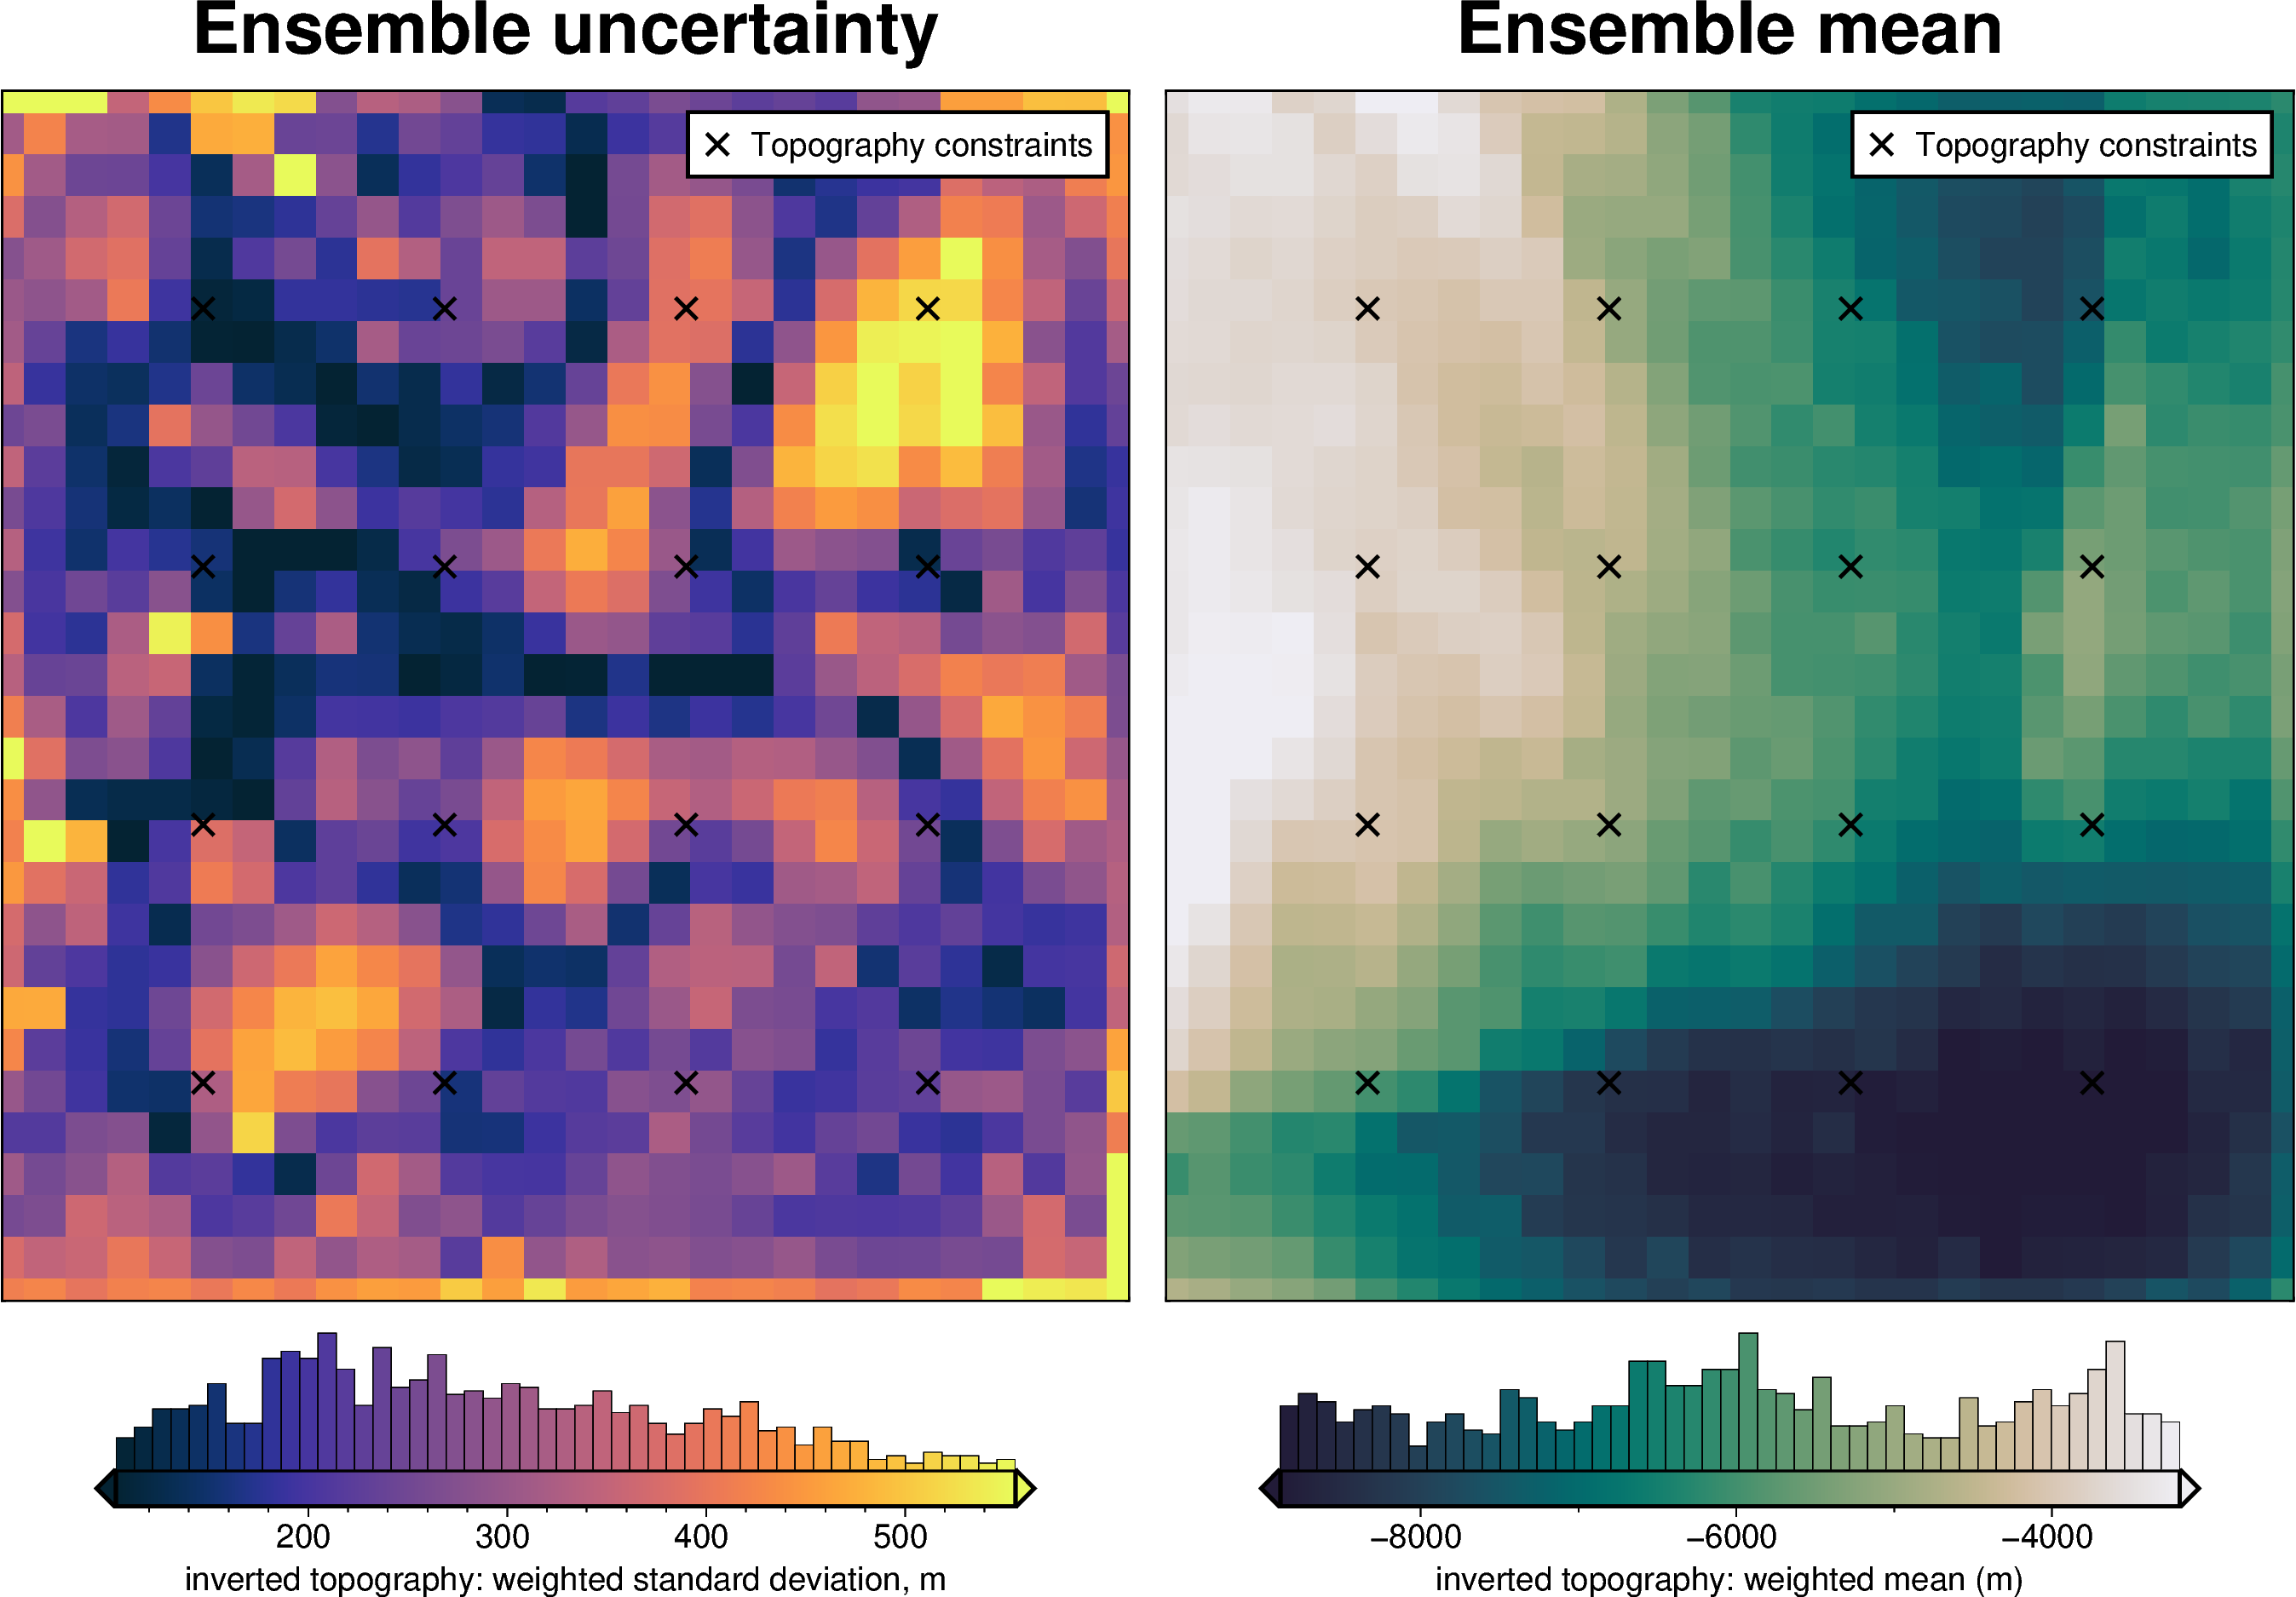

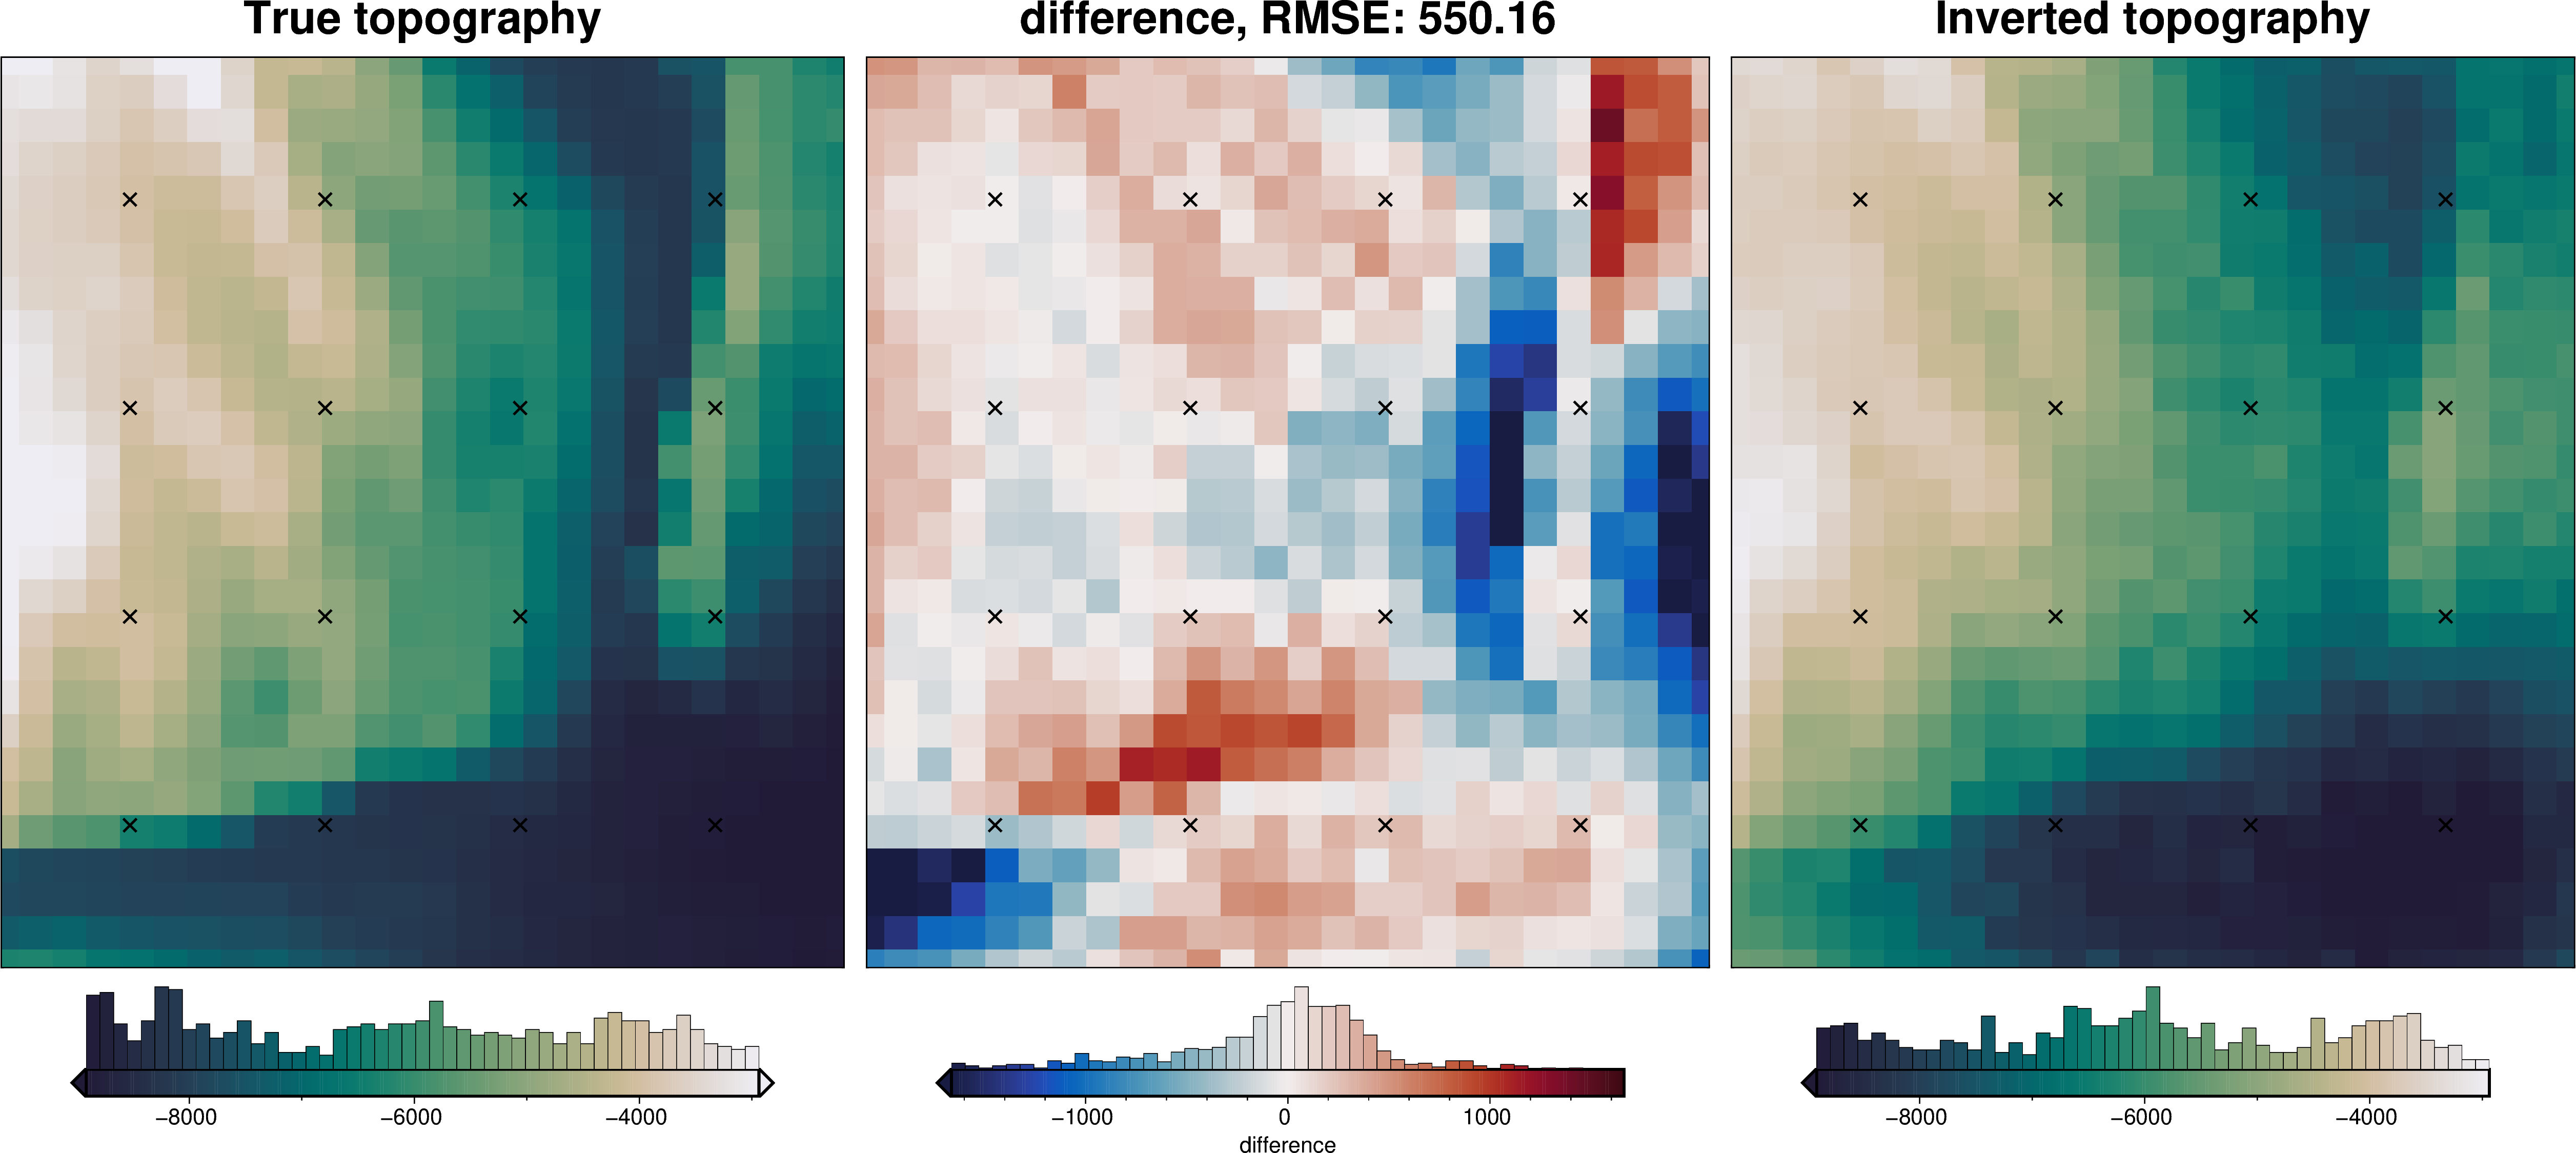

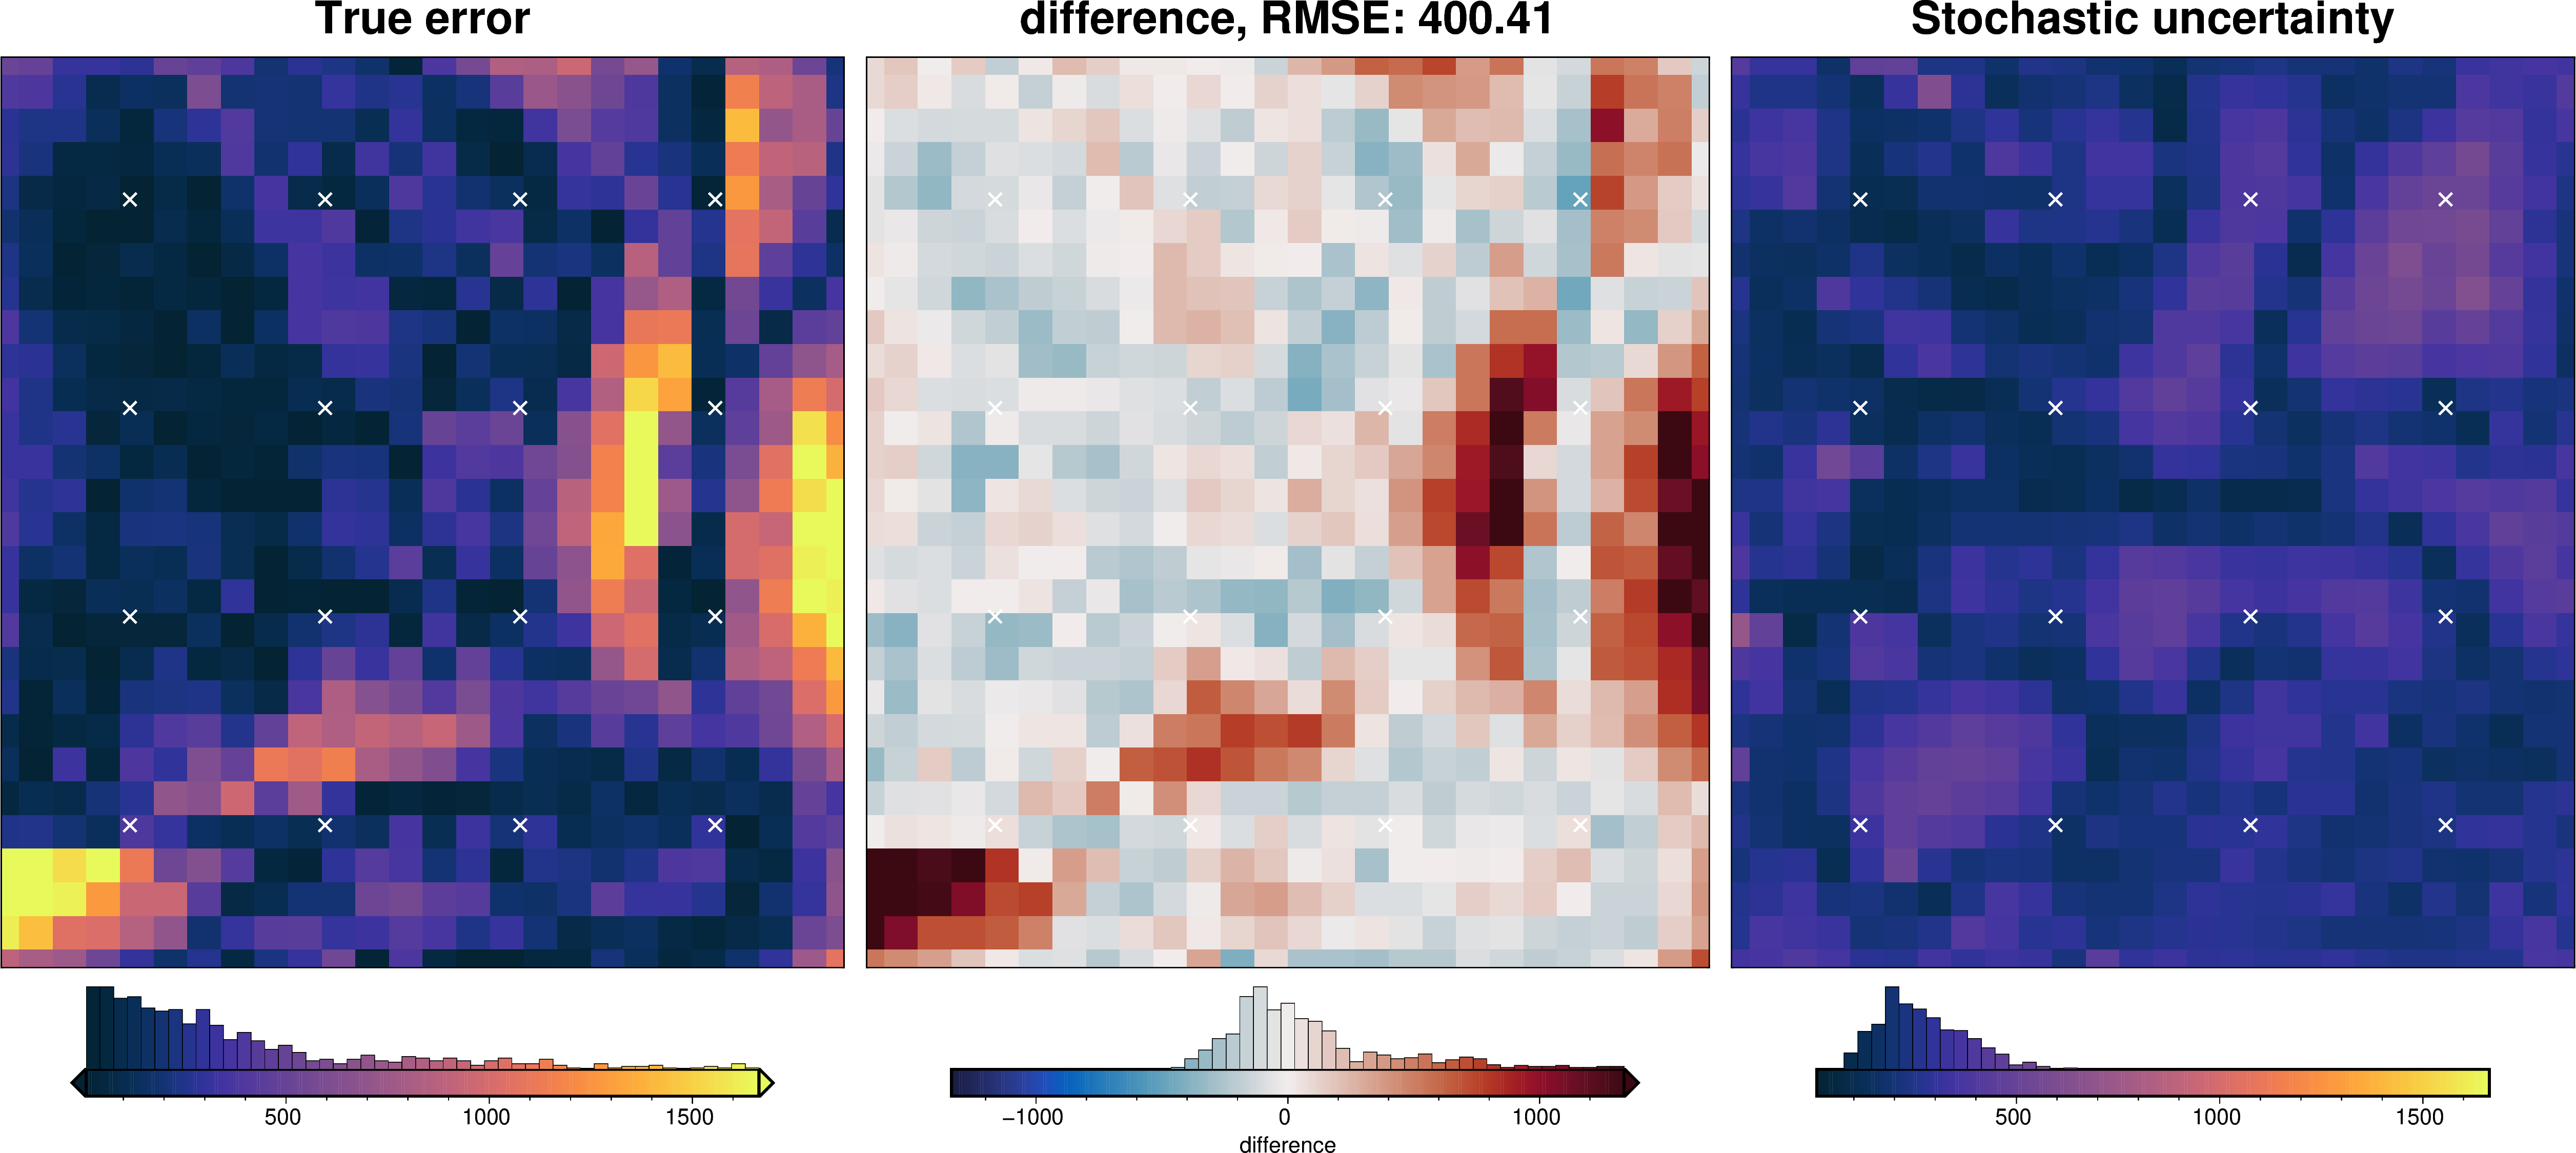

<xarray.Dataset> Size: 189kB
Dimensions:         (northing: 30, easting: 28, runs: 20)
Coordinates:
    top             (northing, easting) float64 7kB -3.546e+03 ... -3.546e+03
    bottom          (northing, easting) float64 7kB -3.901e+03 ... -5.216e+03
  * northing        (northing) float64 240B 1.959e+05 2.059e+05 ... 4.859e+05
  * easting         (easting) float64 224B 5.69e+04 6.69e+04 ... 3.269e+05
  * runs            (runs) <U6 480B 'run_0' 'run_1' ... 'run_18' 'run_19'
Data variables:
    run_num         (runs, northing, easting) float64 134kB -3.901e+03 ... -6...
    z_mean          (northing, easting) float64 7kB -4.58e+03 ... -6.183e+03
    z_stdev         (northing, easting) float64 7kB 436.5 578.2 ... 513.2 614.7
    weighted_mean   (northing, easting) float64 7kB -4.665e+03 ... -6.234e+03
    weighted_stdev  (northing, easting) float64 7kB 415.8 423.4 ... 491.5 571.3
    z_min           (northing, easting) float64 7kB -5.339e+03 ... -7.298e+03
    z_max           (northing, easting) float64 7kB -3.731e+03 ... -5.064e+03

In [59]:
fname = "../tmp/bishop_model_uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = invert4geom.full_workflow_uncertainty_loop(
    optimal_inv,
    fname=fname,
    runs=20,
    sample_gravity=True,
    sample_constraints=True,
    constraints_df=constraint_points,
    parameter_dict=density_dict | zref_dict | solver_dict,
    regional_grav_kwargs=new_regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
)

uncert_plots(
    uncert_results,
    optimal_inv.data.inner_region,
    optimal_inv.data.spacing,
    grid.basement_topo,
    constraints_df=constraint_points,
    weight_by="constraints",
)

## Comparing results

In [60]:
results = [
    uncert_results,
    uncert_regional_results,
    uncert_grav_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_zref_results,
    uncert_damping_results,
]
names = [
    "full",
    "regional",
    "grav",
    "constraints",
    "density",
    "zref",
    "damping",
]
# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = invert4geom.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
        region=optimal_inv.data.inner_region,
    )
    stats.append(ds)

In [61]:
# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs, compat="override")
merged

<xarray.Dataset> Size: 61kB
Dimensions:            (northing: 30, easting: 28)
Coordinates:
    top                (northing, easting) float64 7kB -3.546e+03 ... -3.546e+03
    bottom             (northing, easting) float64 7kB -3.901e+03 ... -5.216e+03
  * northing           (northing) float64 240B 1.959e+05 2.059e+05 ... 4.859e+05
  * easting            (easting) float64 224B 5.69e+04 6.69e+04 ... 3.269e+05
Data variables:
    full_stdev         (northing, easting) float64 7kB 415.8 423.4 ... 571.3
    regional_stdev     (northing, easting) float64 7kB 42.53 45.31 ... 186.0
    grav_stdev         (northing, easting) float64 7kB 26.46 74.0 ... 29.43
    constraints_stdev  (northing, easting) float64 7kB 90.02 97.59 ... 59.08
    density_stdev      (northing, easting) float64 7kB 12.68 25.43 ... 7.945
    zref_stdev         (northing, easting) float64 7kB 3.465 8.459 ... 2.362
    damping_stdev      (northing, easting) float64 7kB 29.24 32.43 ... 20.35

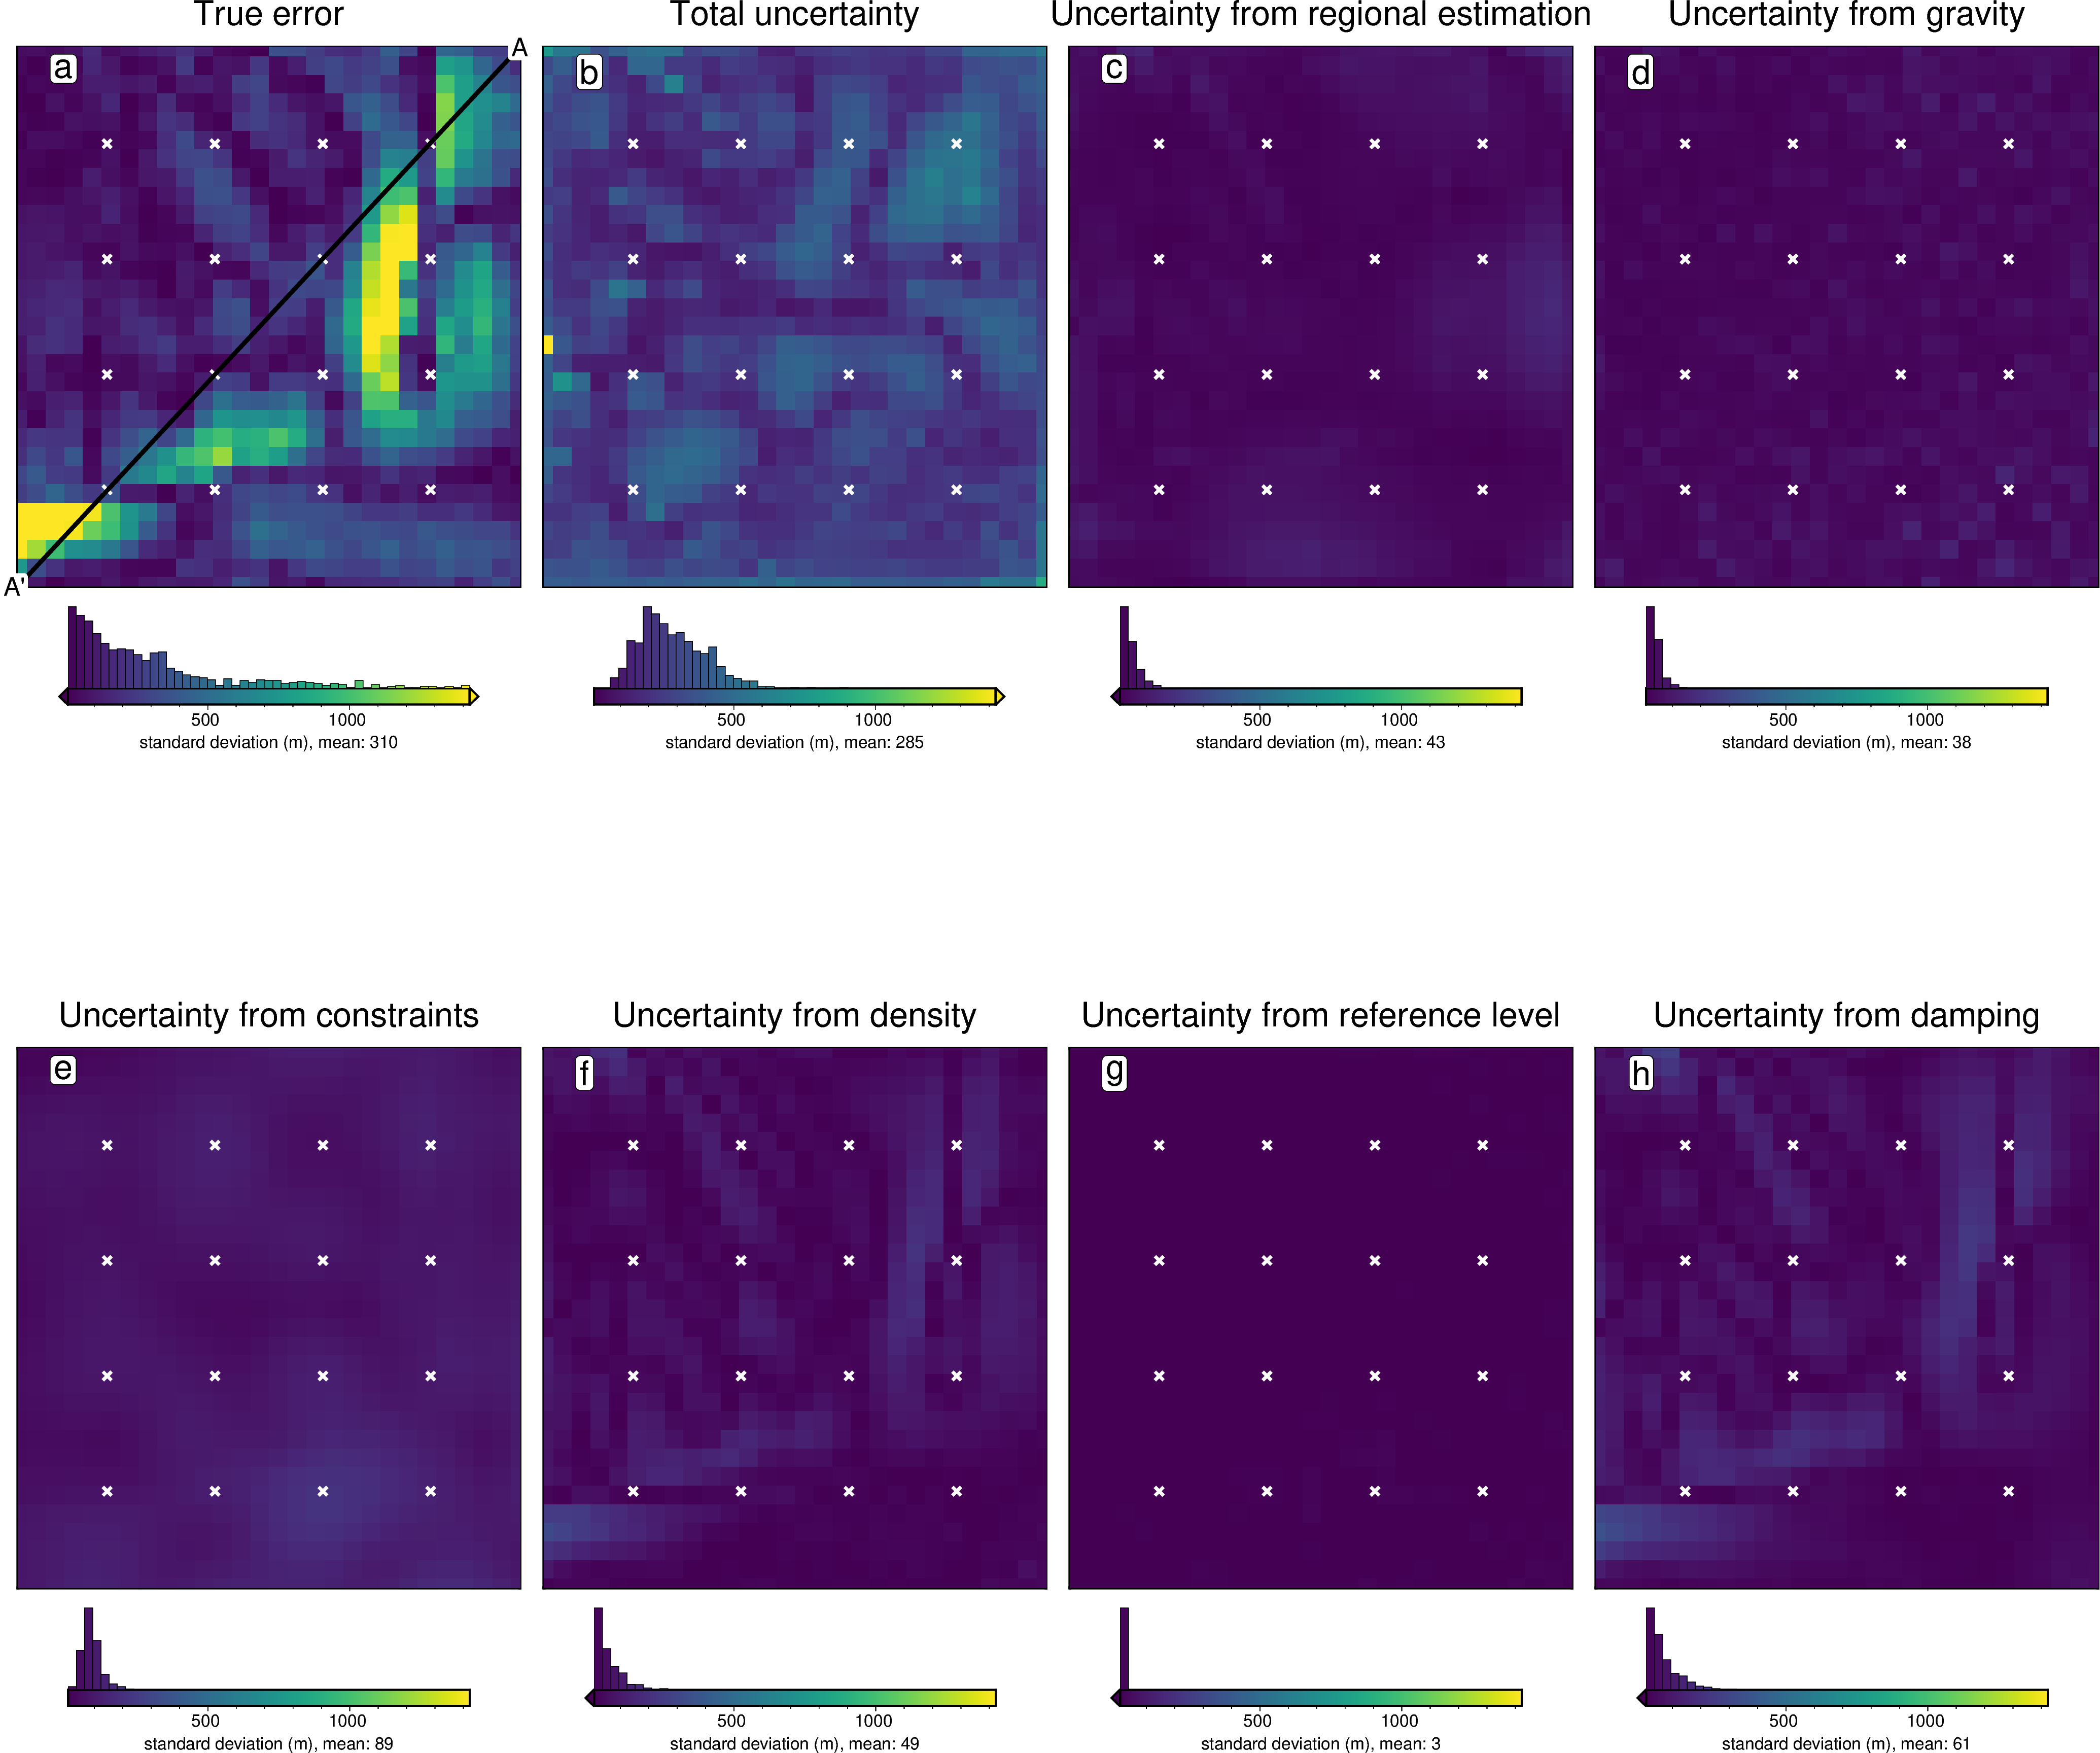

In [62]:
titles = [
    "True error",
    "Total uncertainty",
    "Uncertainty from regional estimation",
    "Uncertainty from gravity",
    "Uncertainty from constraints",
    "Uncertainty from density",
    "Uncertainty from reference level",
    "Uncertainty from damping",
]
grids = list(merged.data_vars.values())

# grids.insert(0, np.abs(stats[0].weighted_mean - grid.basement_topo))
grids.insert(0, inversion_error)

grids = [
    g.sel(
        easting=slice(
            optimal_inv.data.inner_region[0], optimal_inv.data.inner_region[1]
        ),
        northing=slice(
            optimal_inv.data.inner_region[2], optimal_inv.data.inner_region[3]
        ),
    )
    for g in grids
]
cpt_lims = ptk.get_min_max(
    grids[0],
    robust=True,
)

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
        # cpt_lims = ptk.get_min_max(
        #     g,
        #     robust=True,
        # )
    elif i == 4:
        origin_shift = "both"
        xshift_amount = -3
    else:
        origin_shift = "x"

    fig = ptk.plot_grid(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        # cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.25,
        points=constraint_points,
        points_style="x.2c",
        points_pen="1.5p",
        points_fill="white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profile location, and endpoints on map
        start = [optimal_inv.data.inner_region[1], optimal_inv.data.inner_region[3]]
        stop = [optimal_inv.data.inner_region[0], optimal_inv.data.inner_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

grdtrack [WARNING]: Some input points were outside the grid domain(s).


grdtrack [WARNING]: Some input points were outside the grid domain(s).


grdtrack [WARNING]: Some input points were outside the grid domain(s).


grdtrack [WARNING]: Some input points were outside the grid domain(s).


grdtrack [WARNING]: Some input points were outside the grid domain(s).


grdtrack [WARNING]: Some input points were outside the grid domain(s).


grdtrack [WARNING]: Some input points were outside the grid domain(s).


grdtrack [WARNING]: Some input points were outside the grid domain(s).


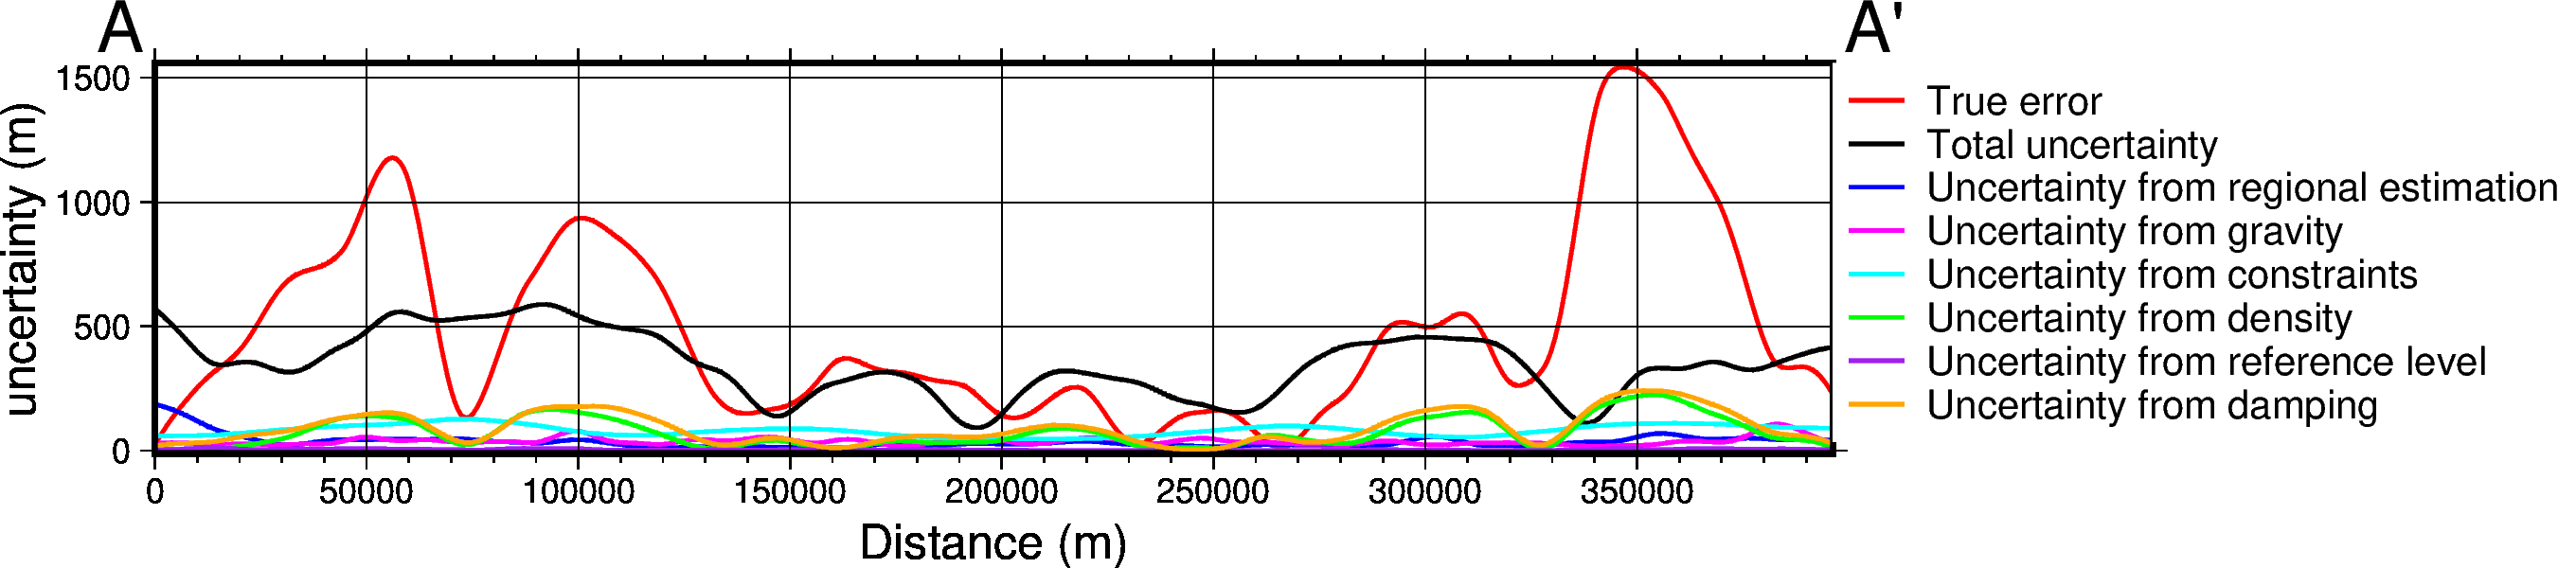

In [63]:
data_dict = ptk.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
        "orange",
    ],
)

fig, df_data = ptk.plot_data(
    "points",
    start=[optimal_inv.data.inner_region[1], optimal_inv.data.inner_region[3]],
    stop=[optimal_inv.data.inner_region[0], optimal_inv.data.inner_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()